## TOC:
* [Goal](#goal)
* [Method](#method)
* [Results](#results)
* [EDA](#eda)
    * [Stationarity Testing](#stationarity-testing)
* [Arima](#arima)
    * [Arima Residual Test](#residual-analysis-of-arima-models)
    * [Interpretation](#interpretation)
    * [Predictions](#arima-predictions-with-95-confidence-interval)
* [GARCH](#garch)
    * [GARCH Prediction](#garch-forecasting)
        * [GARCH Model 2 Preds](#model-2-forecasting)
        * [GARCH Model 1 Preds *not implemented*](#model-1-forecasting)
* [Testing models on unseen data](#test-modeling)

# Goal:
- forecase the VIX index to use as part of the risk score 
- if vix is high, bad article may hit harder 

# Method 
- Break up the dataset to JUST the timeframe we have for prices.
    - 2022/01/01 - 2025/01/02
- Train 70%, Validation 15%, Test 15%
- Want to forecast VIX. 
    - SARIMA could be good for long term 
    - I think Arima-Garch would be best 
        - Arima does long term prediction
        - Garch would capture volatility 
    - We need next few weeks/days prediction. 

**APPROACH**
- EDA
    - Look at data, see if its stationary. if not, lets make it stationary.
        - diff, moving avg, non-parametric functions, etc.
        - make sure top run it through the tests.
            - Box Ljung for stationarity, Arch for volatility (GARCH), etc.
- Arima 
    - find best Ps and Qs
        - filter by AICc
    - Do residual analysis 
    - Make forecasts
    - If forecasts aren't great, lets couple with Garch
        - lets do some error modeling. so MAPE, MSE, PM
- Garch 
    - meant for volatility and capturing the heteroskedacity (? I forget how its spelled)
    - model it on residuals of ARIMA (if we differenced)
    - find best Ms and Ns using heuristic approach
        - step 1: find best P and Q
        - step 2: find best M and N with P and Q
        - step 3: find new best P and Q given found M and N
        - step 4: find new best M and N given the new P and Q 
        - step 5: compare BIC in models. if BICs are similar, take less complex model 
    - try to make predictions with the new Arima-Garch model 
    - remember, we will use residuals bc thats the portion of data **NOT** modeled by ARIMA
        - when we predict we reconstruct OG values 
            ```R
            forecasted_vix = cumsum(arima_predictions) + last_observed_vix
            ```

# Results 
- 

## EDA

In [196]:
# install.packages("duckdb")
# install.packages("FinTS")

suppressWarnings(suppressPackageStartupMessages(library("dplyr")))
suppressWarnings(suppressPackageStartupMessages(library("duckdb")))
suppressWarnings(suppressPackageStartupMessages(library(rugarch)))
suppressWarnings(suppressPackageStartupMessages(library(FinTS)))
suppressWarnings(suppressPackageStartupMessages(library(tseries)))
suppressWarnings(suppressPackageStartupMessages(library(lubridate)))

In [197]:
con <- dbConnect(duckdb::duckdb(), "C:/Users/jovan/Documents/CSE 6748 Practicum WITH DATA/financial_news.db", read_only = TRUE)

In [198]:
df = dbGetQuery(con, "SELECT * FROM SP500.vix_index")
# df2 = dbGetQuery(con, "SELECT * FROM headlines.trading_calendar")
# want to limit data to start at 2022/01/01 and end at 2025-01-02
df = df %>% filter(vix_date >= "2022-01-01" & vix_date <= "2025-01-02")

df$vix_date = as.Date(df$vix_date)
# head(df)
# tail(df2)
# tail(df)

df_weekly = df %>%
    mutate(week = format(vix_date, "%Y-%U")) %>%
    group_by(week) %>%
    summarise(vix_mean = mean(vix_value), vix_last = last(vix_value))

# head(df_weekly)
# tail(df_weekly)

In [199]:
temp = df %>% filter(vix_date <= "2023-01-01")
# length of temp 
length(temp$vix_date)

[1] 251

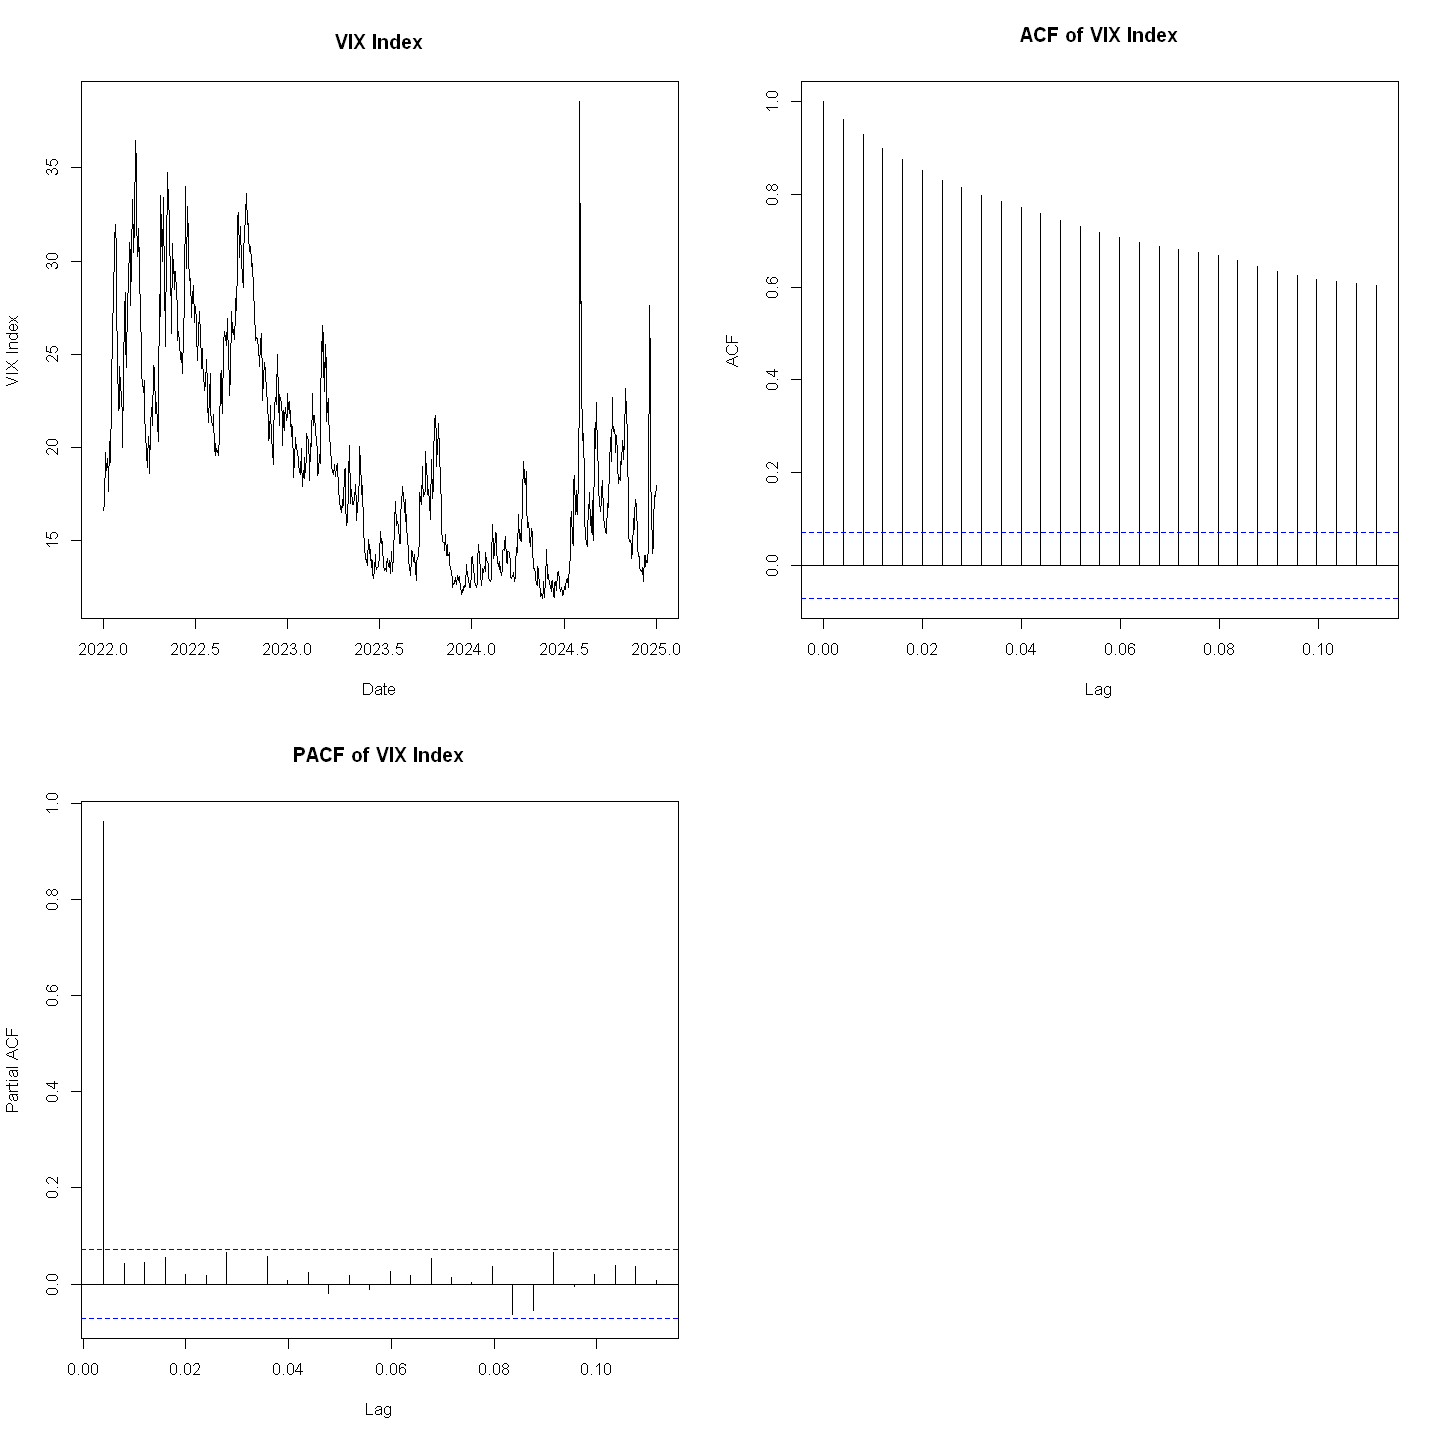

In [200]:
vix_ts = ts(df$vix_value, start = c(2022, 1),  frequency = 251)
par(mfrow = c(2, 2))
plot(vix_ts, type = "l", main = "VIX Index", xlab = "Date", ylab = "VIX Index")
acf(vix_ts, main = "ACF of VIX Index")
pacf(vix_ts, main = "PACF of VIX Index")

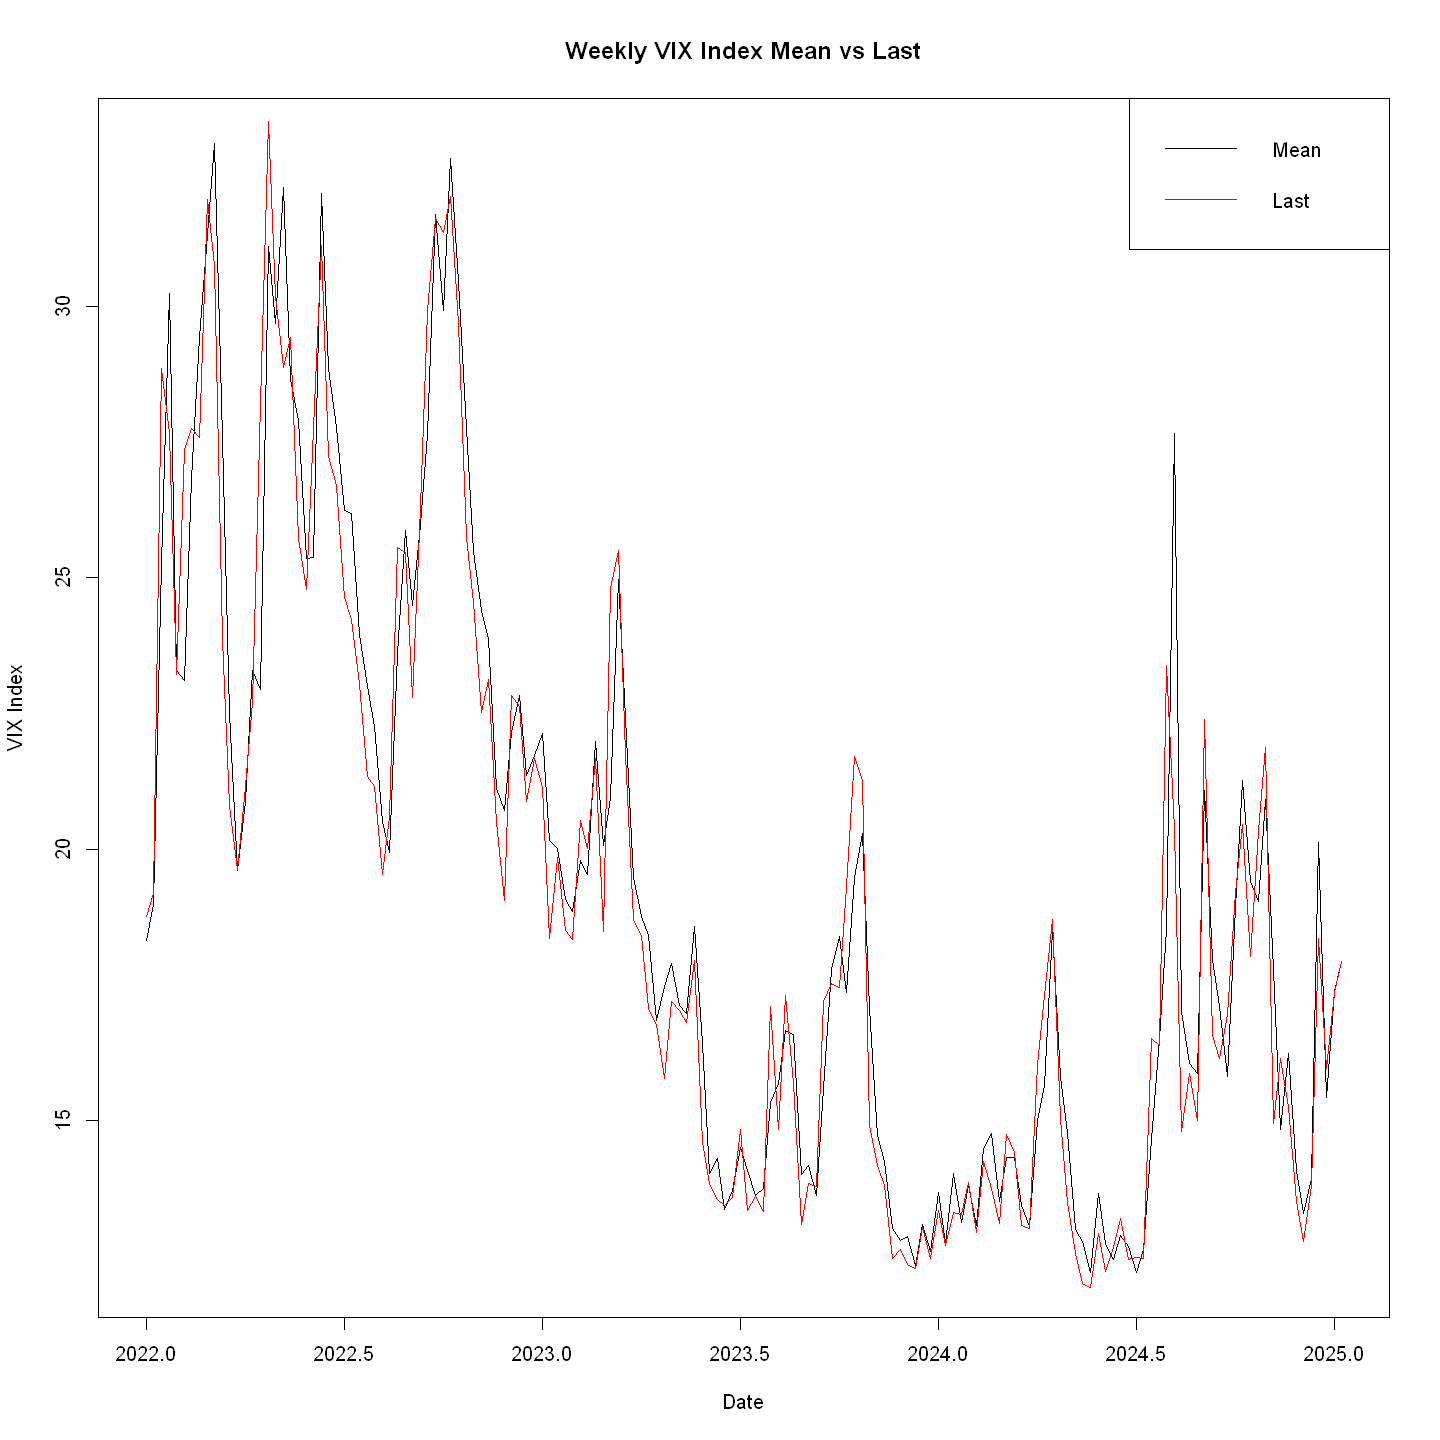

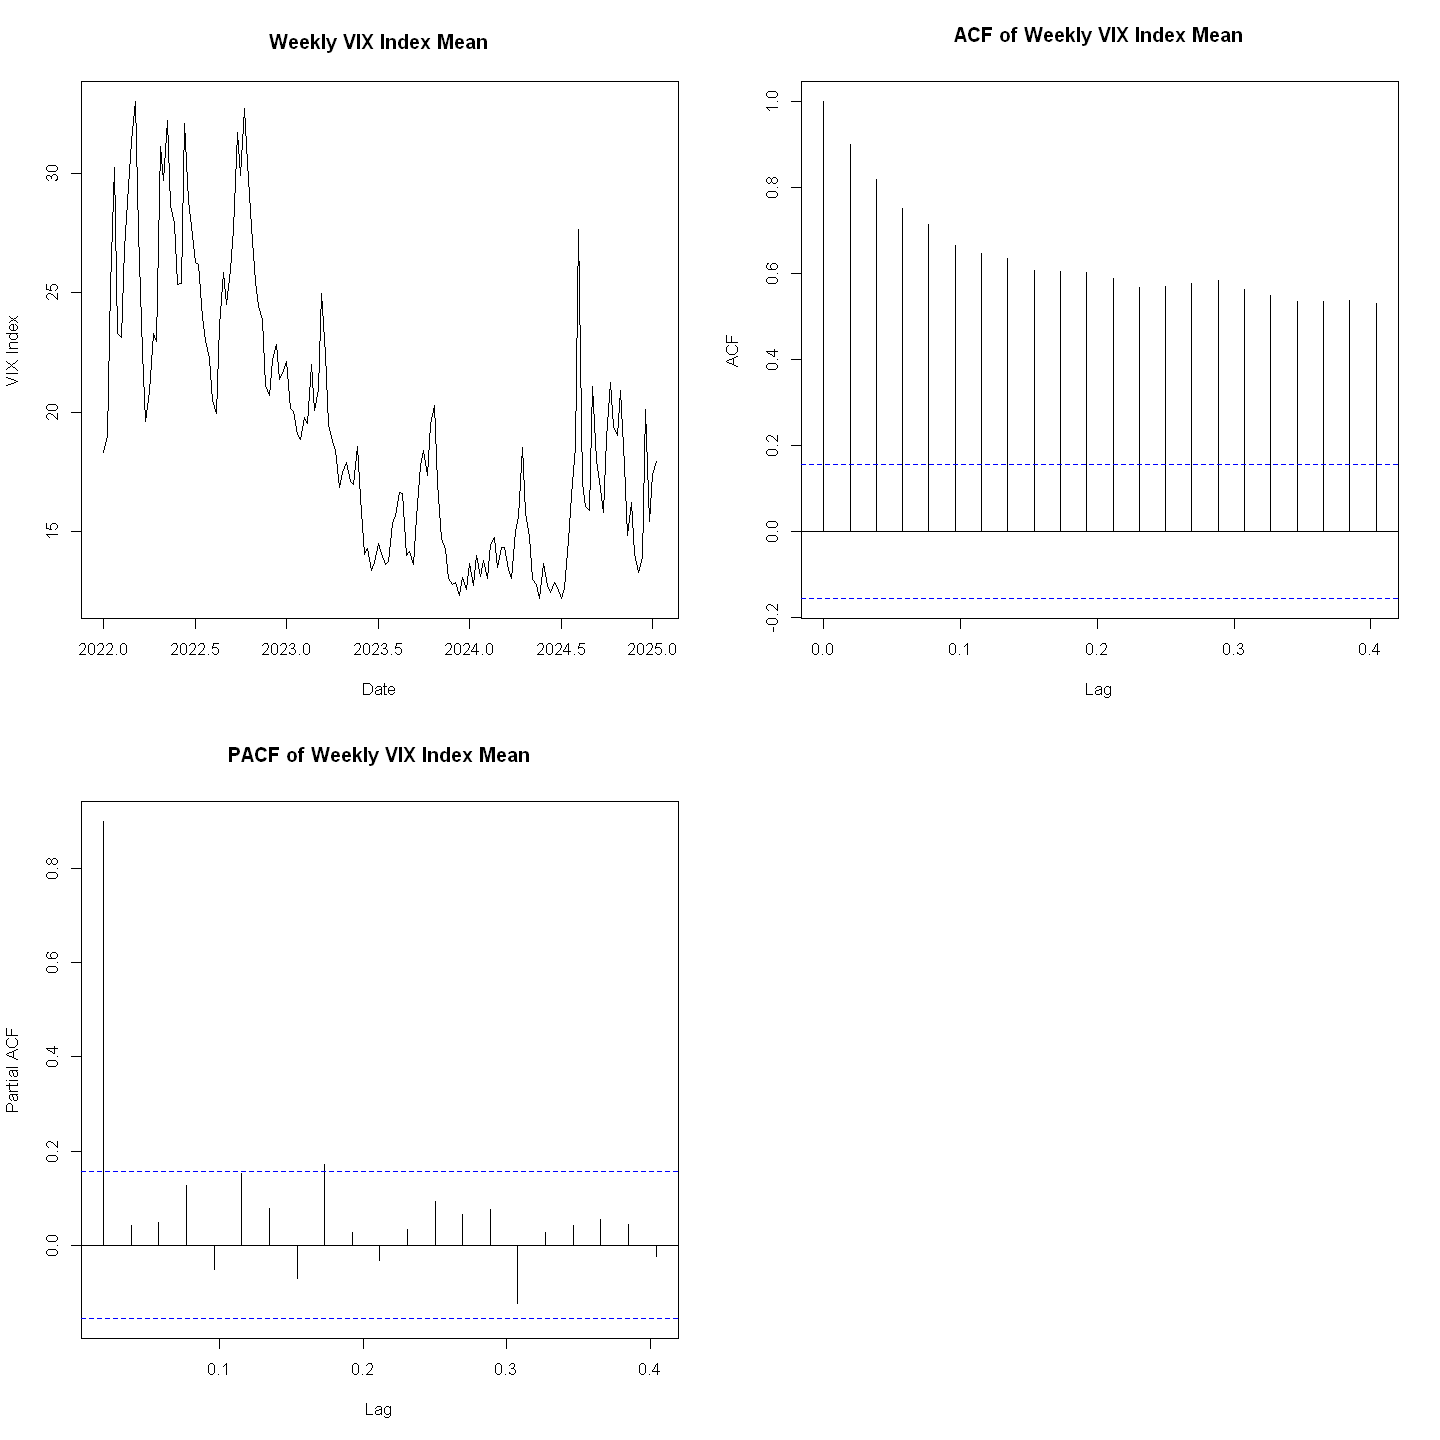

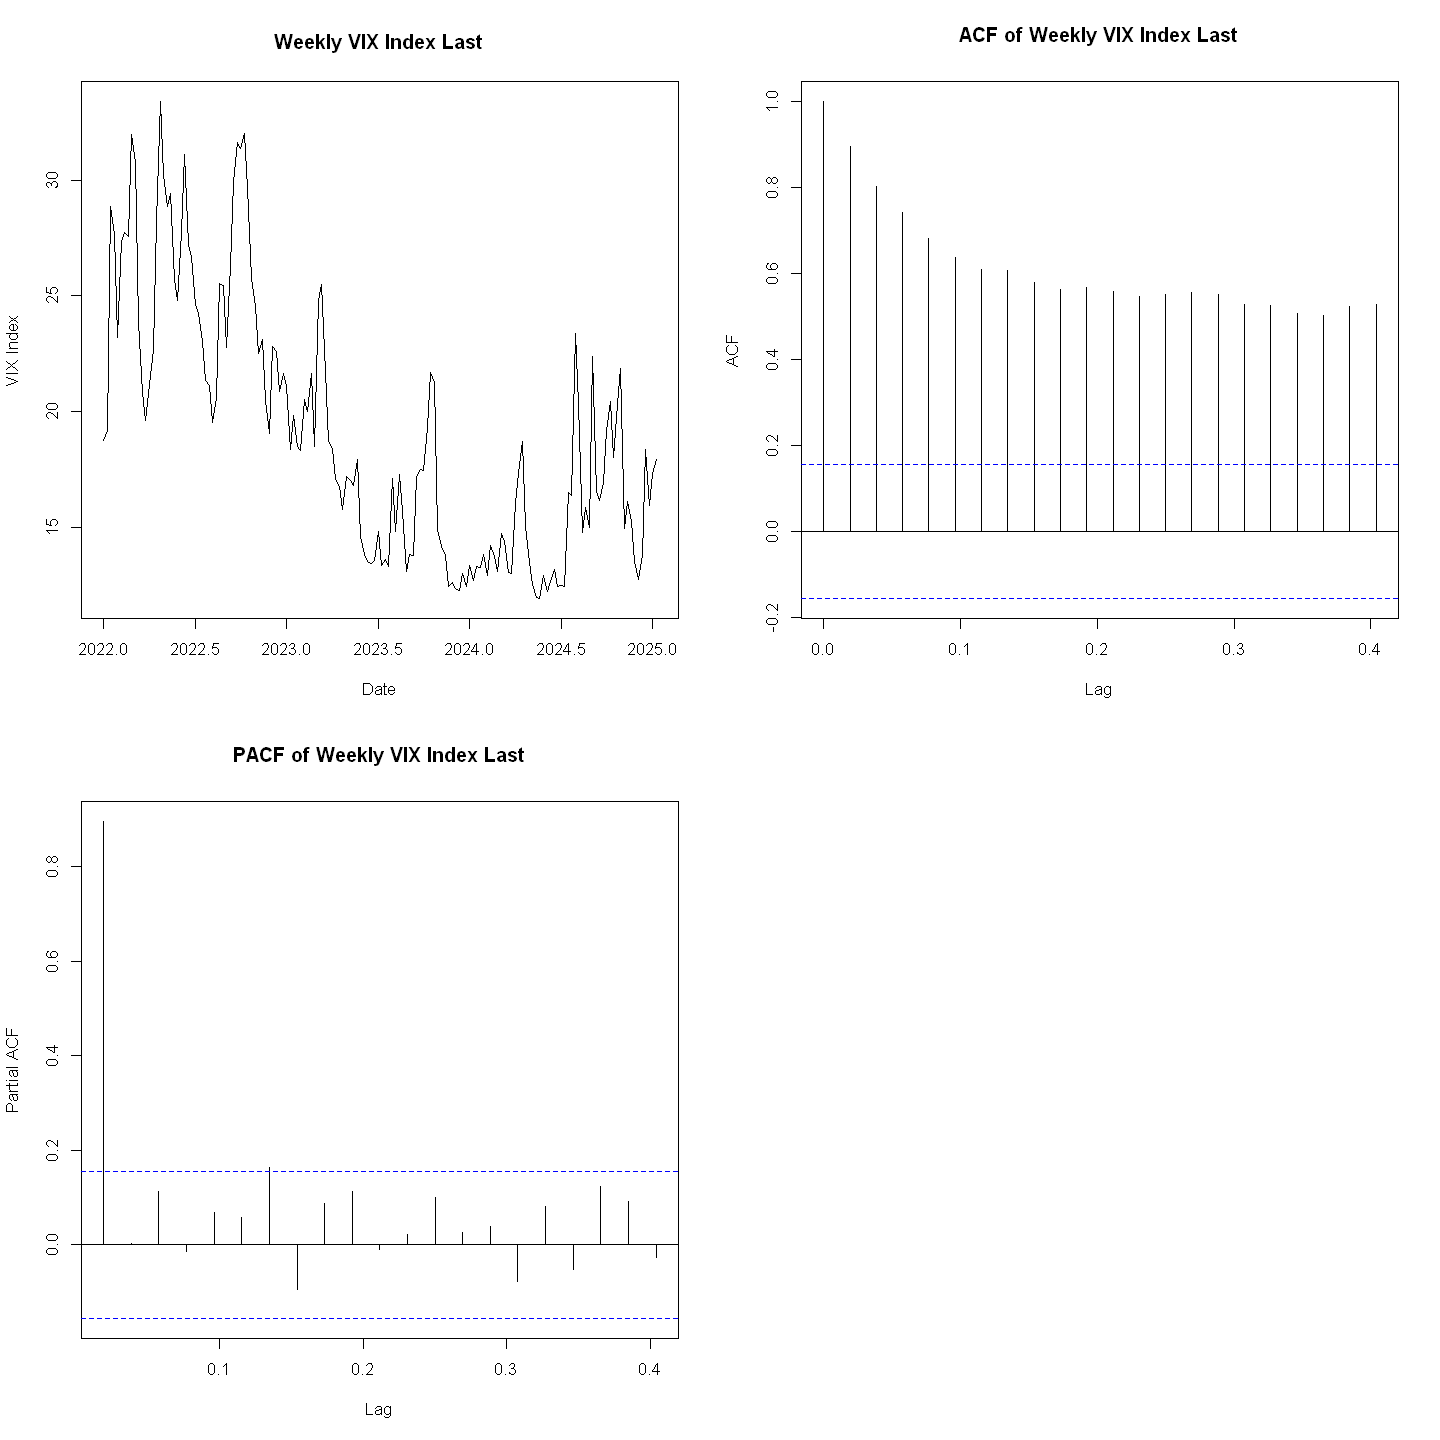

In [201]:
vix_weekly_ts_mean = ts(df_weekly$vix_mean, start = c(2022, 1), frequency = 52)
vix_weekly_ts_last = ts(df_weekly$vix_last, start = c(2022, 1), frequency = 52)

# increase size of plot
options(repr.plot.width=12, repr.plot.height=12)

# overlay weeklys
plot(vix_weekly_ts_mean, type = "l", main = "Weekly VIX Index Mean vs Last", xlab = "Date", ylab = "VIX Index")
lines(vix_weekly_ts_last, col = "red")
legend("topright", legend = c("Mean", "Last"), col = c("black", "red"), lty = 1)

par(mfrow = c(2, 2))
plot(vix_weekly_ts_mean, type = "l", main = "Weekly VIX Index Mean", xlab = "Date", ylab = "VIX Index")
acf(vix_weekly_ts_mean, main = "ACF of Weekly VIX Index Mean")
pacf(vix_weekly_ts_mean, main = "PACF of Weekly VIX Index Mean")

par(mfrow = c(2, 2))
plot(vix_weekly_ts_last, type = "l", main = "Weekly VIX Index Last", xlab = "Date", ylab = "VIX Index")
acf(vix_weekly_ts_last, main = "ACF of Weekly VIX Index Last")
pacf(vix_weekly_ts_last, main = "PACF of Weekly VIX Index Last")

### Stationarity Testing

In [202]:
adf.test(vix_weekly_ts_mean)  
adf.test(vix_weekly_ts_last)  
adf.test(vix_ts) 


	Augmented Dickey-Fuller Test

data:  vix_weekly_ts_mean
Dickey-Fuller = -2.7395, Lag order = 5, p-value = 0.268
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  vix_weekly_ts_last
Dickey-Fuller = -2.9134, Lag order = 5, p-value = 0.1955
alternative hypothesis: stationary


Warning message in adf.test(vix_ts):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  vix_ts
Dickey-Fuller = -4.0732, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


all 3 show trend and seasonality

weekly are obviously smoother but are slightly shifted based on mean and close 

weird cause Daily says stationary but weekly are not

Warning message in adf.test(diff(vix_ts)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff(vix_ts)
Dickey-Fuller = -10.503, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


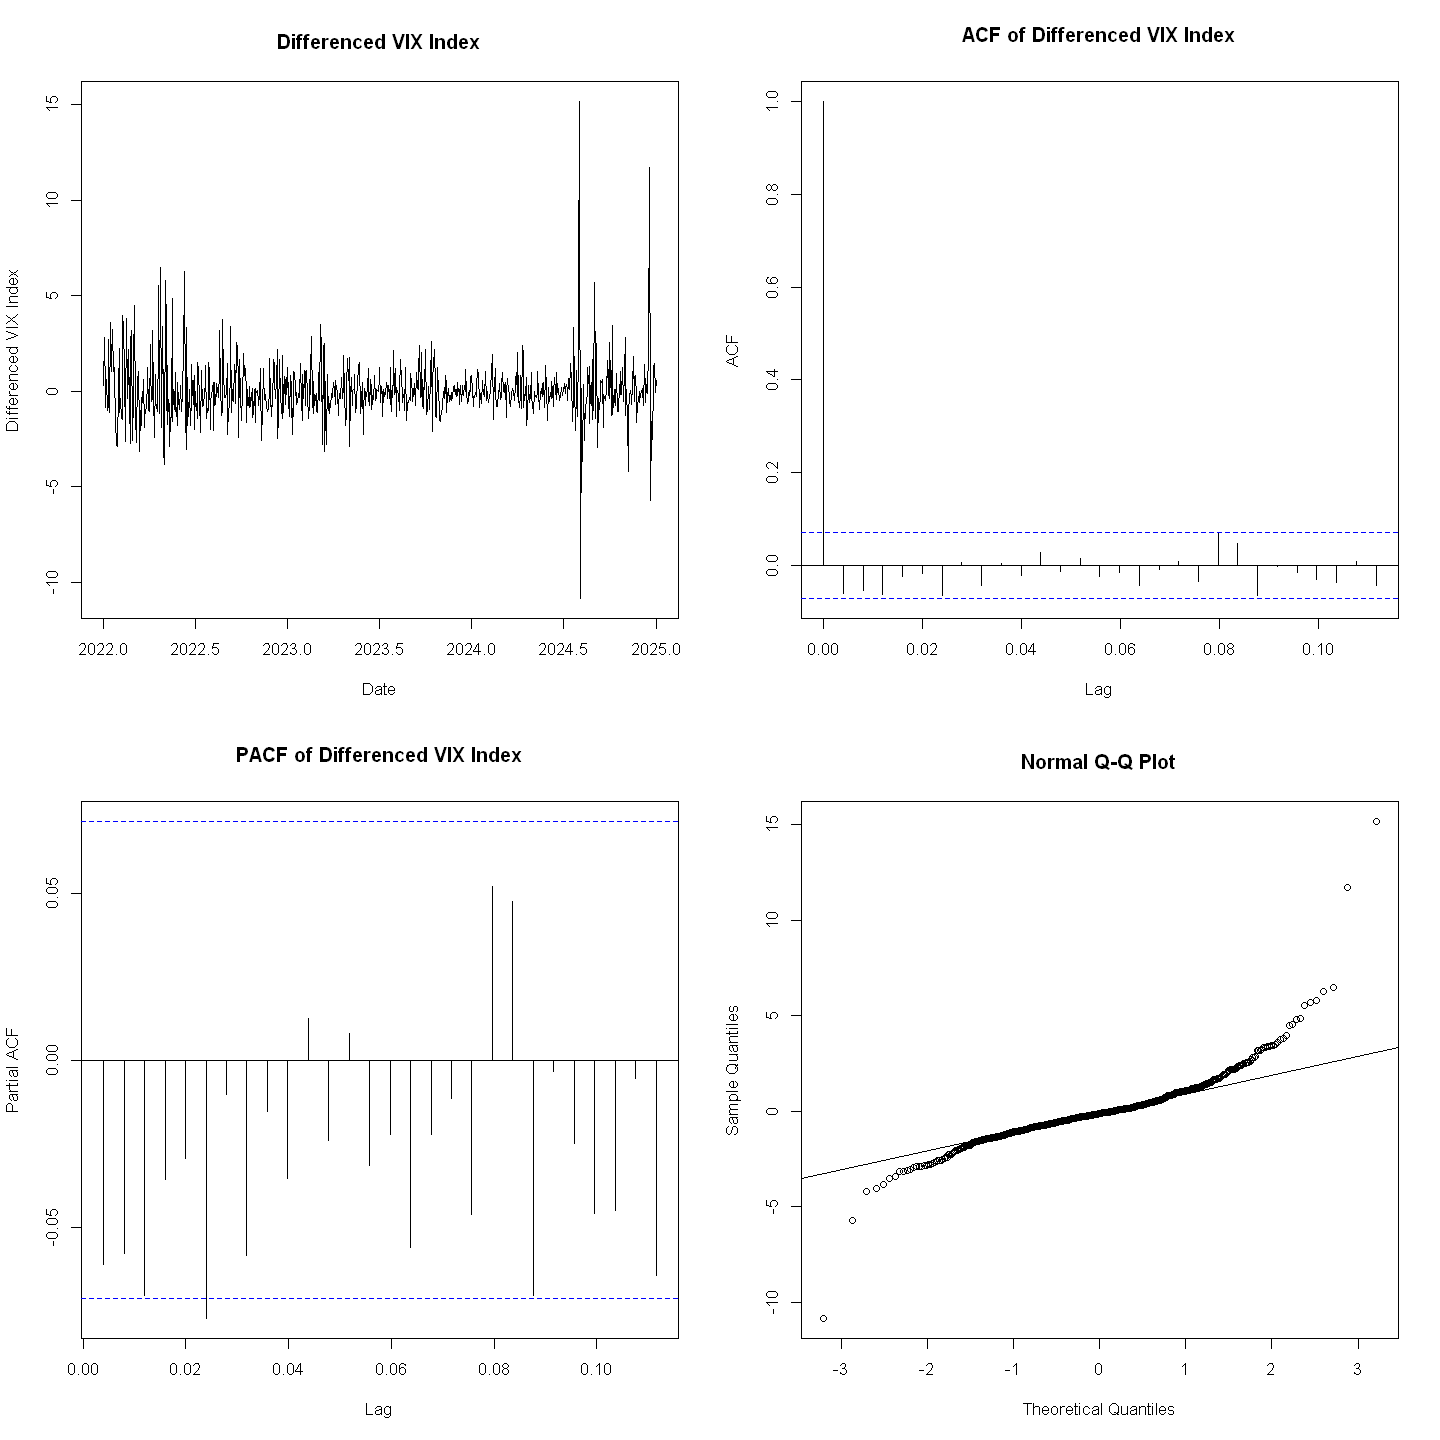

In [203]:
par(mfrow = c(2, 2))
plot(diff(vix_ts), type = "l", main = "Differenced VIX Index", xlab = "Date", ylab = "Differenced VIX Index")
acf(diff(vix_ts), main = "ACF of Differenced VIX Index")
pacf(diff(vix_ts), main = "PACF of Differenced VIX Index")
qqnorm(diff(vix_ts))
qqline(diff(vix_ts))

adf.test(diff(vix_ts))

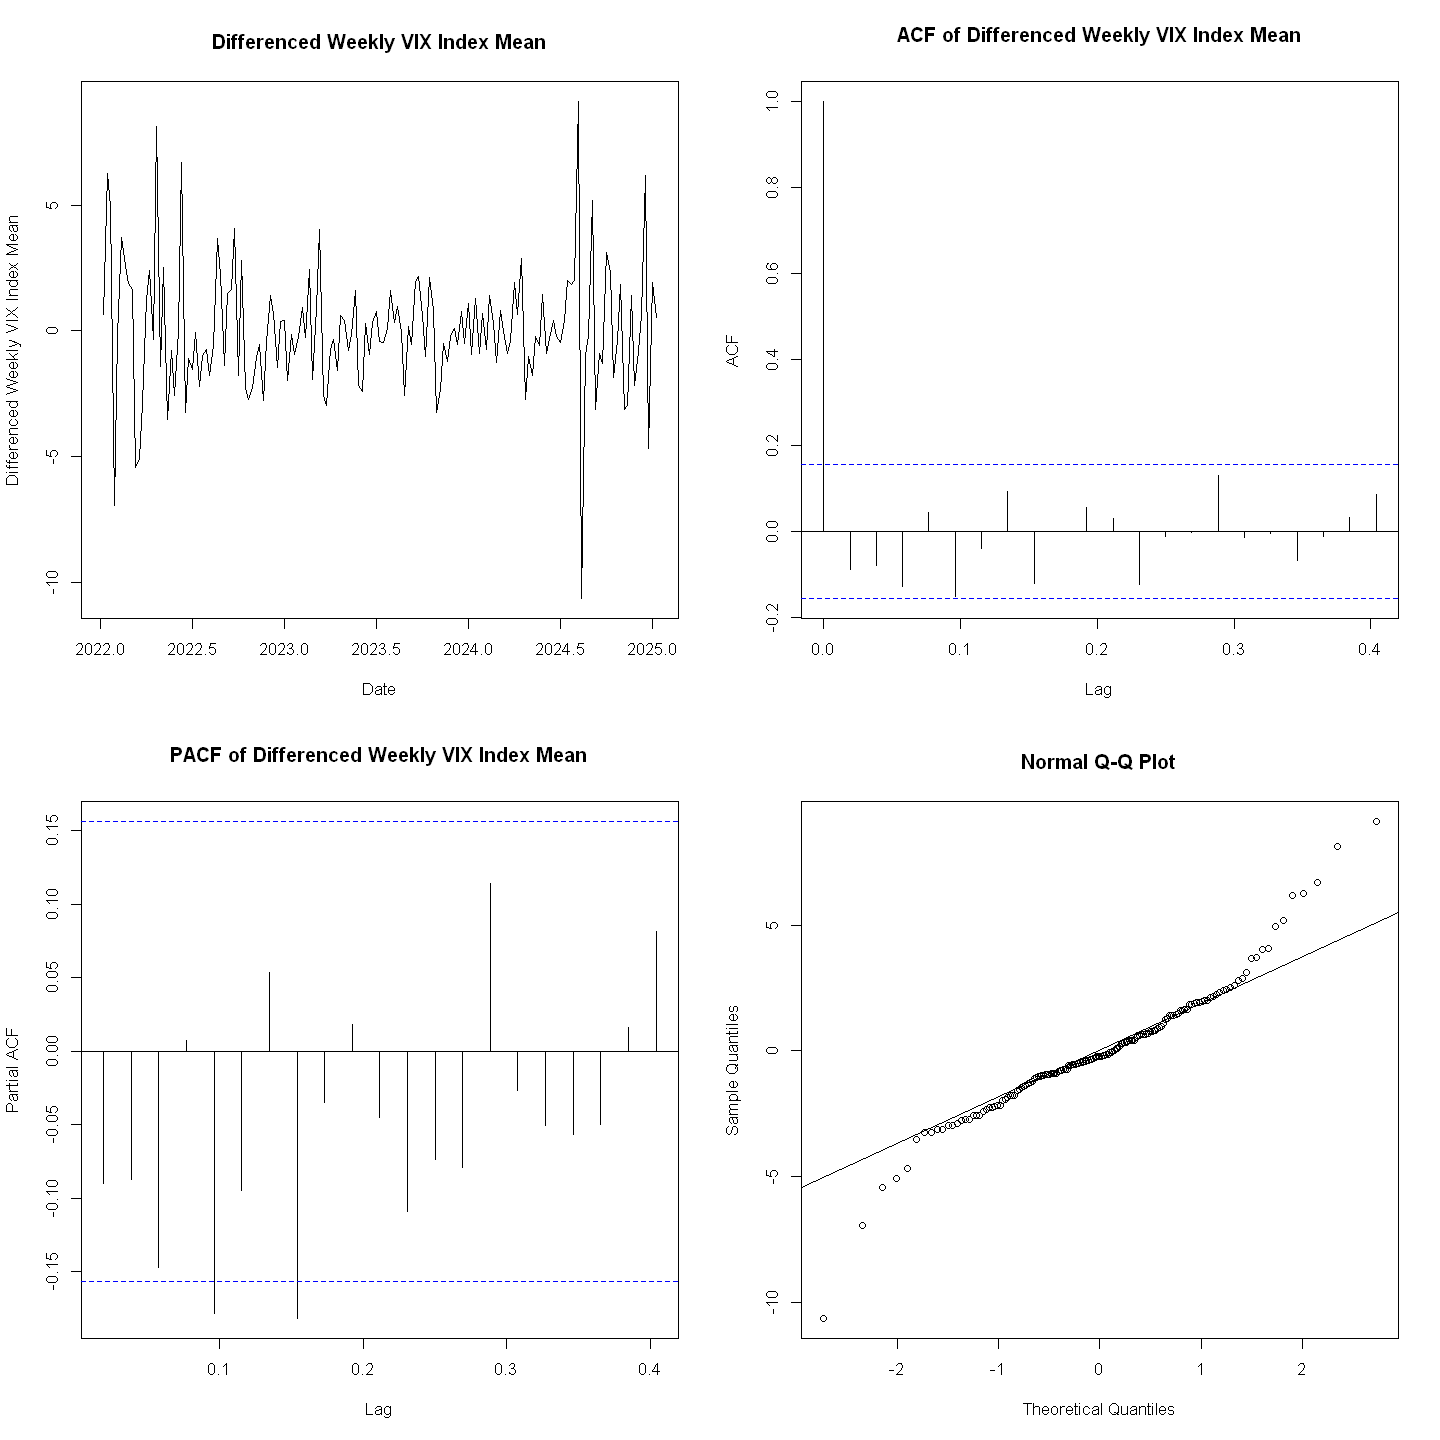

Warning message in adf.test(diff(vix_weekly_ts_mean)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff(vix_weekly_ts_mean)
Dickey-Fuller = -7.1329, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(diff(vix_weekly_ts_last)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff(vix_weekly_ts_last)
Dickey-Fuller = -7.5554, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


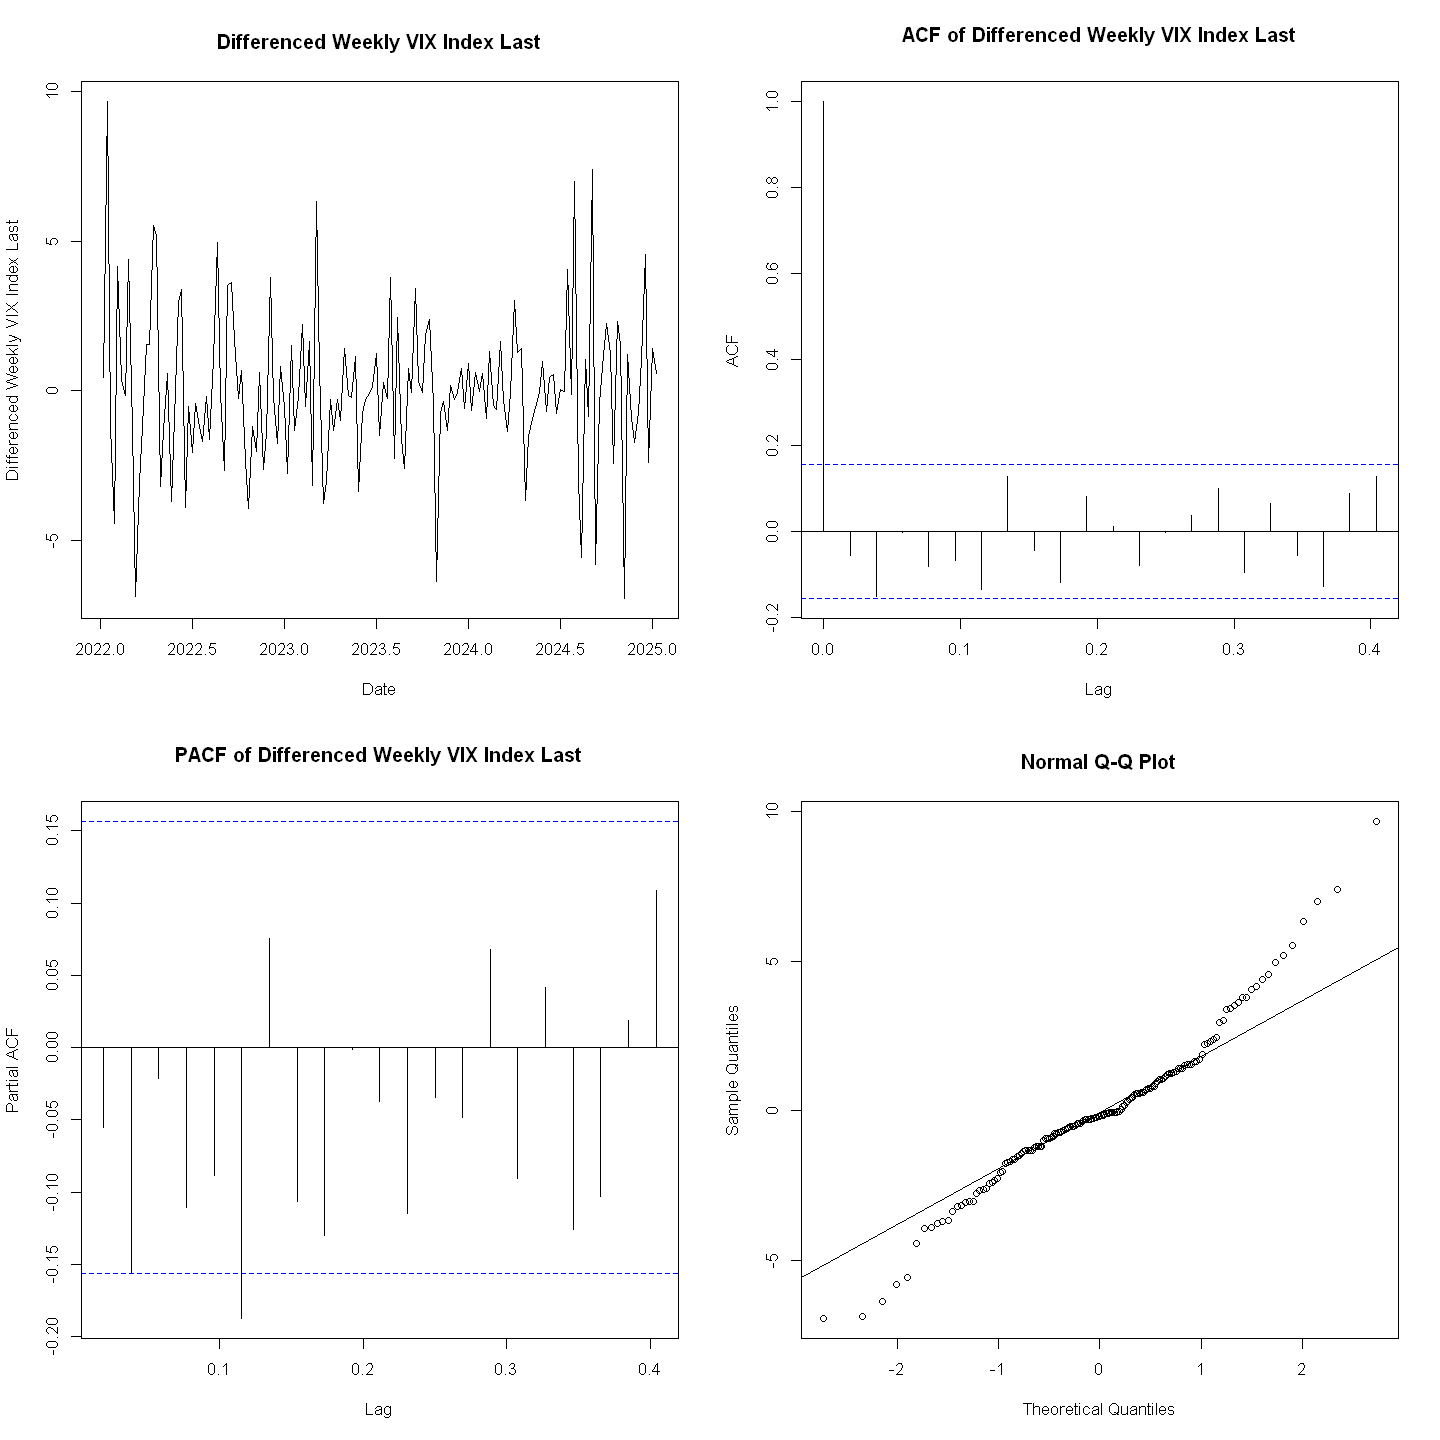

In [204]:
par(mfrow = c(2, 2))
plot(diff(vix_weekly_ts_mean), type = "l", main = "Differenced Weekly VIX Index Mean", xlab = "Date", ylab = "Differenced Weekly VIX Index Mean")
acf(diff(vix_weekly_ts_mean), main = "ACF of Differenced Weekly VIX Index Mean")
pacf(diff(vix_weekly_ts_mean), main = "PACF of Differenced Weekly VIX Index Mean")
qqnorm(diff(vix_weekly_ts_mean))
qqline(diff(vix_weekly_ts_mean))

par(mfrow = c(2, 2))
plot(diff(vix_weekly_ts_last), type = "l", main = "Differenced Weekly VIX Index Last", xlab = "Date", ylab = "Differenced Weekly VIX Index Last")
acf(diff(vix_weekly_ts_last), main = "ACF of Differenced Weekly VIX Index Last")
pacf(diff(vix_weekly_ts_last), main = "PACF of Differenced Weekly VIX Index Last")
qqnorm(diff(vix_weekly_ts_last))
qqline(diff(vix_weekly_ts_last))

adf.test(diff(vix_weekly_ts_mean))
adf.test(diff(vix_weekly_ts_last))

okay so weirdly, daily still looks stationary. Weeklys are both stationary now too. 

The diffs are not normal though. weird we may have volatility

### ARIMA

In [205]:
# divide dataset into train, validation, and test sets. 70% train, 15% validation, 15% test
n = length(vix_weekly_ts_mean)
vix_weekly_ts_mean.train = vix_weekly_ts_mean[1:(n*0.7)]
vix_weekly_ts_mean.validation = vix_weekly_ts_mean[((n*0.7)+1):(n*0.85)]
vix_weekly_ts_mean.test = vix_weekly_ts_mean[((n*0.85)+1):n]

vix_weekly_ts_last.train = vix_weekly_ts_last[1:(n*0.7)]
vix_weekly_ts_last.validation = vix_weekly_ts_last[((n*0.7)+1):(n*0.85)]
vix_weekly_ts_last.test = vix_weekly_ts_last[((n*0.85)+1):n]

vix_ts.train = vix_ts[1:(n*0.7)]
vix_ts.validation = vix_ts[((n*0.7)+1):(n*0.85)]
vix_ts.test = vix_ts[((n*0.85)+1):n]


In [206]:
# iteratively find best p and q based on AICc 
find_p_q = function(train, max_p, max_q) {
  best_aicc = Inf
  best_p = 0
  best_q = 0
  for (p in 0:max_p) {
    for (q in 0:max_q) {
        # add error handling
        tryCatch({
          model = arima(train, order = c(p, 1, q), method = "ML", include.mean = FALSE)
            }, error = function(e) {
          # ignore this one 
          cat("Error in ARIMA(", p, ", 1, ", q, "): ", e$message, "\n")
          return(NULL)
        })
        k <- p + q + 1  
        n <- length(train)  
        aicc <- model$aic + (2 * k * (k + 1)) / (n - k - 1)
      if (aicc < best_aicc) {
        best_aicc = aicc
        best_p = p
        best_q = q
      }
    }
  }
  return(list(p = best_p, q = best_q))
}

In [207]:
weekly_last = find_p_q(vix_weekly_ts_last.train, 5, 5)
weekly_mean = find_p_q(vix_weekly_ts_mean.train, 5, 5)
# daily = find_p_q(vix_ts.train, 10, 10)
cat("Weekly Last: p = ", weekly_last$p, ", q = ", weekly_last$q, "\n")

cat("Weekly Mean: p = ", weekly_mean$p, ", q = ", weekly_mean$q, "\n")

# cat("Daily: p = ", daily$p, ", q = ", daily$q, "\n")

Warning message in arima(train, order = c(p, 1, q), method = "ML", include.mean = FALSE):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in log(s2):
"NaNs produced"
Warning message in arima(train, order = c(p, 1, q), method = "ML", include.mean = FALSE):
"possible convergence problem: optim gave code = 1"


Weekly Last: p =  4 , q =  3 
Weekly Mean: p =  3 , q =  5 


In [208]:
# we found 5, 1, 4 earlier. lets do that 
vix_weekly_ts_mean.arima = arima(vix_weekly_ts_mean.train, order = c(weekly_mean$p, 1, weekly_mean$q))

vix_weekly_ts_last.arima = arima(vix_weekly_ts_last.train, order = c(weekly_last$p, 1, weekly_last$q))

vix_ts.arima = arima(vix_ts.train, order = c(5, 1, 4)) # we're forcing it here bc it keeps throwing 0s

vix_weekly_ts_mean.arima
vix_weekly_ts_last.arima
vix_ts.arima

Warning message in arima(vix_ts.train, order = c(5, 1, 4)):
"possible convergence problem: optim gave code = 1"



Call:
arima(x = vix_weekly_ts_mean.train, order = c(weekly_mean$p, 1, weekly_mean$q))

Coefficients:
         ar1      ar2     ar3     ma1     ma2      ma3      ma4      ma5
      0.0006  -0.8019  0.4285  0.0287  0.8217  -0.7087  -0.1946  -0.3661
s.e.  0.2184   0.0920  0.2162  0.2239  0.1636   0.1631   0.1026   0.1305

sigma^2 estimated as 3.939:  log likelihood = -232.65,  aic = 483.31


Call:
arima(x = vix_weekly_ts_last.train, order = c(weekly_last$p, 1, weekly_last$q))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3
      0.5633  -0.8457  0.8529  -0.2858  -0.5405  0.6353  -0.8341
s.e.  0.1094   0.0840  0.0874   0.0995   0.0721  0.0618   0.0729

sigma^2 estimated as 4.905:  log likelihood = -242.68,  aic = 501.36

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"



Call:
arima(x = vix_ts.train, order = c(5, 1, 4))

Coefficients:
         ar1     ar2     ar3    ar4      ar5      ma1      ma2      ma3     ma4
      0.5664  0.0790  0.7776  -0.47  -0.0581  -0.6076  -0.1261  -0.8406  0.5821
s.e.     NaN  0.0947     NaN    NaN   0.0873      NaN   0.0815      NaN     NaN

sigma^2 estimated as 4.368:  log likelihood = -235.83,  aic = 491.65

### **Residual analysis of Arima models**

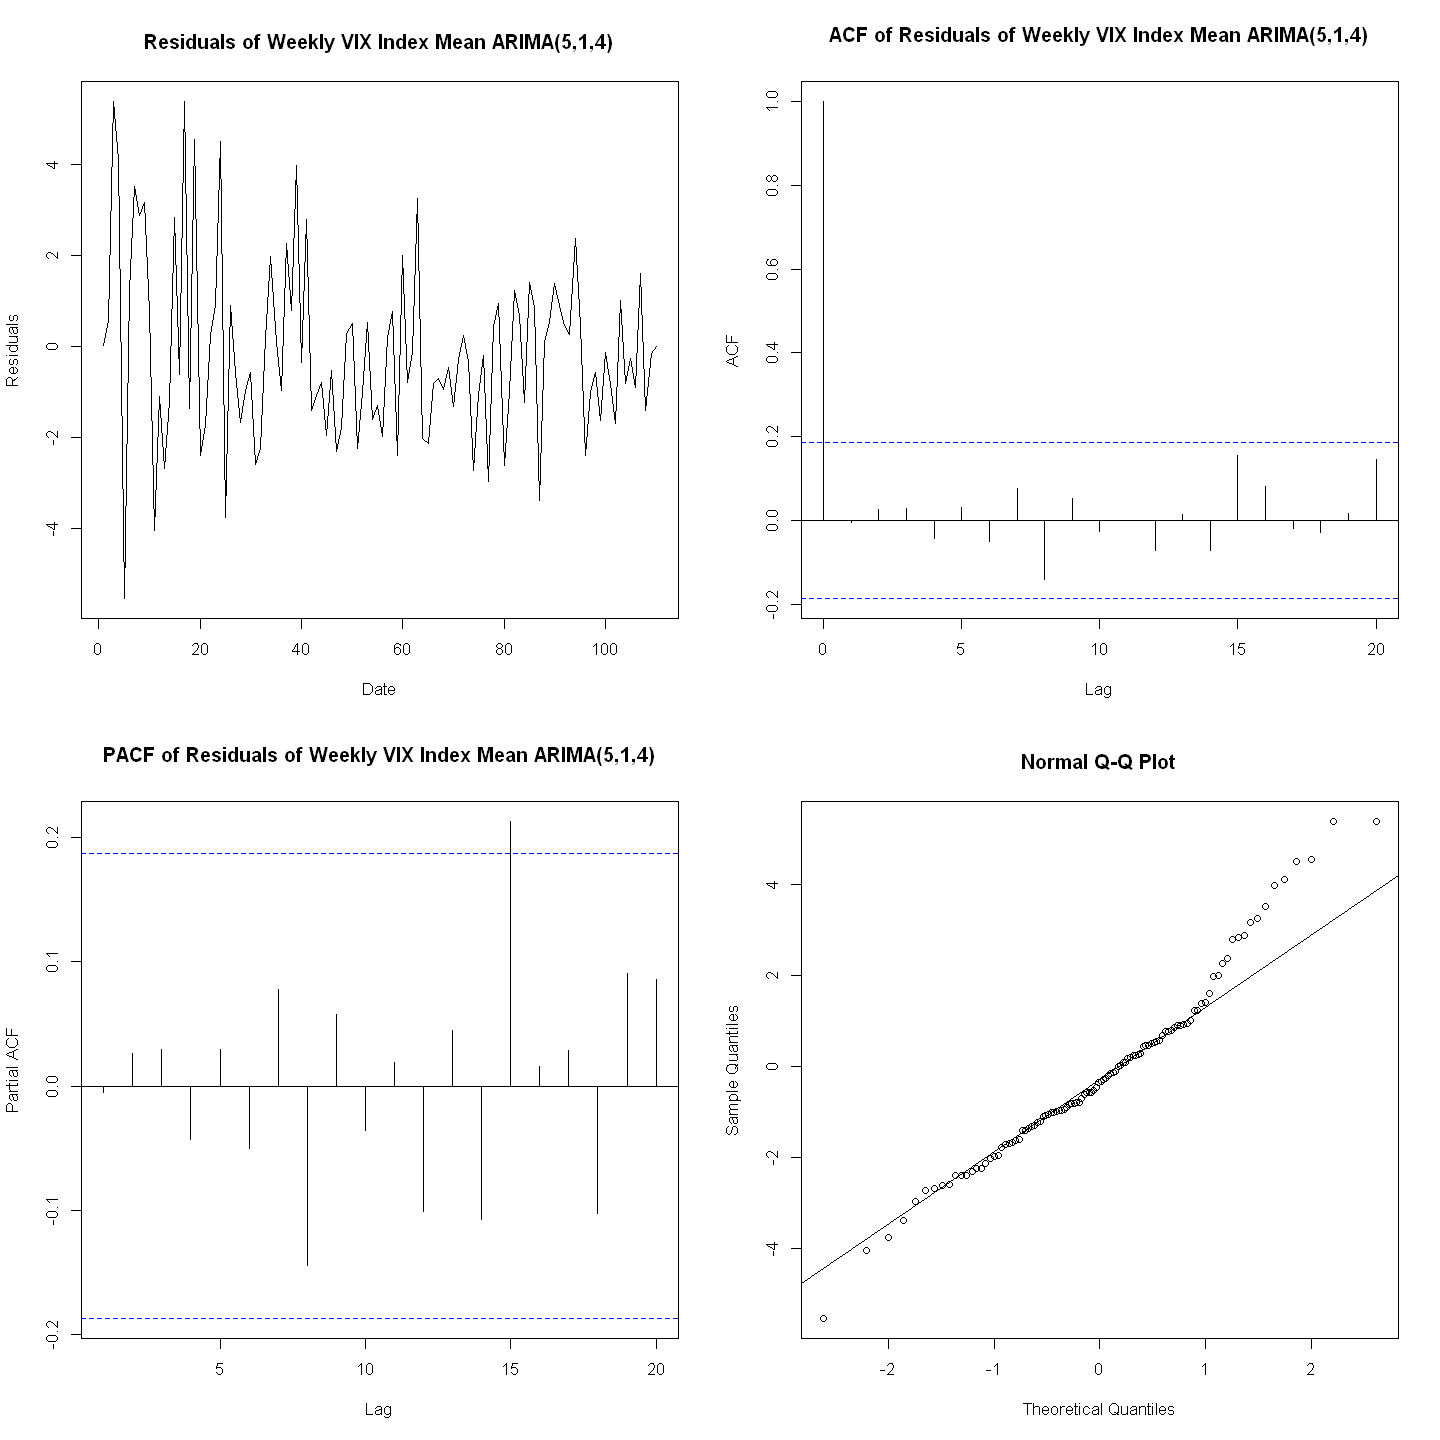

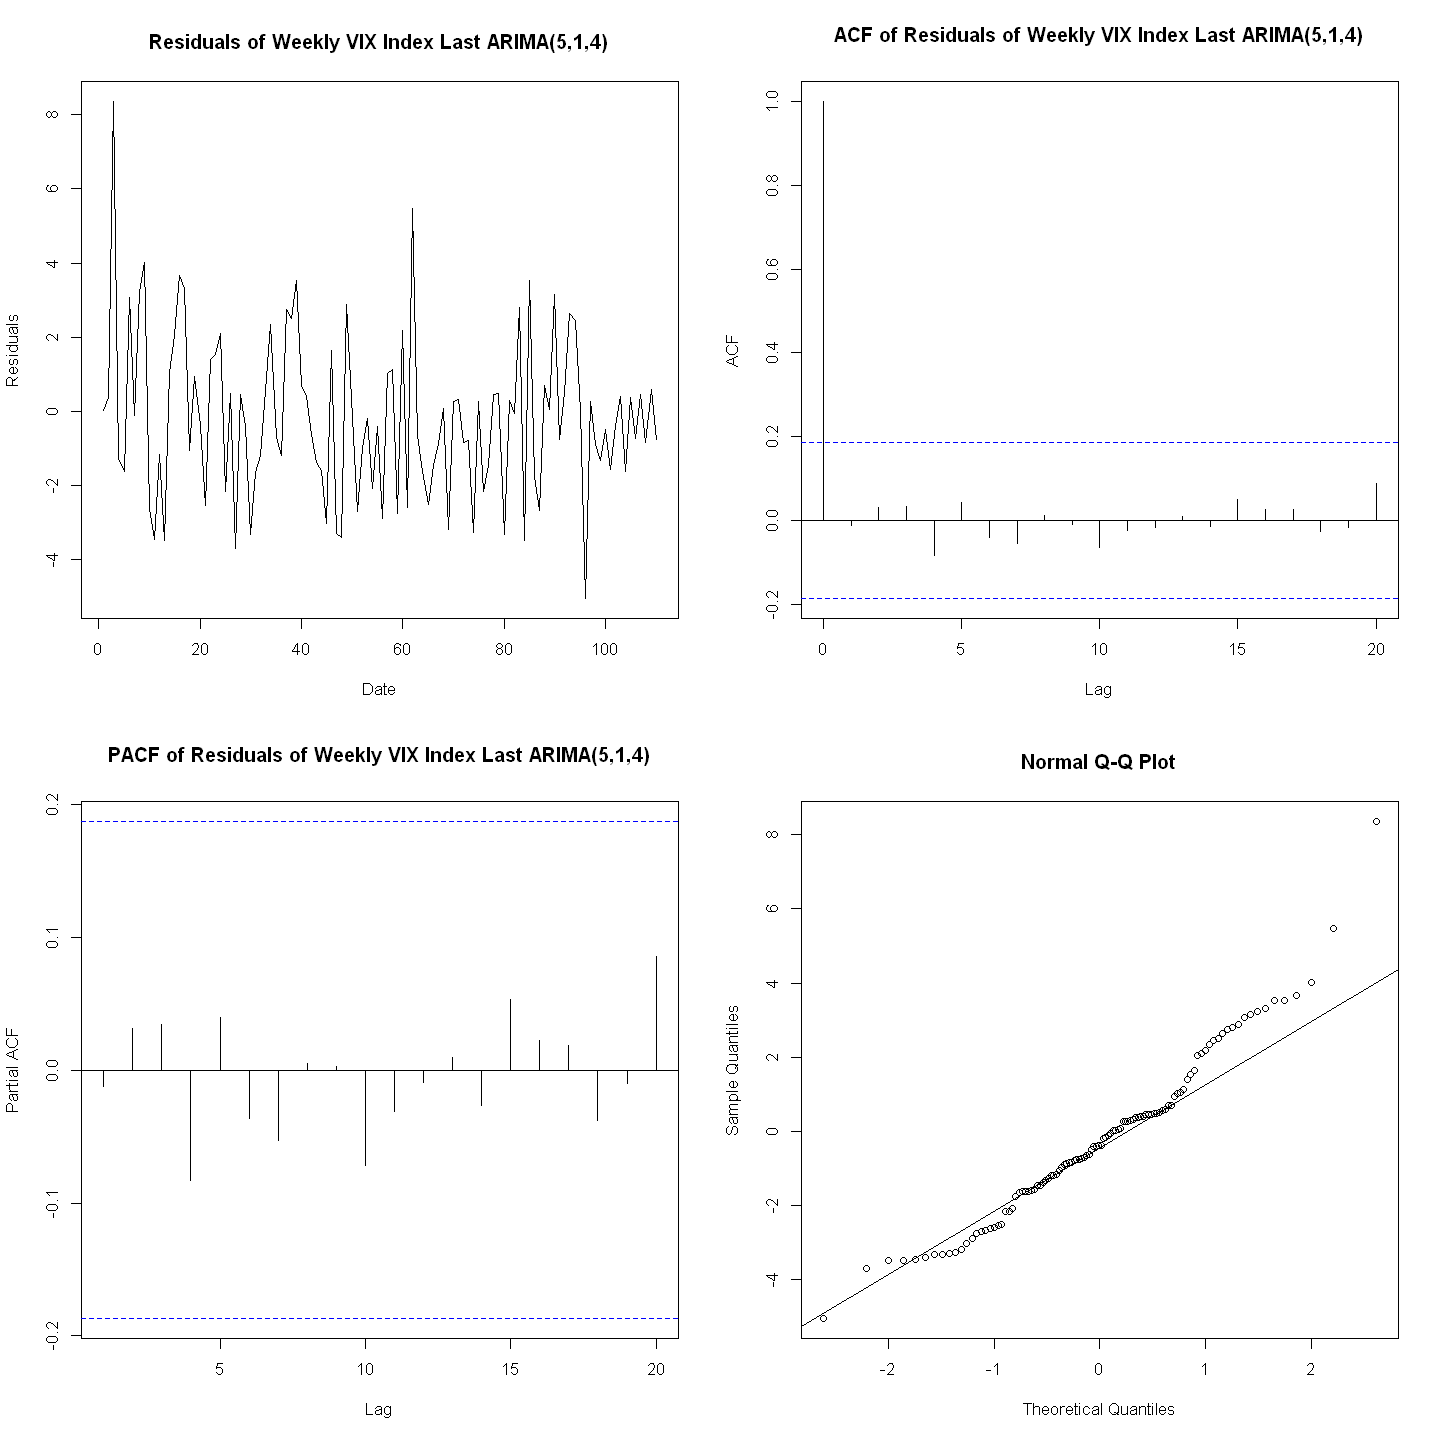

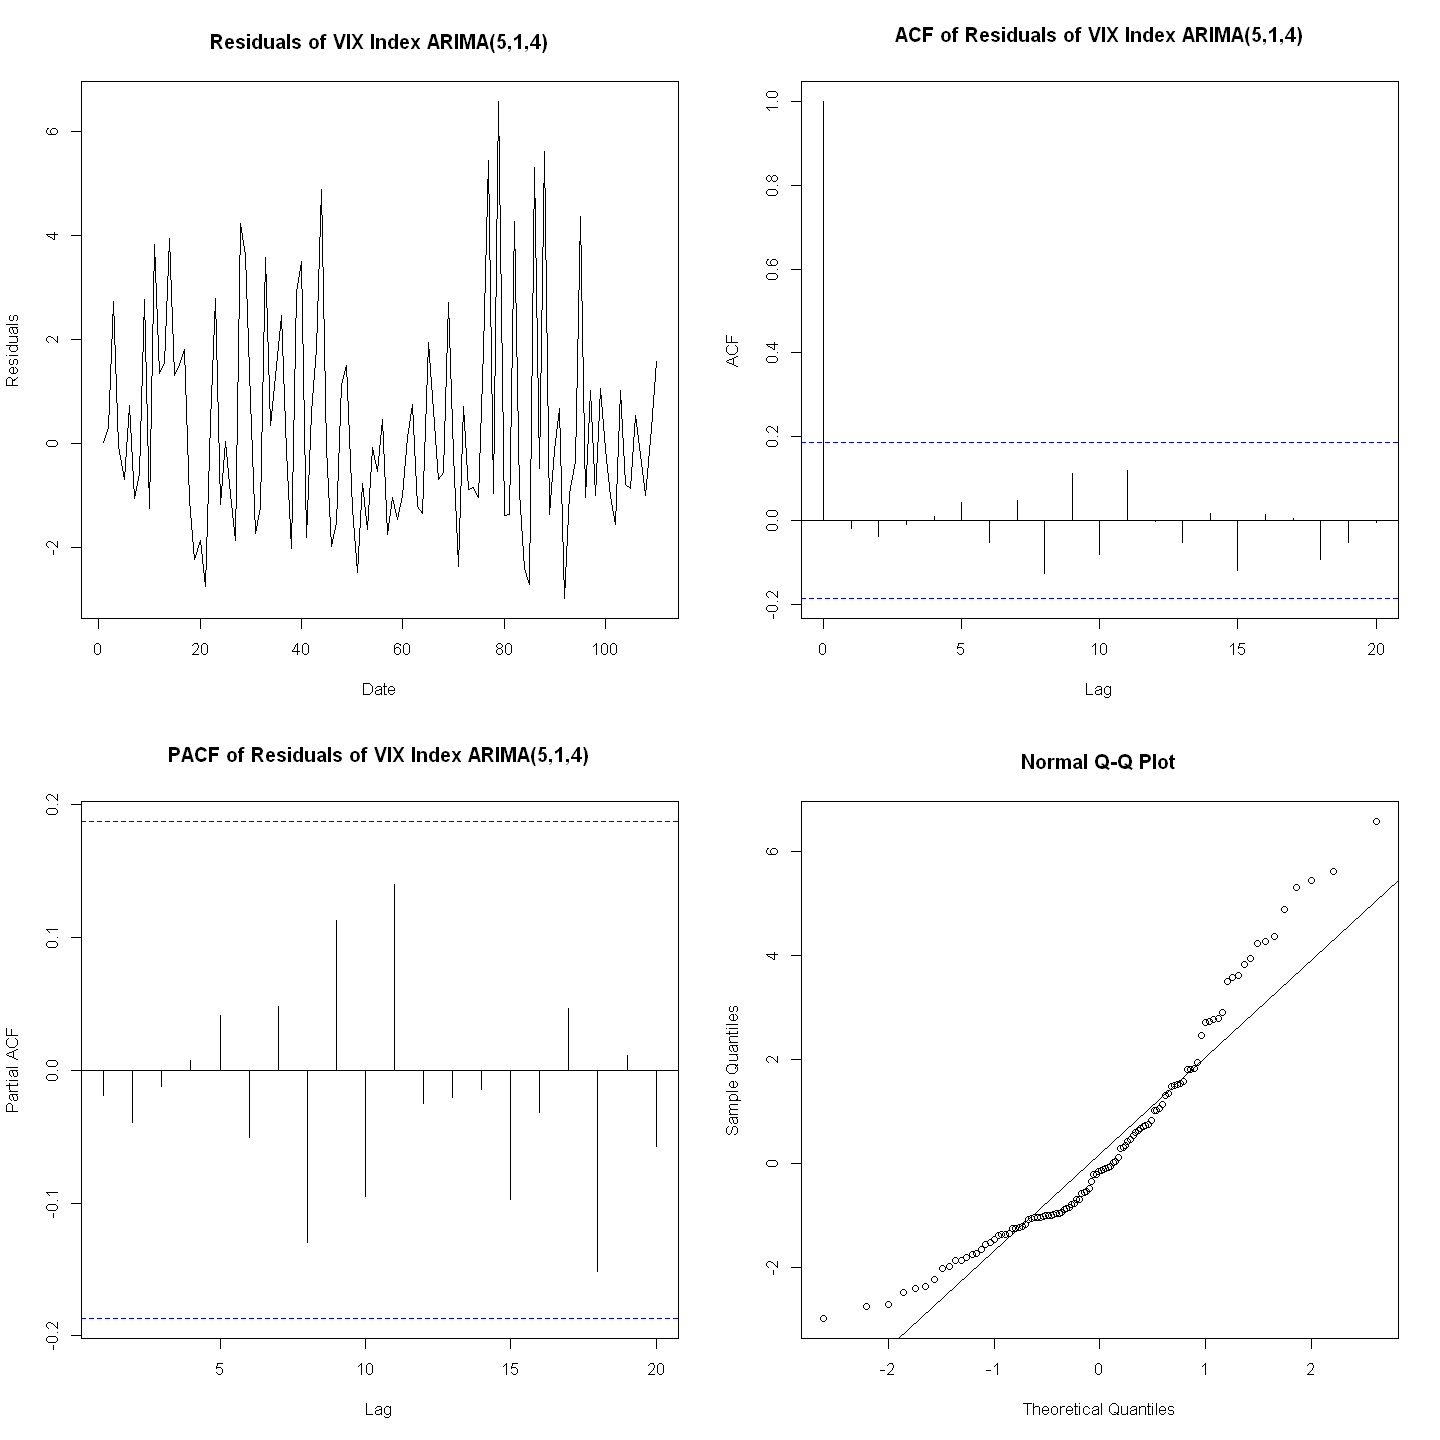

In [209]:
# lets do residual modeling 
vix_weekly_ts_mean.arima.residuals = residuals(vix_weekly_ts_mean.arima)
vix_weekly_ts_last.arima.residuals = residuals(vix_weekly_ts_last.arima)
vix_ts.arima.residuals = residuals(vix_ts.arima)

par(mfrow = c(2, 2))
plot(vix_weekly_ts_mean.arima.residuals, type = "l", main = "Residuals of Weekly VIX Index Mean ARIMA(5,1,4)", xlab = "Date", ylab = "Residuals")
acf(vix_weekly_ts_mean.arima.residuals, main = "ACF of Residuals of Weekly VIX Index Mean ARIMA(5,1,4)")
pacf(vix_weekly_ts_mean.arima.residuals, main = "PACF of Residuals of Weekly VIX Index Mean ARIMA(5,1,4)")
qqnorm(vix_weekly_ts_mean.arima.residuals)
qqline(vix_weekly_ts_mean.arima.residuals)

par(mfrow = c(2, 2))
plot(vix_weekly_ts_last.arima.residuals, type = "l", main = "Residuals of Weekly VIX Index Last ARIMA(5,1,4)", xlab = "Date", ylab = "Residuals")
acf(vix_weekly_ts_last.arima.residuals, main = "ACF of Residuals of Weekly VIX Index Last ARIMA(5,1,4)")
pacf(vix_weekly_ts_last.arima.residuals, main = "PACF of Residuals of Weekly VIX Index Last ARIMA(5,1,4)")
qqnorm(vix_weekly_ts_last.arima.residuals)
qqline(vix_weekly_ts_last.arima.residuals)

par(mfrow = c(2, 2))
plot(vix_ts.arima.residuals, type = "l", main = "Residuals of VIX Index ARIMA(5,1,4)", xlab = "Date", ylab = "Residuals")
acf(vix_ts.arima.residuals, main = "ACF of Residuals of VIX Index ARIMA(5,1,4)")
pacf(vix_ts.arima.residuals, main = "PACF of Residuals of VIX Index ARIMA(5,1,4)")
qqnorm(vix_ts.arima.residuals)
qqline(vix_ts.arima.residuals)

In [210]:
# do box test 
paste0("Box-Pierce Test")
vix_weekly_ts_mean.arima.box = Box.test(vix_weekly_ts_mean.arima.residuals, lag = (weekly_mean$p + weekly_mean$q + 1), type = "Box-Pierce", fitdf = (weekly_mean$p + weekly_mean$q))
vix_weekly_ts_last.arima.box = Box.test(vix_weekly_ts_last.arima.residuals, lag = (weekly_last$p + weekly_last$q + 1), type = "Box-Pierce", fitdf = (weekly_last$p + weekly_last$q))
vix_ts.arima.box = Box.test(vix_ts.arima.residuals, lag = (5 + 4 +1), type = "Box-Pierce", fitdf = (5 + 4))
sprintf("Weekly VIX Index Mean ARIMA(%s,1,%s) Box-Pierce Test: p-value = %f", weekly_mean$p, weekly_mean$q ,vix_weekly_ts_mean.arima.box$p.value)
sprintf("Weekly VIX Index Last ARIMA(%s,1,%s) Box-Pierce Test: p-value = %f", weekly_last$p, weekly_last$q, vix_weekly_ts_last.arima.box$p.value)
sprintf("VIX Index ARIMA(%s,1,%s) Box-Pierce Test: p-value = %f", 5, 4, vix_ts.arima.box$p.value)
paste0("------------------------------------------------------------------------------------------------------")

paste0("Ljung-Box Test")
vix_weekly_ts_mean.arima.ljung = Box.test(vix_weekly_ts_mean.arima.residuals, lag = (weekly_mean$p + weekly_mean$q + 1), type = "Ljung-Box", fitdf = (weekly_mean$p + weekly_mean$q))
vix_weekly_ts_last.arima.ljung = Box.test(vix_weekly_ts_last.arima.residuals, lag = (weekly_last$p + weekly_last$q + 1), type = "Ljung-Box", fitdf = (weekly_last$p + weekly_last$q))
vix_ts.arima.ljung = Box.test(vix_ts.arima.residuals, lag = (5 + 4 +1), type = "Ljung-Box", fitdf = (5 + 4))

sprintf("Weekly VIX Index Mean ARIMA(%s,1,%s) Ljung-Box Test: p-value = %f", weekly_mean$p, weekly_mean$q ,vix_weekly_ts_mean.arima.ljung$p.value)
sprintf("Weekly VIX Index Last ARIMA(%s,1,%s) Ljung-Box Test: p-value = %f", weekly_last$p, weekly_last$q, vix_weekly_ts_last.arima.ljung$p.value)
sprintf("VIX Index ARIMA(%s,1,%s) Ljung-Box Test: p-value = %f", 5, 4, vix_ts.arima.ljung$p.value)
paste0("------------------------------------------------------------------------------------------------------")

paste0("Squared Ljung-Box Test")
vix_weekly_ts_mean.arima.ljung2 = Box.test(vix_weekly_ts_mean.arima.residuals^2, lag = (weekly_mean$p + weekly_mean$q + 1), type = "Ljung-Box", fitdf = (weekly_mean$p + weekly_mean$q))
vix_weekly_ts_last.arima.ljung2 = Box.test(vix_weekly_ts_last.arima.residuals^2, lag = (weekly_last$p + weekly_last$q + 1), type = "Ljung-Box", fitdf = (weekly_last$p + weekly_last$q))
vix_ts.arima.ljung2 = Box.test(vix_ts.arima.residuals^2, lag = (5 + 4 +1), type = "Ljung-Box", fitdf = (5 + 4))

sprintf("Weekly VIX Index Mean ARIMA(%s,1,%s) Squared Ljung-Box Test: p-value = %f", weekly_mean$p, weekly_mean$q ,vix_weekly_ts_mean.arima.ljung2$p.value)
sprintf("Weekly VIX Index Last ARIMA(%s,1,%s) Squared Ljung-Box Test: p-value = %f", weekly_last$p, weekly_last$q, vix_weekly_ts_last.arima.ljung2$p.value)
sprintf("VIX Index ARIMA(%s,1,%s) Squared Ljung-Box Test: p-value = %f", 5, 4, vix_ts.arima.ljung2$p.value)
paste0("------------------------------------------------------------------------------------------------------")

[1] "Box-Pierce Test"

[1] "Weekly VIX Index Mean ARIMA(3,1,5) Box-Pierce Test: p-value = 0.048481"

[1] "Weekly VIX Index Last ARIMA(4,1,3) Box-Pierce Test: p-value = 0.186903"

[1] "VIX Index ARIMA(5,1,4) Box-Pierce Test: p-value = 0.027848"

[1] "------------------------------------------------------------------------------------------------------"

[1] "Ljung-Box Test"

[1] "Weekly VIX Index Mean ARIMA(3,1,5) Ljung-Box Test: p-value = 0.039394"

[1] "Weekly VIX Index Last ARIMA(4,1,3) Ljung-Box Test: p-value = 0.173407"

[1] "VIX Index ARIMA(5,1,4) Ljung-Box Test: p-value = 0.021165"

[1] "------------------------------------------------------------------------------------------------------"

[1] "Squared Ljung-Box Test"

[1] "Weekly VIX Index Mean ARIMA(3,1,5) Squared Ljung-Box Test: p-value = 0.000000"

[1] "Weekly VIX Index Last ARIMA(4,1,3) Squared Ljung-Box Test: p-value = 0.033864"

[1] "VIX Index ARIMA(5,1,4) Squared Ljung-Box Test: p-value = 0.000002"

[1] "------------------------------------------------------------------------------------------------------"

#### **Interpretation**
- Weekly Mean 
    - Box-Pierce: its borderline with autocorrelation with p = 0.048 <= 0.05
        - so yes it has autocorrelation
    - Ljung-Box Test: Residuals are not independent p = 0.039 <= 0.05
    - LJung-Box Squared Test: p-value is 0?? so <= 0.05
        - we need GARCH bc it has ARCH effects
- Weekly Last 
    - Box-Pierce: No Significant Autocorrelation with p = 0.1869 > 0.05
        - No autocorrelation
        - **Best model**
    - Ljung-Box Test: Residuals are independent p = 0.1734 > 0.05   
        - wut wut we beat it again
    - LJung-Box Squared Test: p-value is 0.0338 <= 0.05
        - we need GARCH bc it has ARCH effects
- VIX Daily 
    - Box-Pierce: its borderline with autocorrelation with p = 0.0278 <= 0.05
        - so yes it has autocorrelation
    - Ljung-Box Test: Residuals are not independent p = 0.0211 <= 0.05
    - LJung-Box Squared Test: p-value is 0?? so <= 0.05
        - we need GARCH bc it has ARCH effects                

The plots for all the models  are mostly good. We've captured the ACF and PACF pretty well. The Normality, however, is pretty bad.

With the tests we can determine that we have a lot of volatility we need to model

### **ARIMA Predictions with 95% confidence interval**

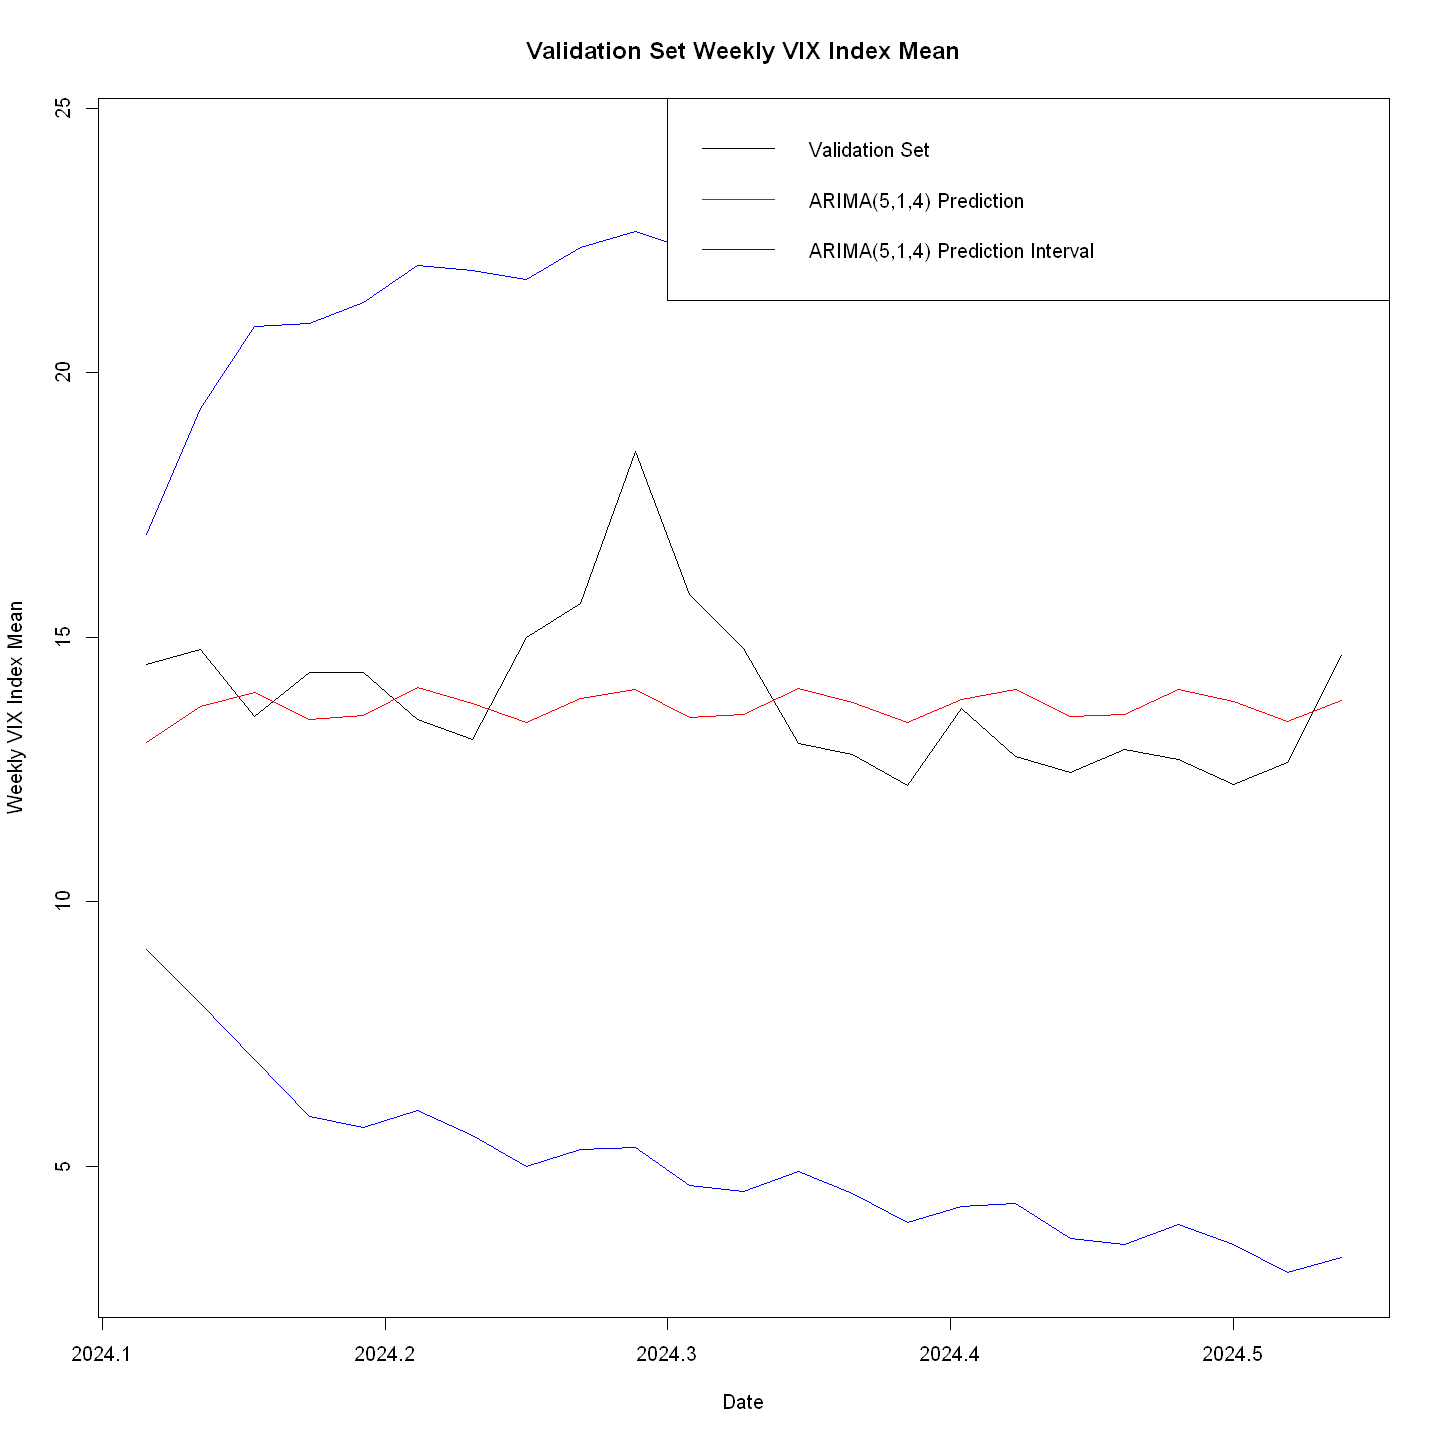

In [211]:
# lets do some predicting with the arima models on validation set 
validation_size = length(vix_weekly_ts_mean.validation)
vix_weekly_ts_mean.arima.pred = predict(vix_weekly_ts_mean.arima, n.ahead = validation_size)
vix_weekly_ts_mean.arima.ubound = vix_weekly_ts_mean.arima.pred$pred + 1.96 * vix_weekly_ts_mean.arima.pred$se
vix_weekly_ts_mean.arima.lbound = vix_weekly_ts_mean.arima.pred$pred - 1.96 * vix_weekly_ts_mean.arima.pred$se
start_valid = time(vix_weekly_ts_mean)[length(vix_weekly_ts_mean.train) + 1]
# get min of lbound and max of ubound for y lims 
ylim = c(min(vix_weekly_ts_mean.arima.lbound), max(vix_weekly_ts_mean.arima.ubound))

plot(ts(vix_weekly_ts_mean.validation, start = start_valid, frequency = 52), type = "l", main = "Validation Set Weekly VIX Index Mean", xlab = "Date", ylab = "Weekly VIX Index Mean", ylim = ylim)
lines(ts(vix_weekly_ts_mean.arima.pred$pred, start = start_valid, frequency = 52), col = "red")
lines(ts(vix_weekly_ts_mean.arima.ubound, start = start_valid, frequency = 52), col = "blue")
lines(ts(vix_weekly_ts_mean.arima.lbound, start = start_valid, frequency = 52), col = "blue")
legend("topright", legend = c("Validation Set", "ARIMA(5,1,4) Prediction", "ARIMA(5,1,4) Prediction Interval"), col = c("black", "red", "blue"), lty = 1)

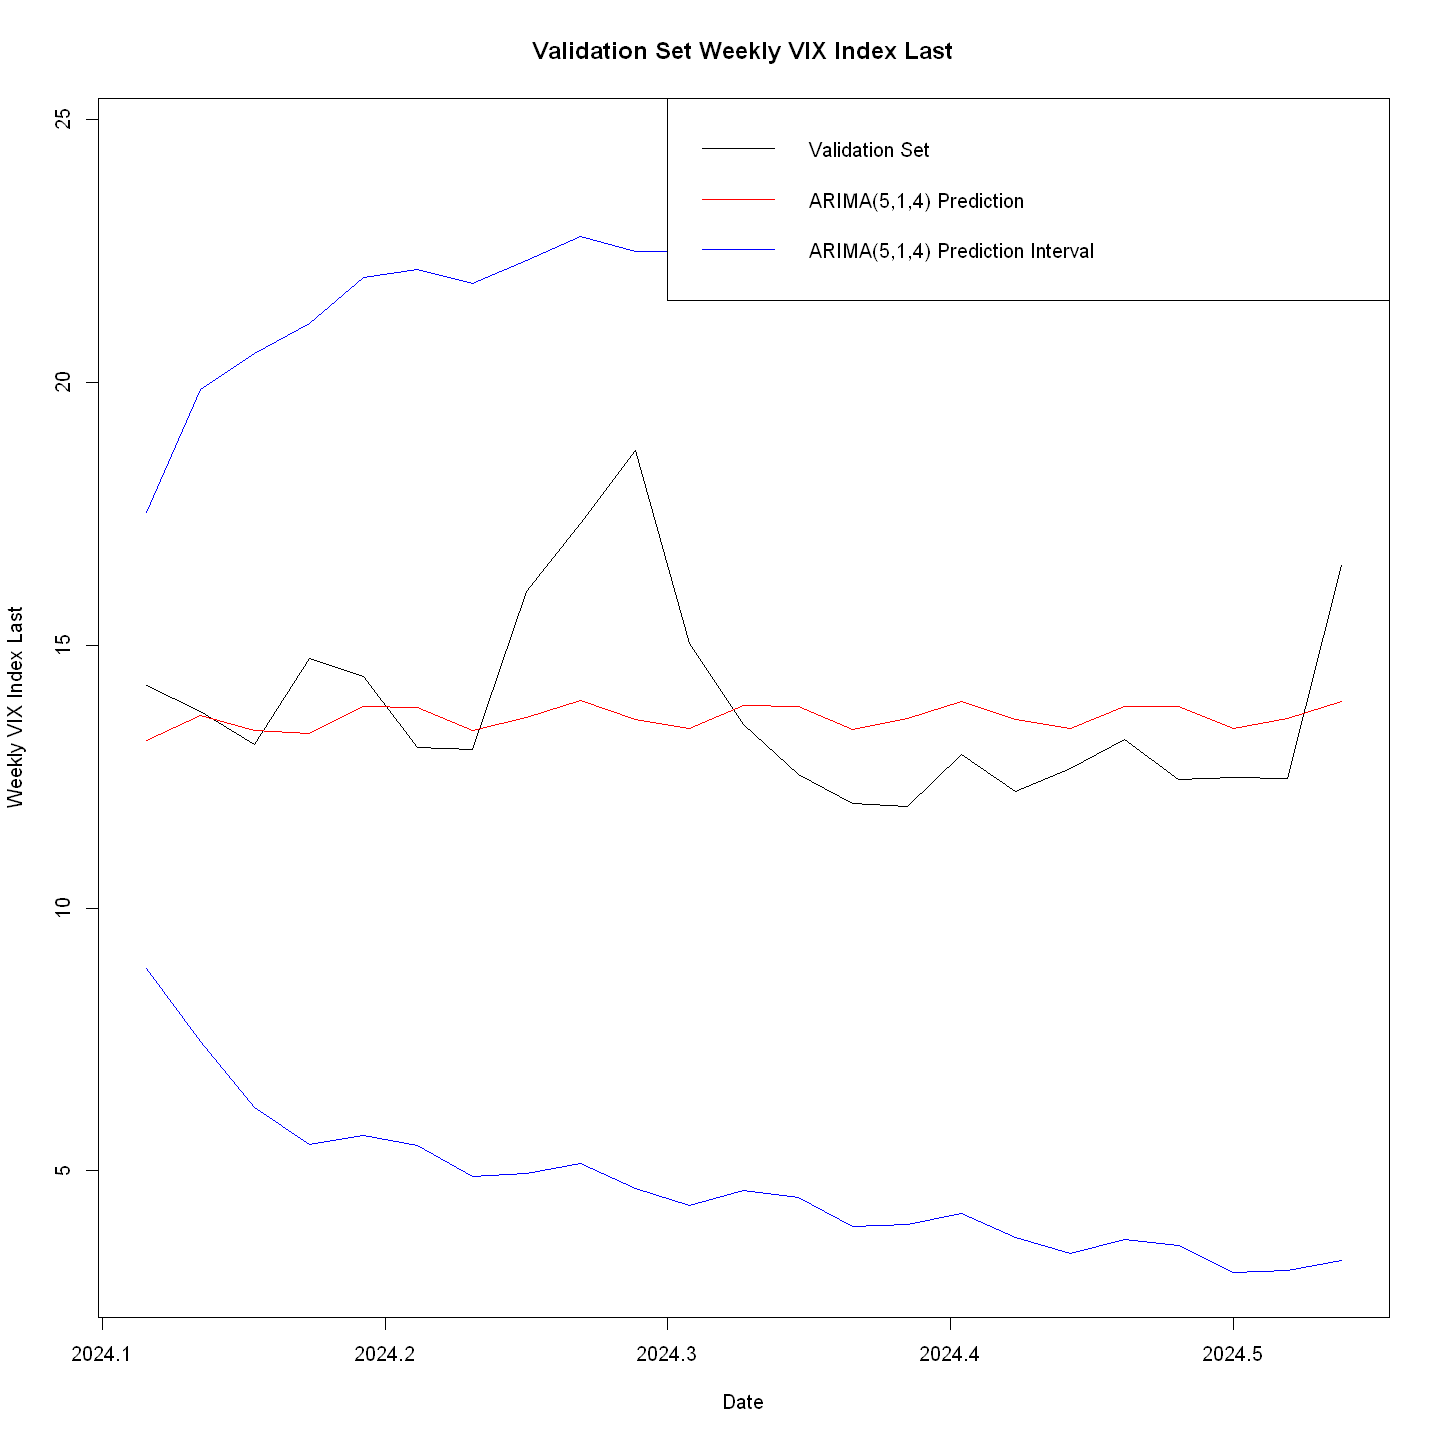

In [212]:
validation_size = length(vix_weekly_ts_last.validation)
vix_weekly_ts_last.arima.pred = predict(vix_weekly_ts_last.arima, n.ahead = validation_size)
vix_weekly_ts_last.arima.ubound = vix_weekly_ts_last.arima.pred$pred + 1.96 * vix_weekly_ts_last.arima.pred$se
vix_weekly_ts_last.arima.lbound = vix_weekly_ts_last.arima.pred$pred - 1.96 * vix_weekly_ts_last.arima.pred$se
start_valid = time(vix_weekly_ts_last)[length(vix_weekly_ts_last.train) + 1]
# get min of lbound and max of ubound for y lims
ylim = c(min(vix_weekly_ts_last.arima.lbound), max(vix_weekly_ts_last.arima.ubound))
plot(ts(vix_weekly_ts_last.validation, start = start_valid, frequency = 52), type = "l", main = "Validation Set Weekly VIX Index Last", xlab = "Date", ylab = "Weekly VIX Index Last", ylim = ylim)
lines(ts(vix_weekly_ts_last.arima.pred$pred, start = start_valid, frequency = 52), col = "red")
lines(ts(vix_weekly_ts_last.arima.ubound, start = start_valid, frequency = 52), col = "blue")
lines(ts(vix_weekly_ts_last.arima.lbound, start = start_valid, frequency = 52), col = "blue")
legend("topright", legend = c("Validation Set", "ARIMA(5,1,4) Prediction", "ARIMA(5,1,4) Prediction Interval"), col = c("black", "red", "blue"), lty = 1)

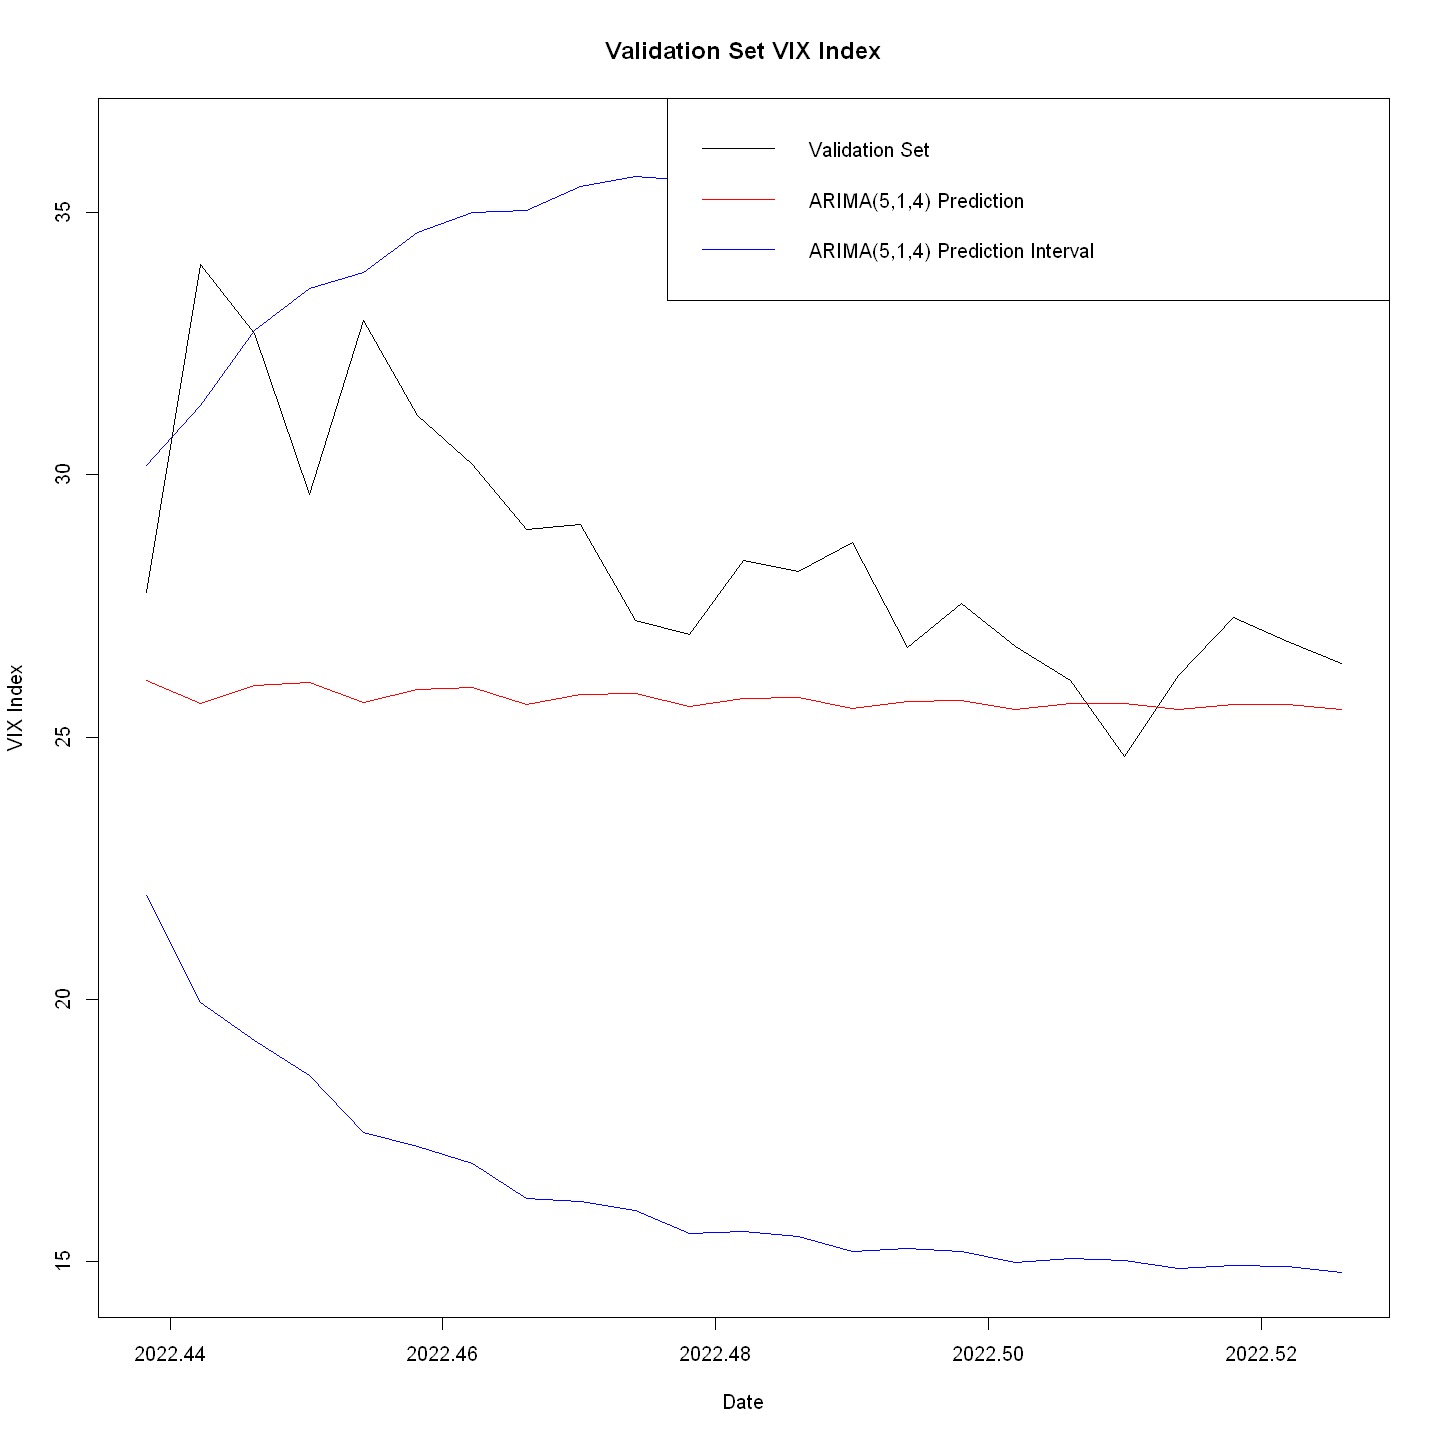

In [213]:
validation_size = length(vix_ts.validation)
vix_ts.arima.pred = predict(vix_ts.arima, n.ahead = validation_size)
vix_ts.ubound = vix_ts.arima.pred$pred + 1.96 * vix_ts.arima.pred$se
vix_ts.lbound = vix_ts.arima.pred$pred - 1.96 * vix_ts.arima.pred$se
start_valid = time(vix_ts)[length(vix_ts.train) + 1]
# get min of lbound and max of ubound for y lims
ylim = c(min(vix_ts.lbound), max(vix_ts.ubound))
plot(ts(vix_ts.validation, start = start_valid, frequency = 251), type = "l", main = "Validation Set VIX Index", xlab = "Date", ylab = "VIX Index", ylim = ylim)
lines(ts(vix_ts.arima.pred$pred, start = start_valid, frequency = 251), col = "red")
lines(ts(vix_ts.ubound, start = start_valid, frequency = 251), col = "blue")
lines(ts(vix_ts.lbound, start = start_valid, frequency = 251), col = "blue")
legend("topright", legend = c("Validation Set", "ARIMA(5,1,4) Prediction", "ARIMA(5,1,4) Prediction Interval"), col = c("black", "red", "blue"), lty = 1)

**Lets find the errors** 

In [214]:
calculate_metrics <- function(actual, predicted) {
  if (length(actual) != length(predicted)) {
    stop("Actual and predicted lengths do not match!")
  }
  
  # Mean Absolute Percentage Error (MAPE)
  mape <- mean(abs((actual - predicted) / actual)) * 100
  
  # Prediction Mean Error (PM)
  pm <- sum((predicted - actual)^2) / sum((actual - mean(actual))^2)
  
  # Root Mean Squared Error (RMSE)
  rmse <- sqrt(mean((actual - predicted)^2))
  
  # Mean Absolute Error (MAE)
  mae <- mean(abs(actual - predicted))
  
  # Print results
#   cat("MAPE:", round(mape, 5), "\n")
#   cat("PM:", round(pm, 5), "\n")
#   cat("RMSE:", round(rmse, 5), "\n")
#   cat("MAE:", round(mae, 5), "\n")
  
  # Return a list of metrics
  return(list(MAPE = mape, PM = pm, RMSE = rmse, MAE = mae))
}

# lets calculate the metrics 
vix_weekly_ts_mean.arima.metrics = calculate_metrics(vix_weekly_ts_mean.validation, vix_weekly_ts_mean.arima.pred$pred)
vix_weekly_ts_last.arima.metrics = calculate_metrics(vix_weekly_ts_last.validation, vix_weekly_ts_last.arima.pred$pred)
vix_ts.arima.metrics = calculate_metrics(vix_ts.validation, vix_ts.arima.pred$pred)

# make into a dataframe 
metrics_df = data.frame(
  Model = c("Weekly VIX Index Mean", "Weekly VIX Index Last", "VIX Index"),
  MAPE = c(vix_weekly_ts_mean.arima.metrics$MAPE, vix_weekly_ts_last.arima.metrics$MAPE, vix_ts.arima.metrics$MAPE),
  PM = c(vix_weekly_ts_mean.arima.metrics$PM, vix_weekly_ts_last.arima.metrics$PM, vix_ts.arima.metrics$PM),
  RMSE = c(vix_weekly_ts_mean.arima.metrics$RMSE, vix_weekly_ts_last.arima.metrics$RMSE, vix_ts.arima.metrics$RMSE),
  MAE = c(vix_weekly_ts_mean.arima.metrics$MAE, vix_weekly_ts_last.arima.metrics$MAE, vix_ts.arima.metrics$MAE)
)

metrics_df


Model,MAPE,PM,RMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Weekly VIX Index Mean,8.586907,1.0530087,1.489616,1.232048
Weekly VIX Index Last,9.452152,0.9920022,1.763797,1.376183
VIX Index,9.348567,2.2968729,3.550230,2.805106


- MAPE
    - prediction error
    - they're all off by  8.5% - 9.5% 
    - Weekly VIX Mean is the best one here 
- PM 
    - now we're talking about volatility/variance
    - weekly VIX Last is the best here. 
- RMSE 
    - absolute pred error 
    - overall, the worse predictions are VIX index 
    - best is Weekly VIX Index Mean 
- MAE 
    - maginitude of errors 
    - Weekly VIX mean did the best here too 

So like overall, PM is best for volatility (but tbh I think this is because we ignored the volatility of the entire week and only used the last)

overall, weekly VIX mean is the best. 

Gonna explore GARCH

# Garch

In [215]:
# perform heuristic approach
# step 1. find the best ARIMA model for the training data
# step 2. using best ARIMA model, find best GARCH model 
# step 3. using best GARCH model, find best ARIMA model AGAIN
# step 4. using best best ARIMA model, find best best GARCH model
# step 5. use infocriteria() to find the best model. if the tests are similar value, choose simpler model! 

In [216]:
garch.weekly.mean_ts = vix_weekly_ts_mean.arima.residuals
garch.weekly.last_ts = vix_weekly_ts_last.arima.residuals
garch.daily.ts = vix_ts.arima.residuals

In [217]:
best_m_n = function(ts, best_p, best_q, max_m = 2, max_n = 2) {
    # cat("Starting function \n")
    final.bic = Inf
    final.order = c(0,0)
    # cat("Starting loop \n")
    for (m in 0:max_m) for (n in 0:max_n)
    {
    # cat("in m and n: ", m, n, "\n")
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                        mean.model=list(armaOrder=c(best_p, best_q), include.mean=T), # update order!
                        distribution.model="std")    
    # cat("finished spec \n")
    fit = tryCatch({
        suppressWarnings(ugarchfit(spec, ts, solver = 'hybrid'))
    }, error = function(e) {
        # ignore this one 
        cat("Error in GARCH(", m, ",", n, "): ", e$message, "\n")
        return(NULL)
    })
    if (is.null(fit)) {
        next
    }
    # cat("finished fit \n")
    current.bic = infocriteria(fit)[2] 
    if (current.bic < final.bic) 
    {
        # cat("inside if with bic", current.bic, "\n")
        final.bic = current.bic
        final.order = c(m,n)
    }
    }
    # What is the selected order?
    # cat("Step 2 GARCH order", final.order)
    return(list(m = final.order[1], n = final.order[2], bic = final.bic))
}

In [218]:
# step 2
weekly_mean.step2 = best_m_n(garch.weekly.mean_ts, weekly_mean$p, weekly_mean$q, max_m = 3, max_n = 3)
weekly_last.step2 = best_m_n(garch.weekly.last_ts, weekly_last$p, weekly_last$q,max_m = 3, max_n = 3)
daily.step2 = best_m_n(garch.daily.ts, 5, 4,max_m = 3, max_n = 3)

sprintf("Weekly VIX Index Mean: m = %s, n = %s, BIC = %f", weekly_mean.step2$m, weekly_mean.step2$n, weekly_mean.step2$bic)
sprintf("Weekly VIX Index Last: m = %s, n = %s, BIC = %f", weekly_last.step2$m, weekly_last.step2$n, weekly_last.step2$bic)
sprintf("VIX Index: m = %s, n = %s, BIC = %f", daily.step2$m, daily.step2$n, daily.step2$bic)

Error in GARCH( 0 , 0 ):  $ operator is invalid for atomic vectors 


[1] "Weekly VIX Index Mean: m = 1, n = 0, BIC = 4.456073"

[1] "Weekly VIX Index Last: m = 1, n = 0, BIC = 4.525767"

[1] "VIX Index: m = 0, n = 1, BIC = 4.472490"

In [219]:
best_p_q_garch = function(ts, best_m, best_n, max_p = 5, max_q = 5) {
    # cat("Starting function \n")
    final.bic = Inf
    final.order = c(0,0)
    # cat("Starting loop \n")
    for (p in 0:max_p) for (q in 0:max_q)
    {
    # cat("in m and n: ", m, n, "\n")
    spec = ugarchspec(variance.model=list(garchOrder=c(best_m,best_n)),
                        mean.model=list(armaOrder=c(p, q), include.mean=T), # update order!
                        distribution.model="std")    
    # cat("finished spec \n")
    fit = tryCatch({
        suppressWarnings(ugarchfit(spec, ts, solver = 'hybrid'))
    }, error = function(e) {
        # ignore this one 
        cat("Error in GARCH(", p, ",", q, "): ", e$message, "\n")
        return(NULL)
    })
    if (is.null(fit)) {
        next
    }
    # cat("finished fit \n")
    current.bic = infocriteria(fit)[2] 
    if (current.bic < final.bic) 
    {
        # cat("inside if with bic", current.bic, "\n")
        final.bic = current.bic
        final.order = c(p,q)
    }
    }
    # What is the selected order?
    # cat("Step 2 GARCH order", final.order)
    return(list(p = final.order[1], q = final.order[2], bic = final.bic))
}

In [220]:
weekly_mean.step3 = best_p_q_garch(garch.weekly.mean_ts, weekly_mean.step2$m, weekly_mean.step2$n, max_p = 5, max_q = 5)
weekly_last.step3 = best_p_q_garch(garch.weekly.last_ts, weekly_last.step2$m, weekly_last.step2$n, max_p = 5, max_q = 5)
daily.step3 = best_p_q_garch(garch.daily.ts, daily.step2$m, daily.step2$n, max_p = 5, max_q = 5)

sprintf("Weekly VIX Index Mean: p = %s, q = %s, BIC = %f", weekly_mean.step3$p, weekly_mean.step3$q, weekly_mean.step3$bic)
sprintf("Weekly VIX Index Last: p = %s, q = %s, BIC = %f", weekly_last.step3$p, weekly_last.step3$q, weekly_last.step3$bic)
sprintf("VIX Index: p = %s, q = %s, BIC = %f", daily.step3$p, daily.step3$q, daily.step3$bic)

[1] "Weekly VIX Index Mean: p = 0, q = 0, BIC = 4.323269"

[1] "Weekly VIX Index Last: p = 2, q = 2, BIC = 4.509482"

[1] "VIX Index: p = 0, q = 0, BIC = 4.442857"

In [221]:
# step 4 is calling best_m_n again with the new p and q values
weekly_mean.step4 = best_m_n(garch.weekly.mean_ts, weekly_mean.step3$p, weekly_mean.step3$q, max_m = 3, max_n = 3)
weekly_last.step4 = best_m_n(garch.weekly.last_ts, weekly_last.step3$p, weekly_last.step3$q,max_m = 3, max_n = 3)
daily.step4 = best_m_n(garch.daily.ts, daily.step3$p, daily.step3$q,max_m = 3, max_n = 3)

sprintf("Weekly VIX Index Mean: m = %s, n = %s, BIC = %f", weekly_mean.step4$m, weekly_mean.step4$n, weekly_mean.step4$bic)
sprintf("Weekly VIX Index Last: m = %s, n = %s, BIC = %f", weekly_last.step4$m, weekly_last.step4$n, weekly_last.step4$bic)
sprintf("VIX Index: m = %s, n = %s, BIC = %f", daily.step4$m, daily.step4$n, daily.step4$bic)

Error in GARCH( 0 , 0 ):  $ operator is invalid for atomic vectors 


[1] "Weekly VIX Index Mean: m = 1, n = 1, BIC = 4.253476"

[1] "Weekly VIX Index Last: m = 0, n = 1, BIC = 4.477110"

[1] "VIX Index: m = 0, n = 0, BIC = 4.400103"

In [222]:
# okay so now we have the best ARIMA and GARCH models. lets create model1 and model2 for each time series and check the info critiera to see which has the lowest bic. we want the less complexity one 
weekly_mean.spec1 = ugarchspec(variance.model=list(garchOrder=c(weekly_mean.step2$m, weekly_mean.step2$n)),
                        mean.model=list(armaOrder=c(weekly_mean$p, weekly_mean$q), include.mean=T), # update order!
                        distribution.model="std")
weekly_mean.spec2 = ugarchspec(variance.model=list(garchOrder=c(weekly_mean.step4$m, weekly_mean.step4$n)),
                        mean.model=list(armaOrder=c(weekly_mean.step3$p, weekly_mean.step3$q), include.mean=T), # update order!
                        distribution.model="std")

weekly_last.spec1 = ugarchspec(variance.model=list(garchOrder=c(weekly_last.step2$m, weekly_last.step2$n)),
                        mean.model=list(armaOrder=c(weekly_last$p, weekly_last$q), include.mean=T), # update order!
                        distribution.model="std")
weekly_last.spec2 = ugarchspec(variance.model=list(garchOrder=c(weekly_last.step4$m, weekly_last.step4$n)),
                        mean.model=list(armaOrder=c(weekly_last.step3$p, weekly_last.step3$q), include.mean=T), # update order!
                        distribution.model="std")

daily.spec1 = ugarchspec(variance.model=list(garchOrder=c(daily.step2$m, daily.step2$n)),
                        mean.model=list(armaOrder=c(5, 4), include.mean=T), # update order!
                        distribution.model="std")
daily.spec2 = ugarchspec(variance.model=list(garchOrder=c(daily.step4$m, daily.step4$n)),
                        mean.model=list(armaOrder=c(daily.step3$p, daily.step3$q), include.mean=T), # update order!
                        distribution.model="std")


weekly_mean.fit1 = ugarchfit(weekly_mean.spec1, garch.weekly.mean_ts, solver = 'hybrid')
weekly_mean.fit2 = ugarchfit(weekly_mean.spec2, garch.weekly.mean_ts, solver = 'hybrid')

weekly_last.fit1 = ugarchfit(weekly_last.spec1, garch.weekly.last_ts, solver = 'hybrid')
weekly_last.fit2 = ugarchfit(weekly_last.spec2, garch.weekly.last_ts, solver = 'hybrid')

daily.fit1 = ugarchfit(daily.spec1, garch.daily.ts, solver = 'hybrid')
daily.fit2 = ugarchfit(daily.spec2, garch.daily.ts, solver = 'hybrid')

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"


In [223]:
# make a dataframe with model | m | n | p | q | BIC
infocriteria_df = data.frame(
  Model = c("Weekly VIX Index Mean", "Weekly VIX Index Last", "VIX Index"),
  m1 = c(weekly_mean.step2$m, weekly_last.step2$m, daily.step2$m),
  n1 = c(weekly_mean.step2$n, weekly_last.step2$n, daily.step2$n),
  p1 = c(weekly_mean$p, weekly_last$p, 5),
  q1 = c(weekly_mean$q, weekly_last$q, 4),
  complexity1 = c(weekly_mean$p + weekly_mean$q + weekly_mean.step2$m + weekly_mean.step2$n, weekly_last$p + weekly_last$q + weekly_last.step2$m + weekly_last.step2$n, 5 + 4 + daily.step2$m + daily.step2$n),
  BIC1 = c(infocriteria(weekly_mean.fit1)[2], infocriteria(weekly_last.fit1)[2], infocriteria(daily.fit1)[2]),
  m2 = c(weekly_mean.step4$m, weekly_last.step4$m, daily.step4$m),
  n2 = c(weekly_mean.step4$n, weekly_last.step4$n, daily.step4$n),
  p2 = c(weekly_mean.step3$p, weekly_last.step3$p, 5),
  q2 = c(weekly_mean.step3$q, weekly_last.step3$q, 4),
    complexity2 = c(weekly_mean.step3$p + weekly_mean.step3$q + weekly_mean.step4$m + weekly_mean.step4$n, weekly_last.step3$p + weekly_last.step3$q + weekly_last.step4$m + weekly_last.step4$n, 5 + 4 + daily.step3$p + daily.step3$q),
  BIC2 = c(infocriteria(weekly_mean.fit2)[2], infocriteria(weekly_last.fit2)[2], infocriteria(daily.fit2)[2])
)

infocriteria_df

Model,m1,n1,p1,q1,complexity1,BIC1,m2,n2,p2,q2,complexity2,BIC2
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Weekly VIX Index Mean,1,0,3,5,9,4.456073,1,1,0,0,2,4.253476
Weekly VIX Index Last,1,0,4,3,8,4.525767,0,1,2,2,5,4.477110
VIX Index,0,1,5,4,10,4.472490,0,0,5,4,9,4.400103


Okay this is weird. 
- Weekly VIX Index Mean
    - the lower BIC is the least complex one and it doesn't need Ps or Qs
        - wonder if this means we should use a GARCH only model for VIX index??????
    - does this mean we smoothed out a lot of the data with mean? 
        - no this means we only predict volatility.
            - I wonder if this is inheretly what we want?
    - do we even need this residuals anymore? may be able to capture it all with the OG dataset. 
        - lets predict with this and then try the garch only approach 


### Garch Forecasting
Rolling approach

#### Model 2 forecasting 

- Starting out with just regular train and val dataset. 
- Not using the residuals
- Only using previous model 2 (smallest model from heuristic approach)

In [248]:
validation_dates = time(vix_weekly_ts_mean)[length(vix_weekly_ts_mean.train) + 1:length(vix_weekly_ts_mean.validation)]
validation_dates = as.Date(date_decimal(validation_dates))

start_valid = validation_dates[1]
plot_garch = function(pred, lbound, ubound, validation_ts, validation_dates, start_valid, title) {
     # Define y-axis limits
     ylim = c(min(lbound, validation_ts), max(ubound, validation_ts))

     # Plot without default x-axis labels
     plot(validation_dates, validation_ts, type = "l",
          main = title, 
          xlab = "Date", ylab = "Weekly VIX Index Mean", ylim = ylim,
          xaxt = "n")  # Suppress default x-axis labels

     # Select every 2nd date for tick marks
     tick_dates = validation_dates[seq(1, length(validation_dates), by = 3)]

     # Add x-axis ticks but no labels
     axis(1, at = tick_dates, labels = FALSE)

     # Manually add rotated labels at a 45-degree angle
     text(x = tick_dates, 
          y = par("usr")[3] - 0.5,  
          labels = format(tick_dates, "%Y/%m/%d"), 
          srt = 0,  
          adj = 0.5,
          xpd = TRUE,
          cex = 1)

     points(validation_dates, pred, col = "red")
     lines(validation_dates, ubound, col = "blue", lty = 2)
     lines(validation_dates, lbound, col = "blue", lty = 2)
     legend("topright", legend = c("Validation Set", "Prediction", "Prediction Interval"), col = c("black", "red", "blue"), lty = 1)
}


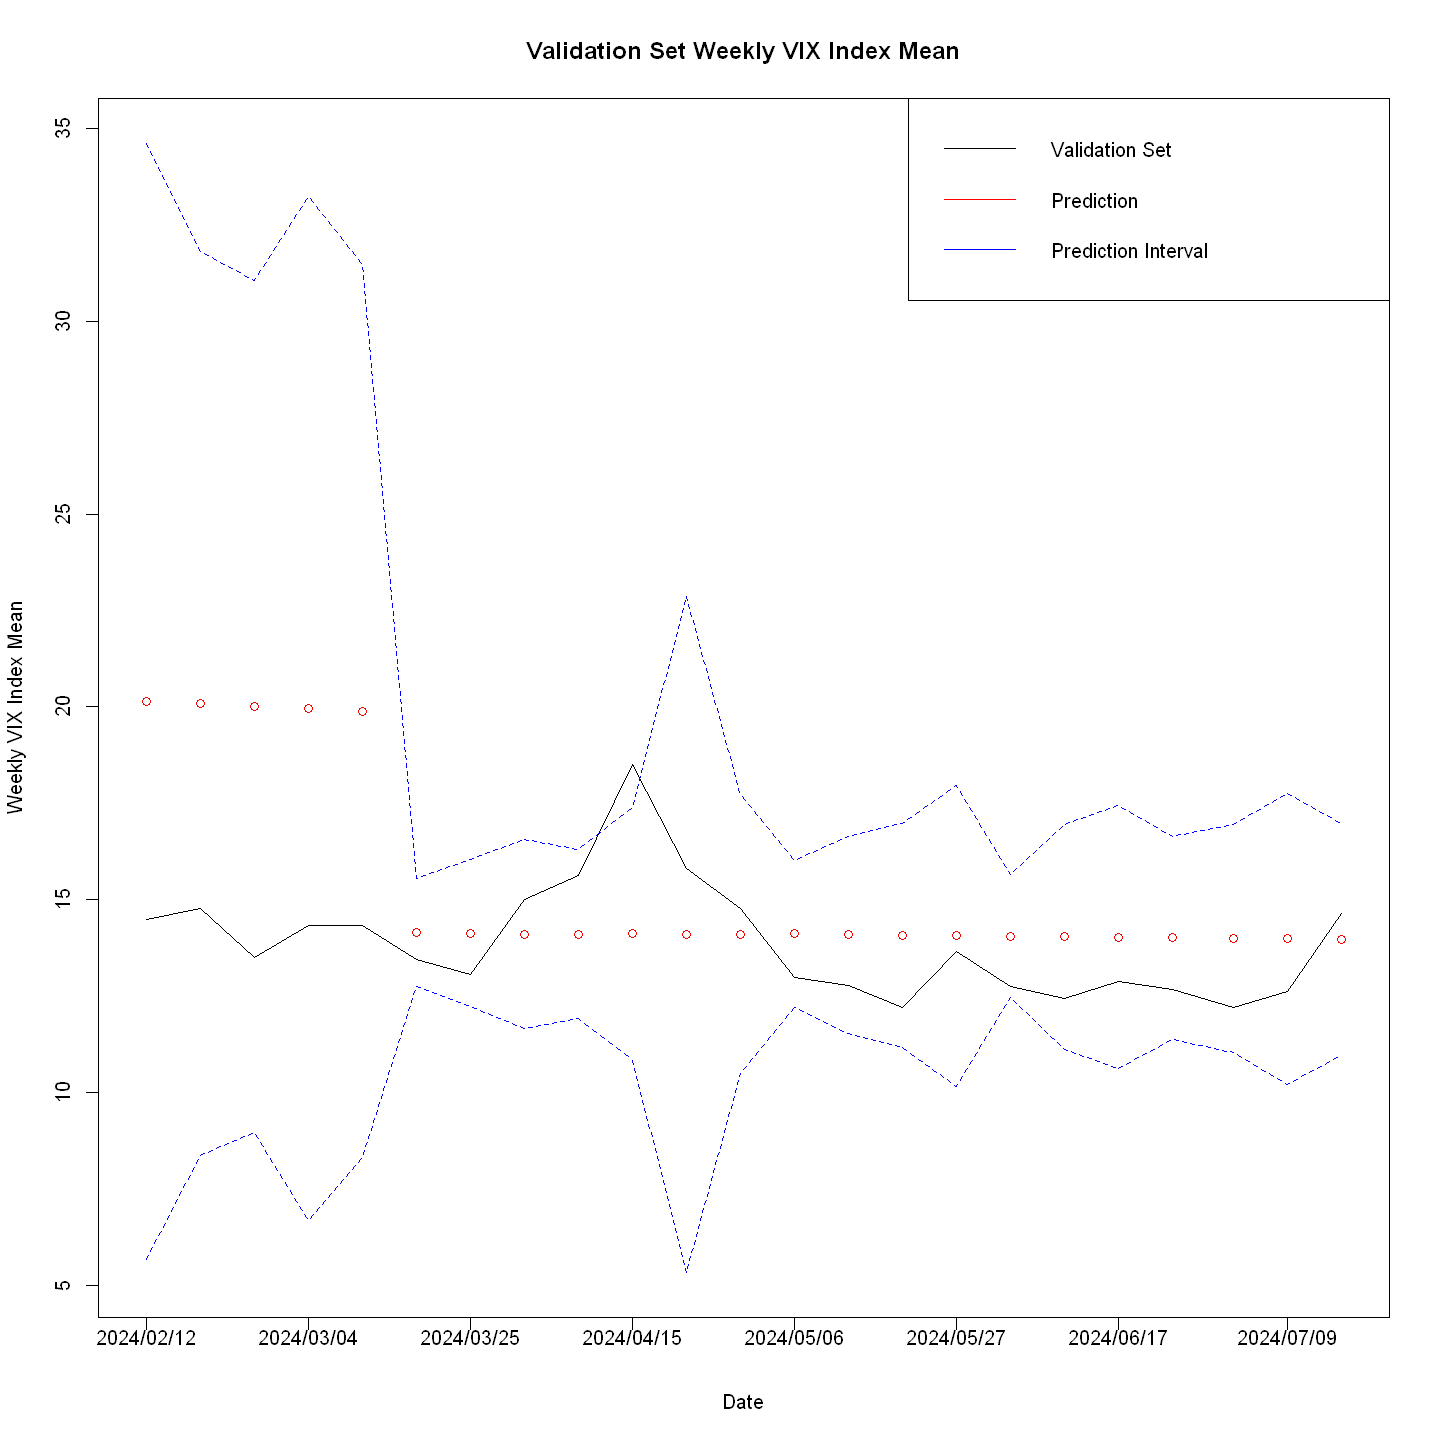

In [249]:
wnfore = length(vix_weekly_ts_mean.validation)
vix_weekly_ts_mean.fore.series.1 = NULL
vix_weekly_ts_mean.fore.sigma.1 = NULL

for(f in 1: wnfore) {
 
  #Fit models
  wdata = vix_weekly_ts_mean.train
  if(f>=2)
    # need to use the dataset you wanna predict. goal is to predict the next value in the validation set so roll it
    wdata = c(vix_weekly_ts_mean.train, vix_weekly_ts_mean.validation[1:(f-1)])  
  w.final.model.1 = ugarchfit(weekly_mean.spec2, wdata, solver = 'hybrid')
 
  #Forecast
  wfore = ugarchforecast(w.final.model.1, n.ahead=1)
  vix_weekly_ts_mean.fore.series.1 = c(vix_weekly_ts_mean.fore.series.1, wfore@forecast$seriesFor)
  vix_weekly_ts_mean.fore.sigma.1 = c(vix_weekly_ts_mean.fore.sigma.1, wfore@forecast$sigmaFor)
}

vix_weekly_ts_mean.fore.series.1[is.nan(vix_weekly_ts_mean.fore.series.1)]=0

# Calculate confidence intervals
vix_weekly_ts_mean.ubound = vix_weekly_ts_mean.fore.series.1 + 1.96 * vix_weekly_ts_mean.fore.sigma.1
vix_weekly_ts_mean.lbound = vix_weekly_ts_mean.fore.series.1 - 1.96 * vix_weekly_ts_mean.fore.sigma.1

plot_garch(vix_weekly_ts_mean.fore.series.1, vix_weekly_ts_mean.lbound, vix_weekly_ts_mean.ubound, vix_weekly_ts_mean.validation, validation_dates, start_valid, "Validation Set Weekly VIX Index Mean")

Last VIX dataset

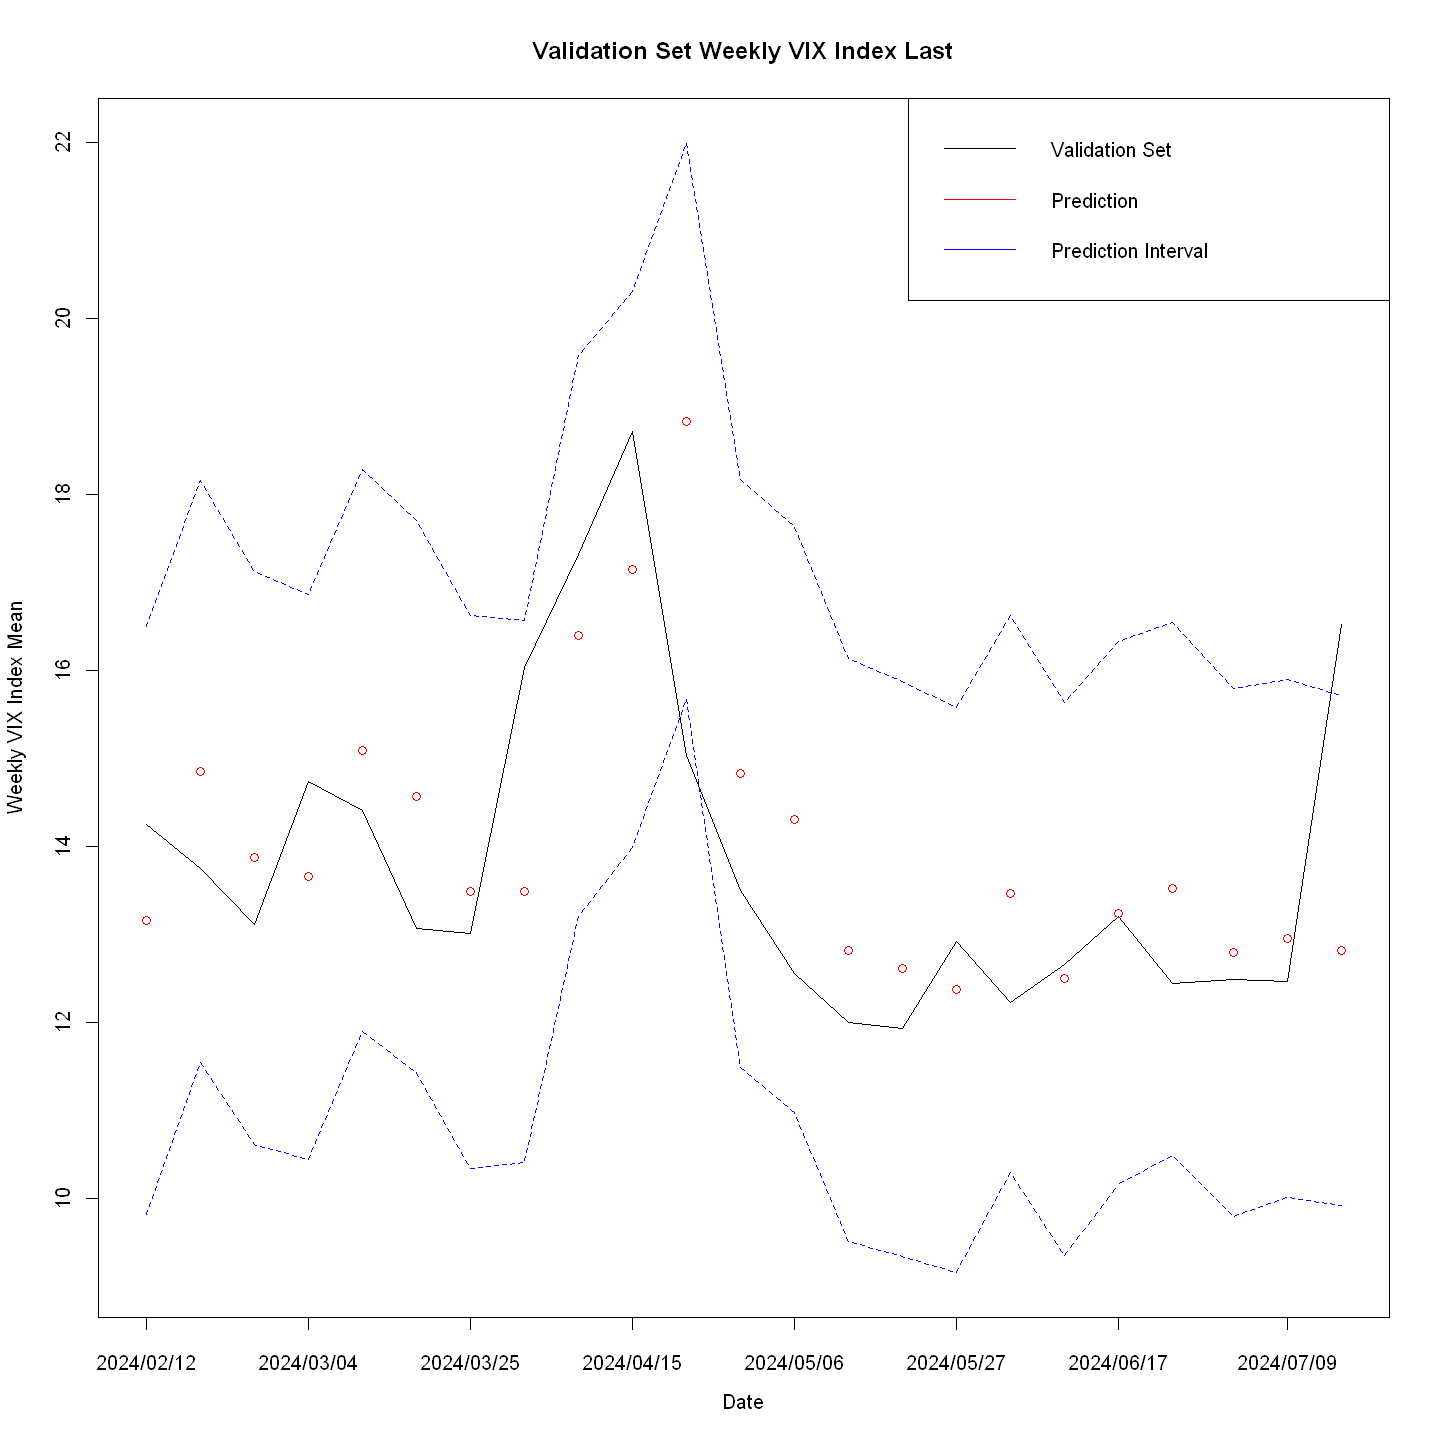

In [250]:
wnfore = length(vix_weekly_ts_last.validation)
vix_weekly_ts_last.fore.series.1 = NULL
vix_weekly_ts_last.fore.sigma.1 = NULL

for(f in 1: wnfore) {
 
  #Fit models
  wdata = vix_weekly_ts_last.train
  if(f>=2)
    # need to use the dataset you wanna predict. goal is to predict the next value in the validation set so roll it
    wdata = c(vix_weekly_ts_last.train, vix_weekly_ts_last.validation[1:(f-1)])  
  w.final.model.1 = ugarchfit(weekly_last.spec2, wdata, solver = 'hybrid')
 
  #Forecast
  wfore = ugarchforecast(w.final.model.1, n.ahead=1)
  vix_weekly_ts_last.fore.series.1 = c(vix_weekly_ts_last.fore.series.1, wfore@forecast$seriesFor)
  vix_weekly_ts_last.fore.sigma.1 = c(vix_weekly_ts_last.fore.sigma.1, wfore@forecast$sigmaFor)
}

vix_weekly_ts_last.fore.series.1[is.nan(vix_weekly_ts_last.fore.series.1)]=0

# Calculate confidence intervals
vix_weekly_ts_last.ubound = vix_weekly_ts_last.fore.series.1 + 1.96 * vix_weekly_ts_last.fore.sigma.1
vix_weekly_ts_last.lbound = vix_weekly_ts_last.fore.series.1 - 1.96 * vix_weekly_ts_last.fore.sigma.1

plot_garch(vix_weekly_ts_last.fore.series.1, vix_weekly_ts_last.lbound, vix_weekly_ts_last.ubound, vix_weekly_ts_last.validation, validation_dates, start_valid, "Validation Set Weekly VIX Index Last")

Daily dataset

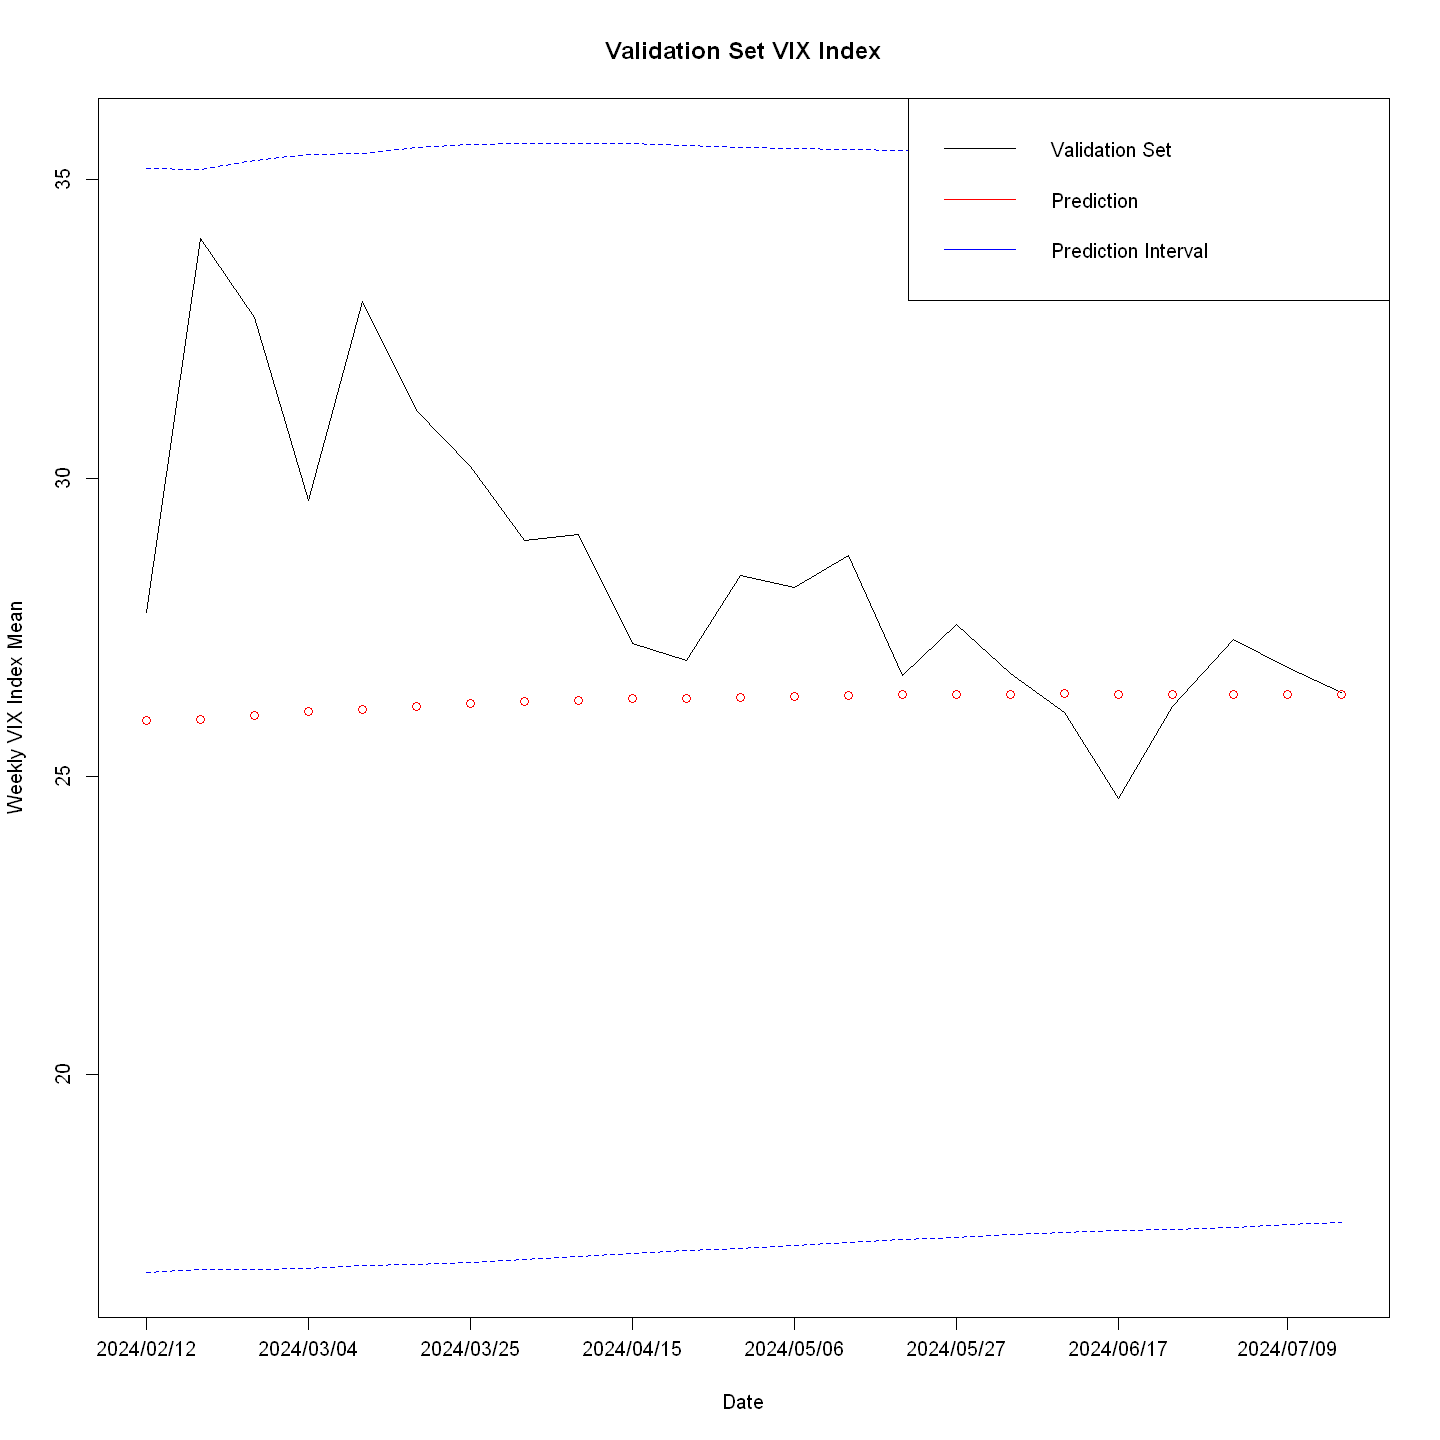

In [251]:
wnfore = length(vix_ts.validation)

vix_ts.fore.series.1 = NULL
vix_ts.fore.sigma.1 = NULL

for(f in 1: wnfore) {
 
  #Fit models
  wdata = vix_ts.train
  if(f>=2)
    # need to use the dataset you wanna predict. goal is to predict the next value in the validation set so roll it
    wdata = c(vix_ts.train, vix_ts.validation[1:(f-1)])  
  w.final.model.1 = ugarchfit(daily.spec2, wdata, solver = 'hybrid')
 
  #Forecast
  wfore = ugarchforecast(w.final.model.1, n.ahead=1)
  vix_ts.fore.series.1 = c(vix_ts.fore.series.1, wfore@forecast$seriesFor)
  vix_ts.fore.sigma.1 = c(vix_ts.fore.sigma.1, wfore@forecast$sigmaFor)
}

vix_ts.fore.series.1[is.nan(vix_ts.fore.series.1)]=0

# Calculate confidence intervals
vix_ts.ubound = vix_ts.fore.series.1 + 1.96 * vix_ts.fore.sigma.1
vix_ts.lbound = vix_ts.fore.series.1 - 1.96 * vix_ts.fore.sigma.1

plot_garch(vix_ts.fore.series.1, vix_ts.lbound, vix_ts.ubound, vix_ts.validation, validation_dates, start_valid, "Validation Set VIX Index")

In [253]:
# time to find Errors 
# lets calculate the metrics 
vix_weekly_ts_mean.garch.metrics = calculate_metrics(vix_weekly_ts_mean.validation, vix_weekly_ts_mean.fore.series.1)
vix_weekly_ts_last.garch.metrics = calculate_metrics(vix_weekly_ts_last.validation, vix_weekly_ts_last.fore.series.1)
vix_ts.garch.metrics = calculate_metrics(vix_ts.validation, vix_ts.fore.series.1)

# make into a dataframe 
garch_metrics_df = data.frame(
  Model = c("Weekly VIX Index Mean", "Weekly VIX Index Last", "VIX Index"),
  MAPE = c(vix_weekly_ts_mean.garch.metrics$MAPE, vix_weekly_ts_last.garch.metrics$MAPE, vix_ts.garch.metrics$MAPE),
  PM = c(vix_weekly_ts_mean.garch.metrics$PM, vix_weekly_ts_last.garch.metrics$PM, vix_ts.garch.metrics$PM),
  RMSE = c(vix_weekly_ts_mean.garch.metrics$RMSE, vix_weekly_ts_last.garch.metrics$RMSE, vix_ts.garch.metrics$RMSE),
  MAE = c(vix_weekly_ts_mean.garch.metrics$MAE, vix_weekly_ts_last.garch.metrics$MAE, vix_ts.garch.metrics$MAE)
)

garch_metrics_df
metrics_df


Model,MAPE,PM,RMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Weekly VIX Index Mean,16.504077,4.3803402,3.038171,2.329819
Weekly VIX Index Last,8.408811,0.7537361,1.537454,1.203564
VIX Index,7.816317,1.9591183,3.278825,2.372632


Model,MAPE,PM,RMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Weekly VIX Index Mean,8.586907,1.0530087,1.489616,1.232048
Weekly VIX Index Last,9.452152,0.9920022,1.763797,1.376183
VIX Index,9.348567,2.2968729,3.550230,2.805106


So adding GARCH made the weekly VIX Last and VIX index (daily) series **better** 
- could just focus on these two models

Adding GARCH to the mean one though made it considerably **worse**
- think we overcorrected?
- may have smoothed the data like I thought before. so GARCH just made things worse. 

#### Model 1 forecasting

**Predict using residuals**


Lets hold off on this for now. I think the model 2s are pretty good.

Can even look at VIX modeling using sentiment! thought that was SUPER neat

In [254]:
# wnfore = length(vix_weekly_ts_mean.validation)
# garch_fore.series = NULL
# garch_fore.sigma = NULL

# for(f in 1:wnfore) {
#   # Fit GARCH on rolling window
#   wdata = garch.weekly.mean_ts
#   if(f >= 2) 
#     wdata = c(garch.weekly.mean_ts, garch.weekly.mean_ts[1:(f-1)])

#   garch_model = ugarchfit(weekly_mean.spec2, wdata, solver = 'hybrid')

#   # Forecast GARCH residuals
#   garch_forecast = ugarchforecast(garch_model, n.ahead = 1)
#   garch_fore.series = c(garch_fore.series, garch_forecast@forecast$seriesFor)
#   garch_fore.sigma = c(garch_fore.sigma, garch_forecast@forecast$sigmaFor)
# }

# garch_fore.series[is.nan(garch_fore.series)] = 0

# final_forecast = vix_weekly_ts_mean.arima.pred$pred + garch_fore.series
# ylim = c(min(vix_weekly_ts_mean.arima.lbound, vix_weekly_ts_mean.validation), max(vix_weekly_ts_mean.arima.ubound, vix_weekly_ts_mean.validation))

# # plot the arima process for the mean ts 
# plot(validation_dates, vix_weekly_ts_mean.validation, type = "l", main = "Validation Set Weekly VIX Index Mean", xlab = "Date", ylab = "Weekly VIX Index Mean", ylim = ylim)
# points(validation_dates, vix_weekly_ts_mean.arima.pred$pred, col = "red")
# lines(validation_dates, vix_weekly_ts_mean.arima.ubound, col = "blue", lty = 2)
# lines(validation_dates, vix_weekly_ts_mean.arima.lbound, col = "blue", lty = 2)
# # now add garch stuff 
# points(validation_dates, vix_weekly_ts_mean.fore.series.1, col = "green", lwd = 4)

# legend("topright", legend = c("Validation Set", "ARIMA(5,1,4) Prediction", "Final Forecast", "ARIMA(5,1,4) Prediction Interval"), col = c("black", "red", "green", "blue"), lty = c(1, 1, 2, 1))

# Test modeling

In [255]:
# now add train + validation and pred using test
n = length(vix_weekly_ts_mean)
vix_weekly_ts_mean.train_new = vix_weekly_ts_mean[1:(n*0.85)]

n = length(vix_weekly_ts_last)
vix_weekly_ts_last.train_new = vix_weekly_ts_last[1:(n*0.85)]

n = length(vix_ts)
vix_ts.train_new = vix_ts[1:(n*0.85)]

In [256]:
# best ARIMA model 
weekly_mean.arima_new = arima(vix_weekly_ts_mean.train_new, order = c(weekly_mean$p, 1, weekly_mean$q))
weekly_last.arima_new = arima(vix_weekly_ts_last.train_new, order = c(weekly_last$p, 1, weekly_last$q))
vix_ts.arima_new = arima(vix_ts.train_new, order = c(5, 1, 4))

# best GARCH model
weekly_mean.garch_new = ugarchfit(weekly_mean.spec2, garch.weekly.mean_ts, solver = 'hybrid')
weekly_last.garch_new = ugarchfit(weekly_last.spec2, garch.weekly.last_ts, solver = 'hybrid')
vix_ts.garch_new = ugarchfit(daily.spec2, garch.daily.ts, solver = 'hybrid')

In [295]:
# Lets predict the arima model 
n = length(vix_weekly_ts_mean.test)

vix_weekly_ts_mean.arima.pred_new = predict(weekly_mean.arima_new, n.ahead = n)
vix_weekly_ts_mean.arima.ubound_new = vix_weekly_ts_mean.arima.pred_new$pred + 1.96 * vix_weekly_ts_mean.arima.pred_new$se
vix_weekly_ts_mean.arima.lbound_new = vix_weekly_ts_mean.arima.pred_new$pred - 1.96 * vix_weekly_ts_mean.arima.pred_new$se

validation_dates_new = time(vix_weekly_ts_mean)[length(vix_weekly_ts_mean.train_new) + 1: length(vix_weekly_ts_mean.test)]
validation_dates_new = as.Date(date_decimal(validation_dates_new))

start_valid_new = validation_dates_new[1]


# lets predict garch 
wnfore = length(vix_weekly_ts_mean.test)
vix_weekly_ts_mean.fore.series_new = NULL
vix_weekly_ts_mean.fore.sigma_new = NULL

for(f in 1: wnfore) {
 
  #Fit models
  wdata = vix_weekly_ts_mean.train_new
  if(f>=2)
    # need to use the dataset you wanna predict. goal is to predict the next value in the validation set so roll it
    wdata = c(vix_weekly_ts_mean.train_new, vix_weekly_ts_mean.test[1:(f-1)])  
  w.final.model.1 = ugarchfit(weekly_mean.spec2, wdata, solver = 'hybrid')
 
  #Forecast
  wfore = ugarchforecast(w.final.model.1, n.ahead=1)
  vix_weekly_ts_mean.fore.series_new = c(vix_weekly_ts_mean.fore.series_new, wfore@forecast$seriesFor)
  vix_weekly_ts_mean.fore.sigma_new = c(vix_weekly_ts_mean.fore.sigma_new, wfore@forecast$sigmaFor)
}

vix_weekly_ts_mean.fore.series_new[is.nan(vix_weekly_ts_mean.fore.series_new)]=0

# Calculate confidence intervals
vix_weekly_ts_mean.ubound_new = vix_weekly_ts_mean.fore.series_new + 1.96 * vix_weekly_ts_mean.fore.sigma_new
vix_weekly_ts_mean.lbound_new = vix_weekly_ts_mean.fore.series_new - 1.96 * vix_weekly_ts_mean.fore.sigma_new

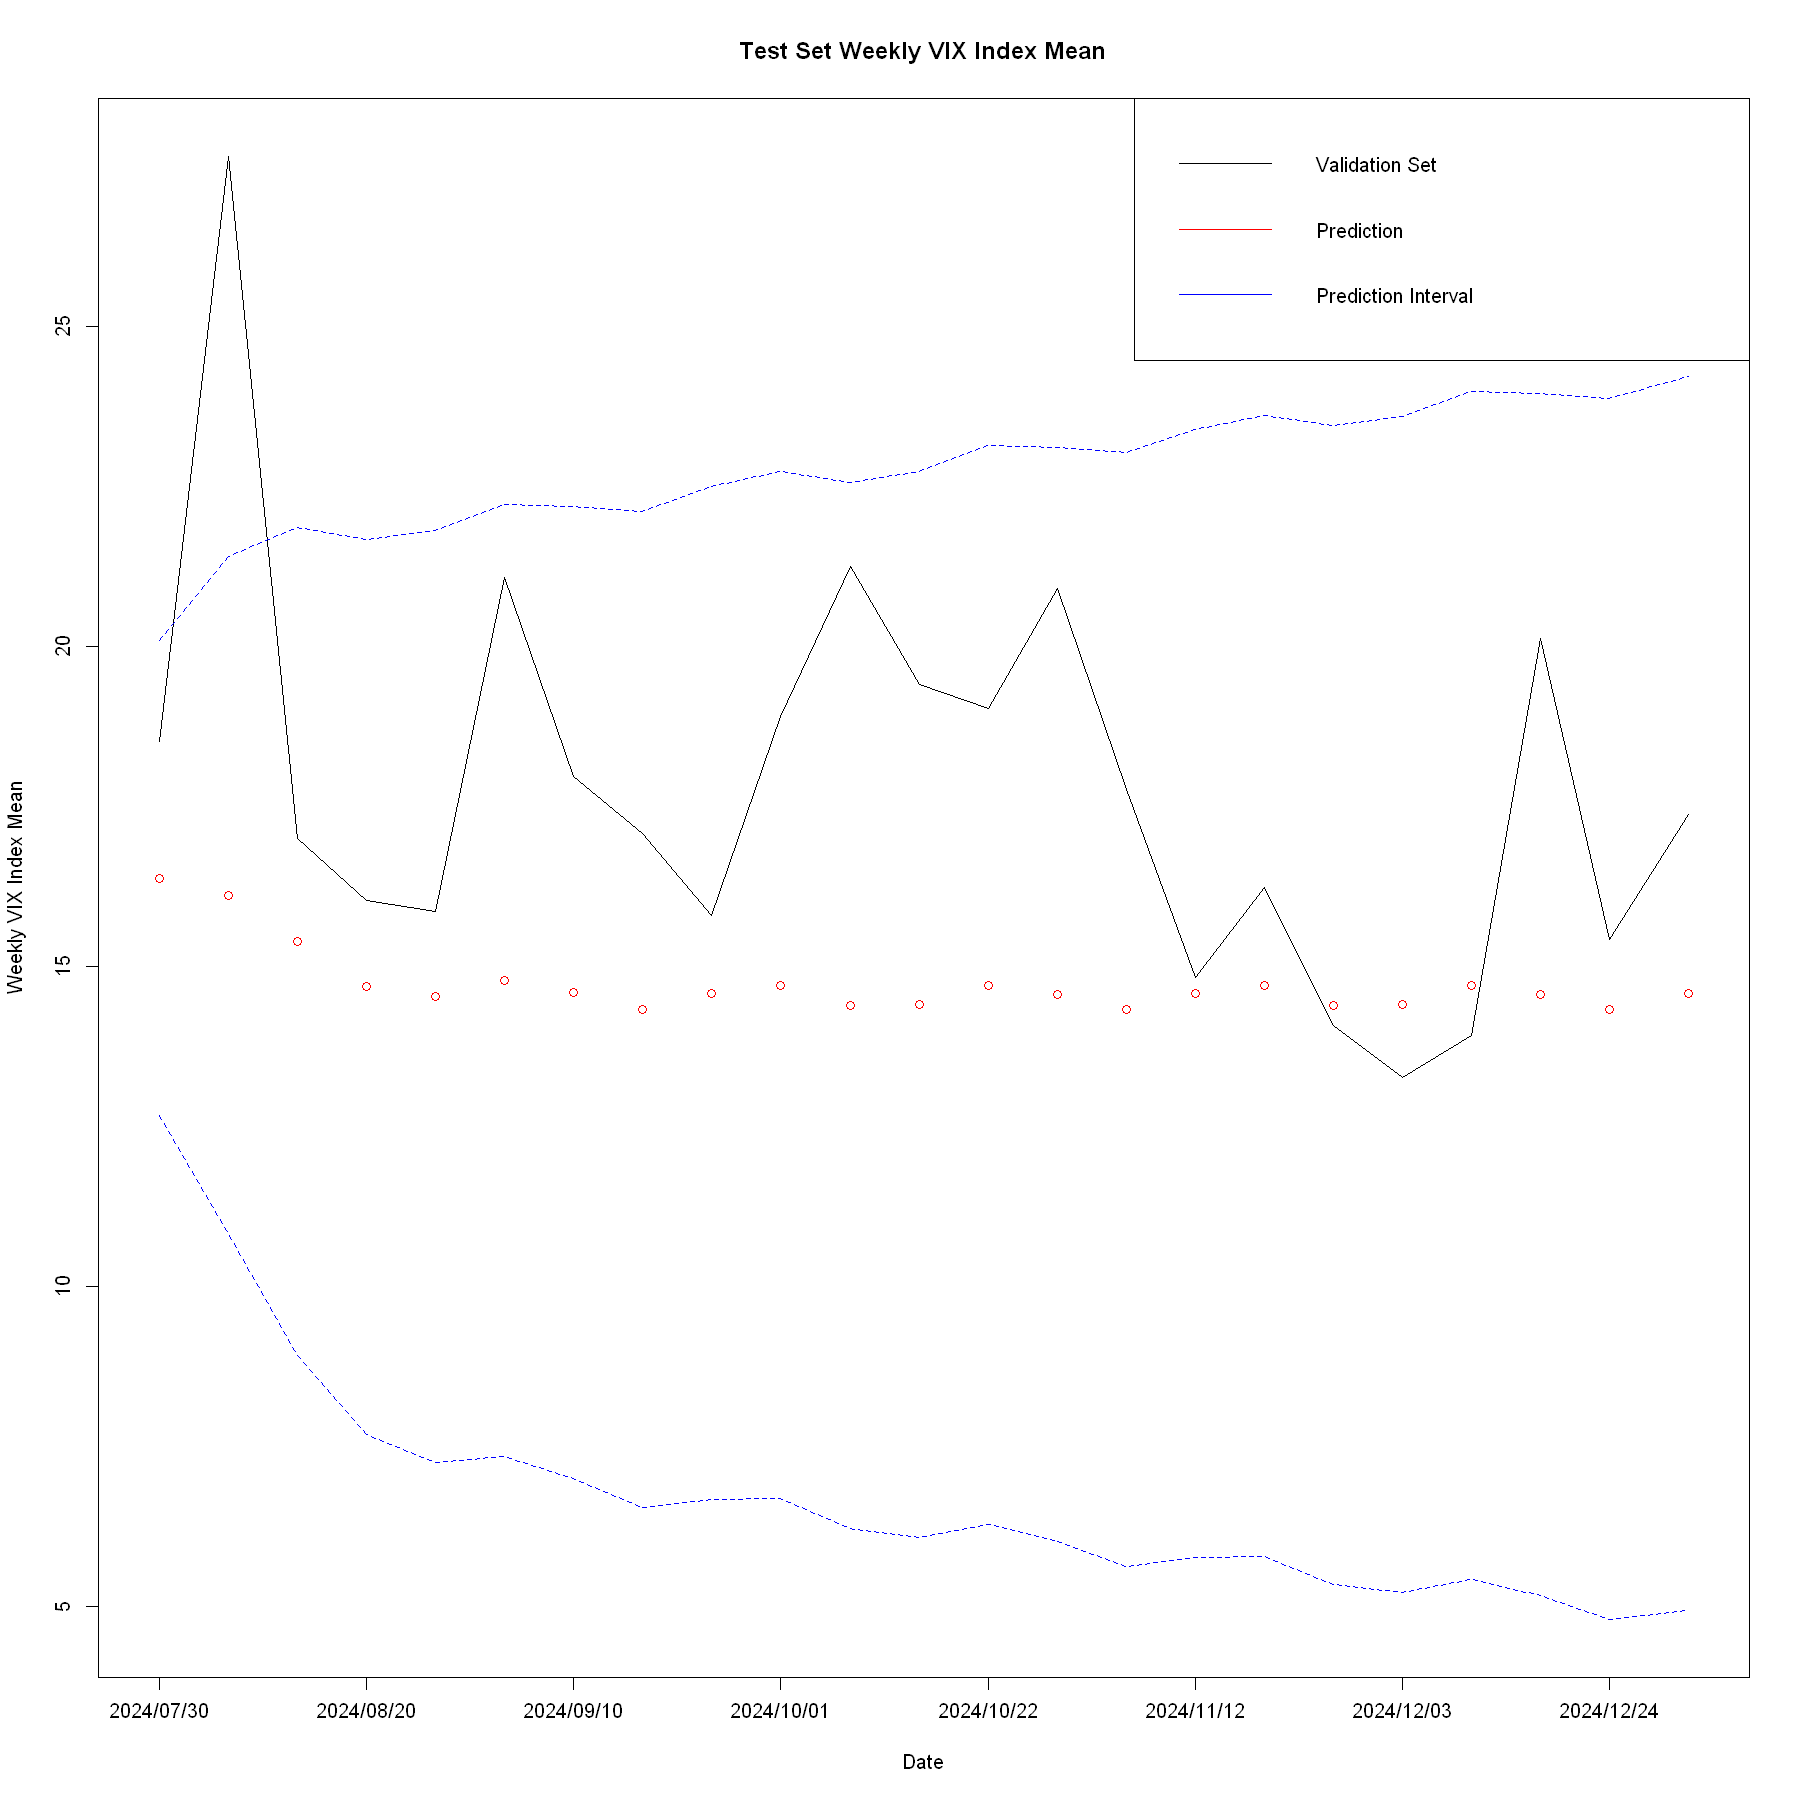

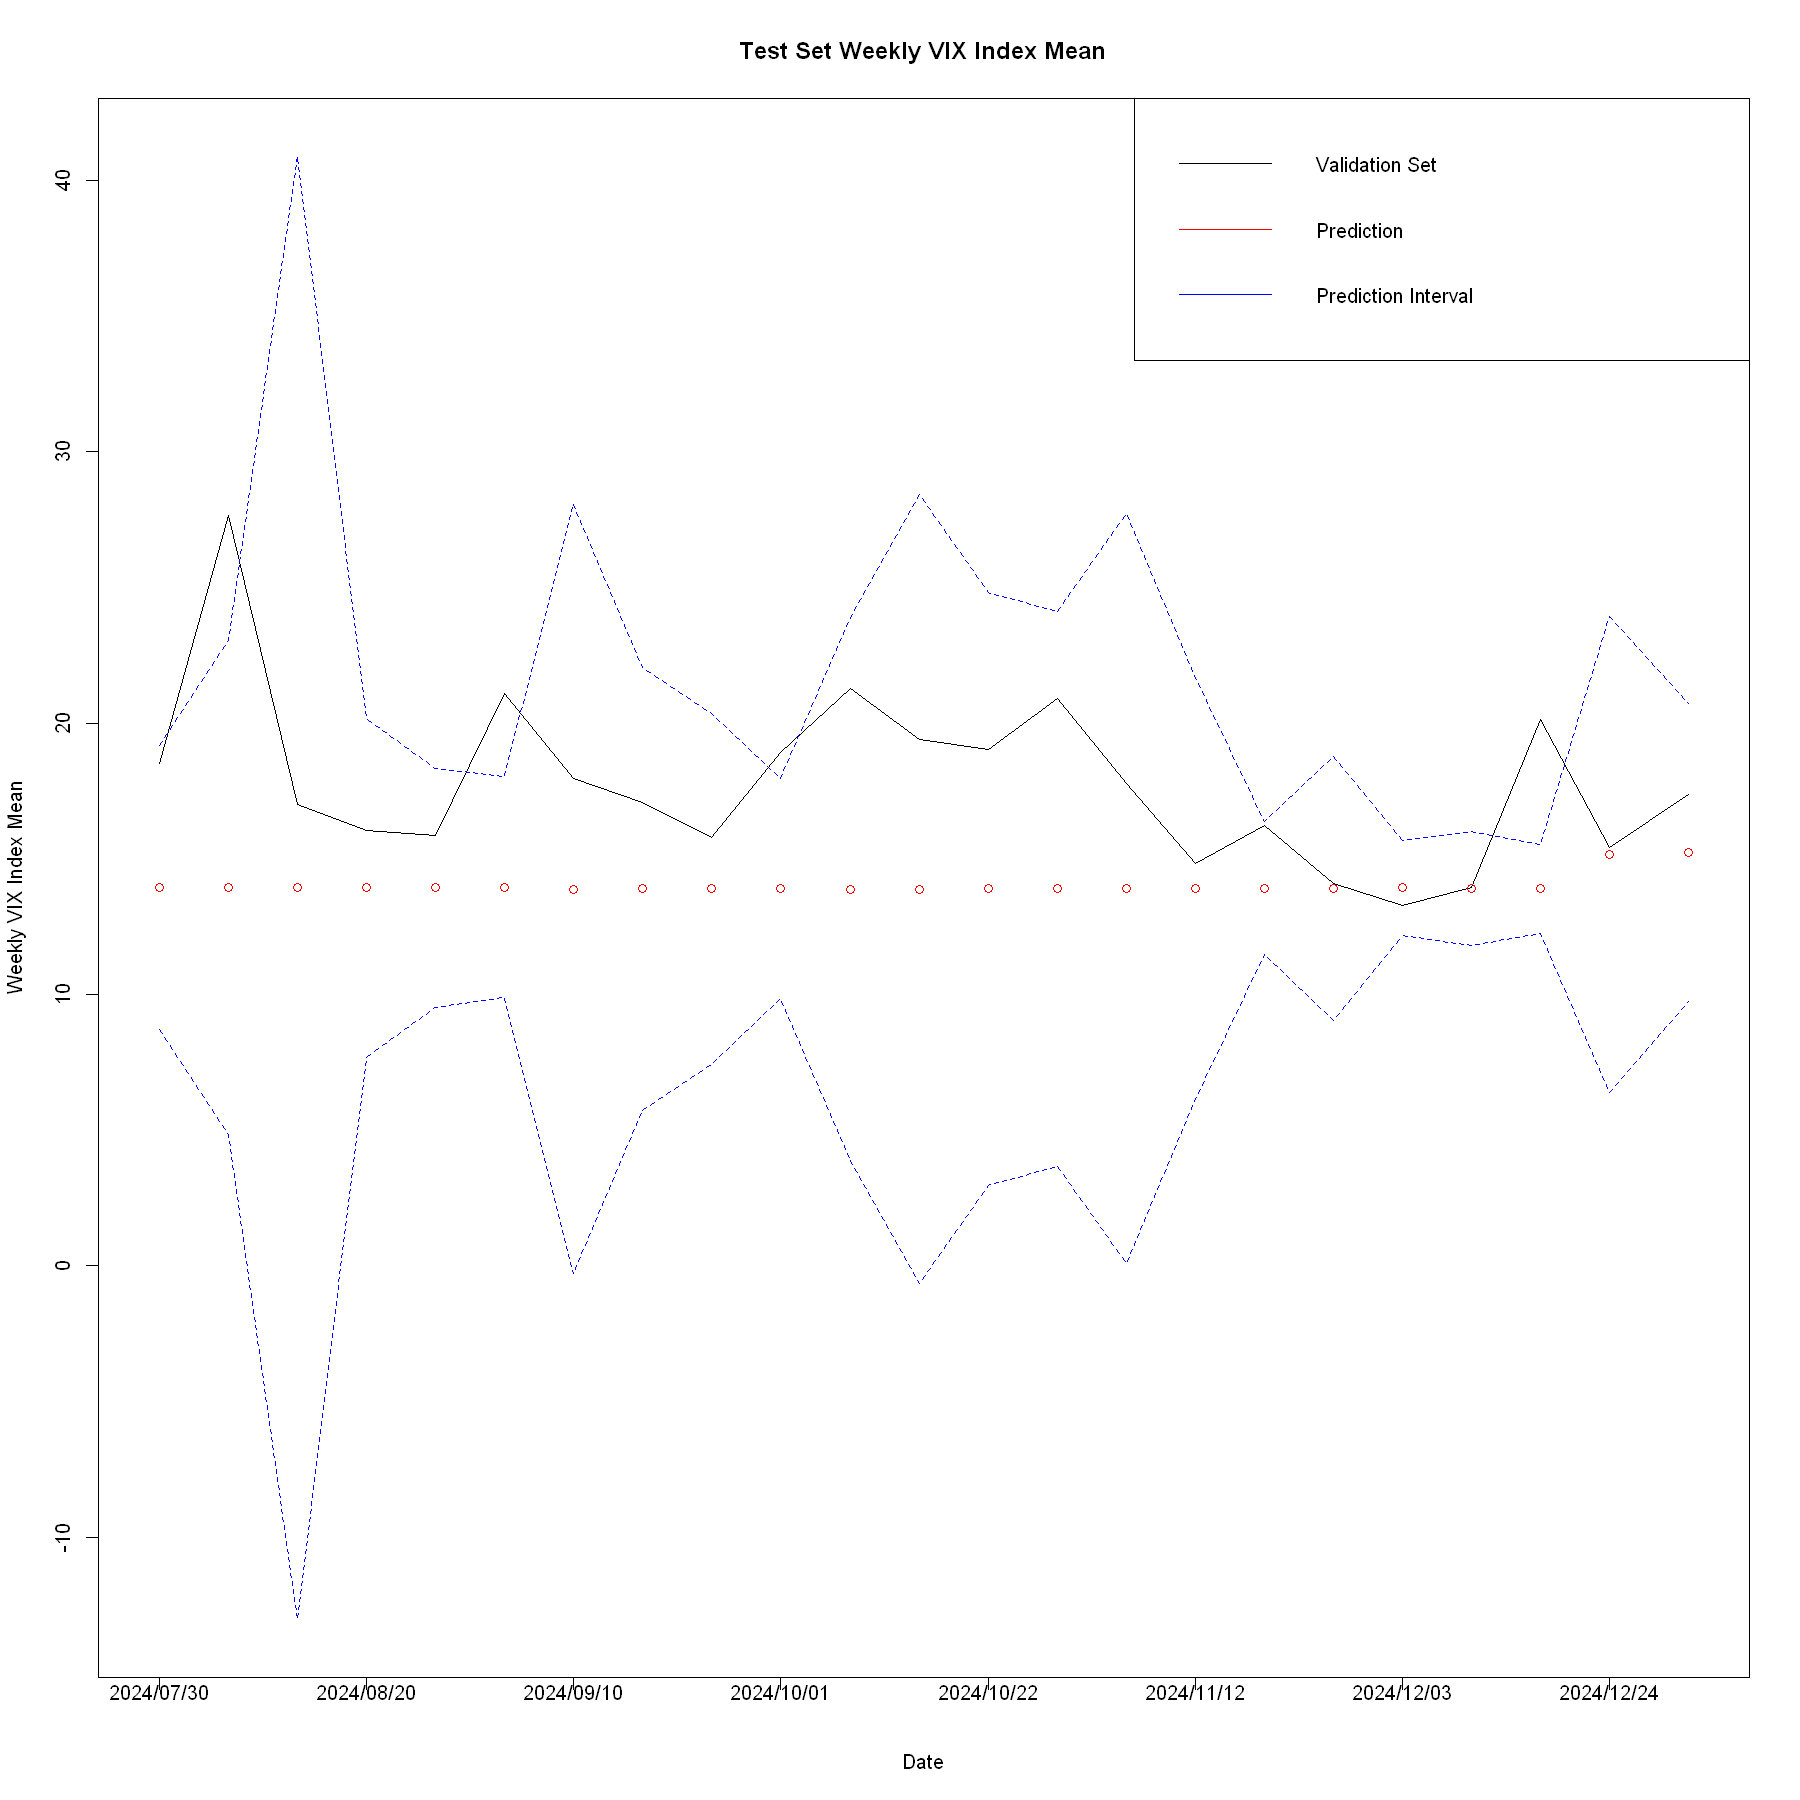

In [296]:
options(repr.plot.width=15, repr.plot.height=15)
plot_garch(vix_weekly_ts_mean.arima.pred_new$pred, vix_weekly_ts_mean.arima.lbound_new, vix_weekly_ts_mean.arima.ubound_new, vix_weekly_ts_mean.test, validation_dates_new, start_valid_new, "Test Set Weekly VIX Index Mean")
plot_garch(vix_weekly_ts_mean.fore.series_new, vix_weekly_ts_mean.lbound_new, vix_weekly_ts_mean.ubound_new, vix_weekly_ts_mean.test, validation_dates_new, start_valid_new, "Test Set Weekly VIX Index Mean")

In [293]:
# lets do the same for weekly last
n = length(vix_weekly_ts_last.test)

vix_weekly_ts_last.arima.pred_new = predict(weekly_last.arima_new, n.ahead = n)
vix_weekly_ts_last.arima.ubound_new = vix_weekly_ts_last.arima.pred_new$pred + 1.96 * vix_weekly_ts_last.arima.pred_new$se
vix_weekly_ts_last.arima.lbound_new = vix_weekly_ts_last.arima.pred_new$pred - 1.96 * vix_weekly_ts_last.arima.pred_new$se

validation_dates_new = time(vix_weekly_ts_last)[length(vix_weekly_ts_last.train_new) + 1: length(vix_weekly_ts_last.test)]
validation_dates_new = as.Date(date_decimal(validation_dates_new))

start_valid_new = validation_dates_new[1]

# lets predict garch
wnfore = length(vix_weekly_ts_last.test)
vix_weekly_ts_last.fore.series_new = NULL
vix_weekly_ts_last.fore.sigma_new = NULL

for(f in 1: wnfore) {
 
  #Fit models
  wdata = vix_weekly_ts_last.train_new
  if(f>=2)
    # need to use the dataset you wanna predict. goal is to predict the next value in the validation set so roll it
    wdata = c(vix_weekly_ts_last.train_new, vix_weekly_ts_last.test[1:(f-1)])  
  w.final.model.1 = ugarchfit(weekly_last.spec2, wdata, solver = 'hybrid')
 
  #Forecast
  wfore = ugarchforecast(w.final.model.1, n.ahead=1)
  vix_weekly_ts_last.fore.series_new = c(vix_weekly_ts_last.fore.series_new, wfore@forecast$seriesFor)
  vix_weekly_ts_last.fore.sigma_new = c(vix_weekly_ts_last.fore.sigma_new, wfore@forecast$sigmaFor)
}

vix_weekly_ts_last.fore.series_new[is.nan(vix_weekly_ts_last.fore.series_new)]=0

# Calculate confidence intervals
vix_weekly_ts_last.ubound_new = vix_weekly_ts_last.fore.series_new + 1.96 * vix_weekly_ts_last.fore.sigma_new
vix_weekly_ts_last.lbound_new = vix_weekly_ts_last.fore.series_new - 1.96 * vix_weekly_ts_last.fore.sigma_new

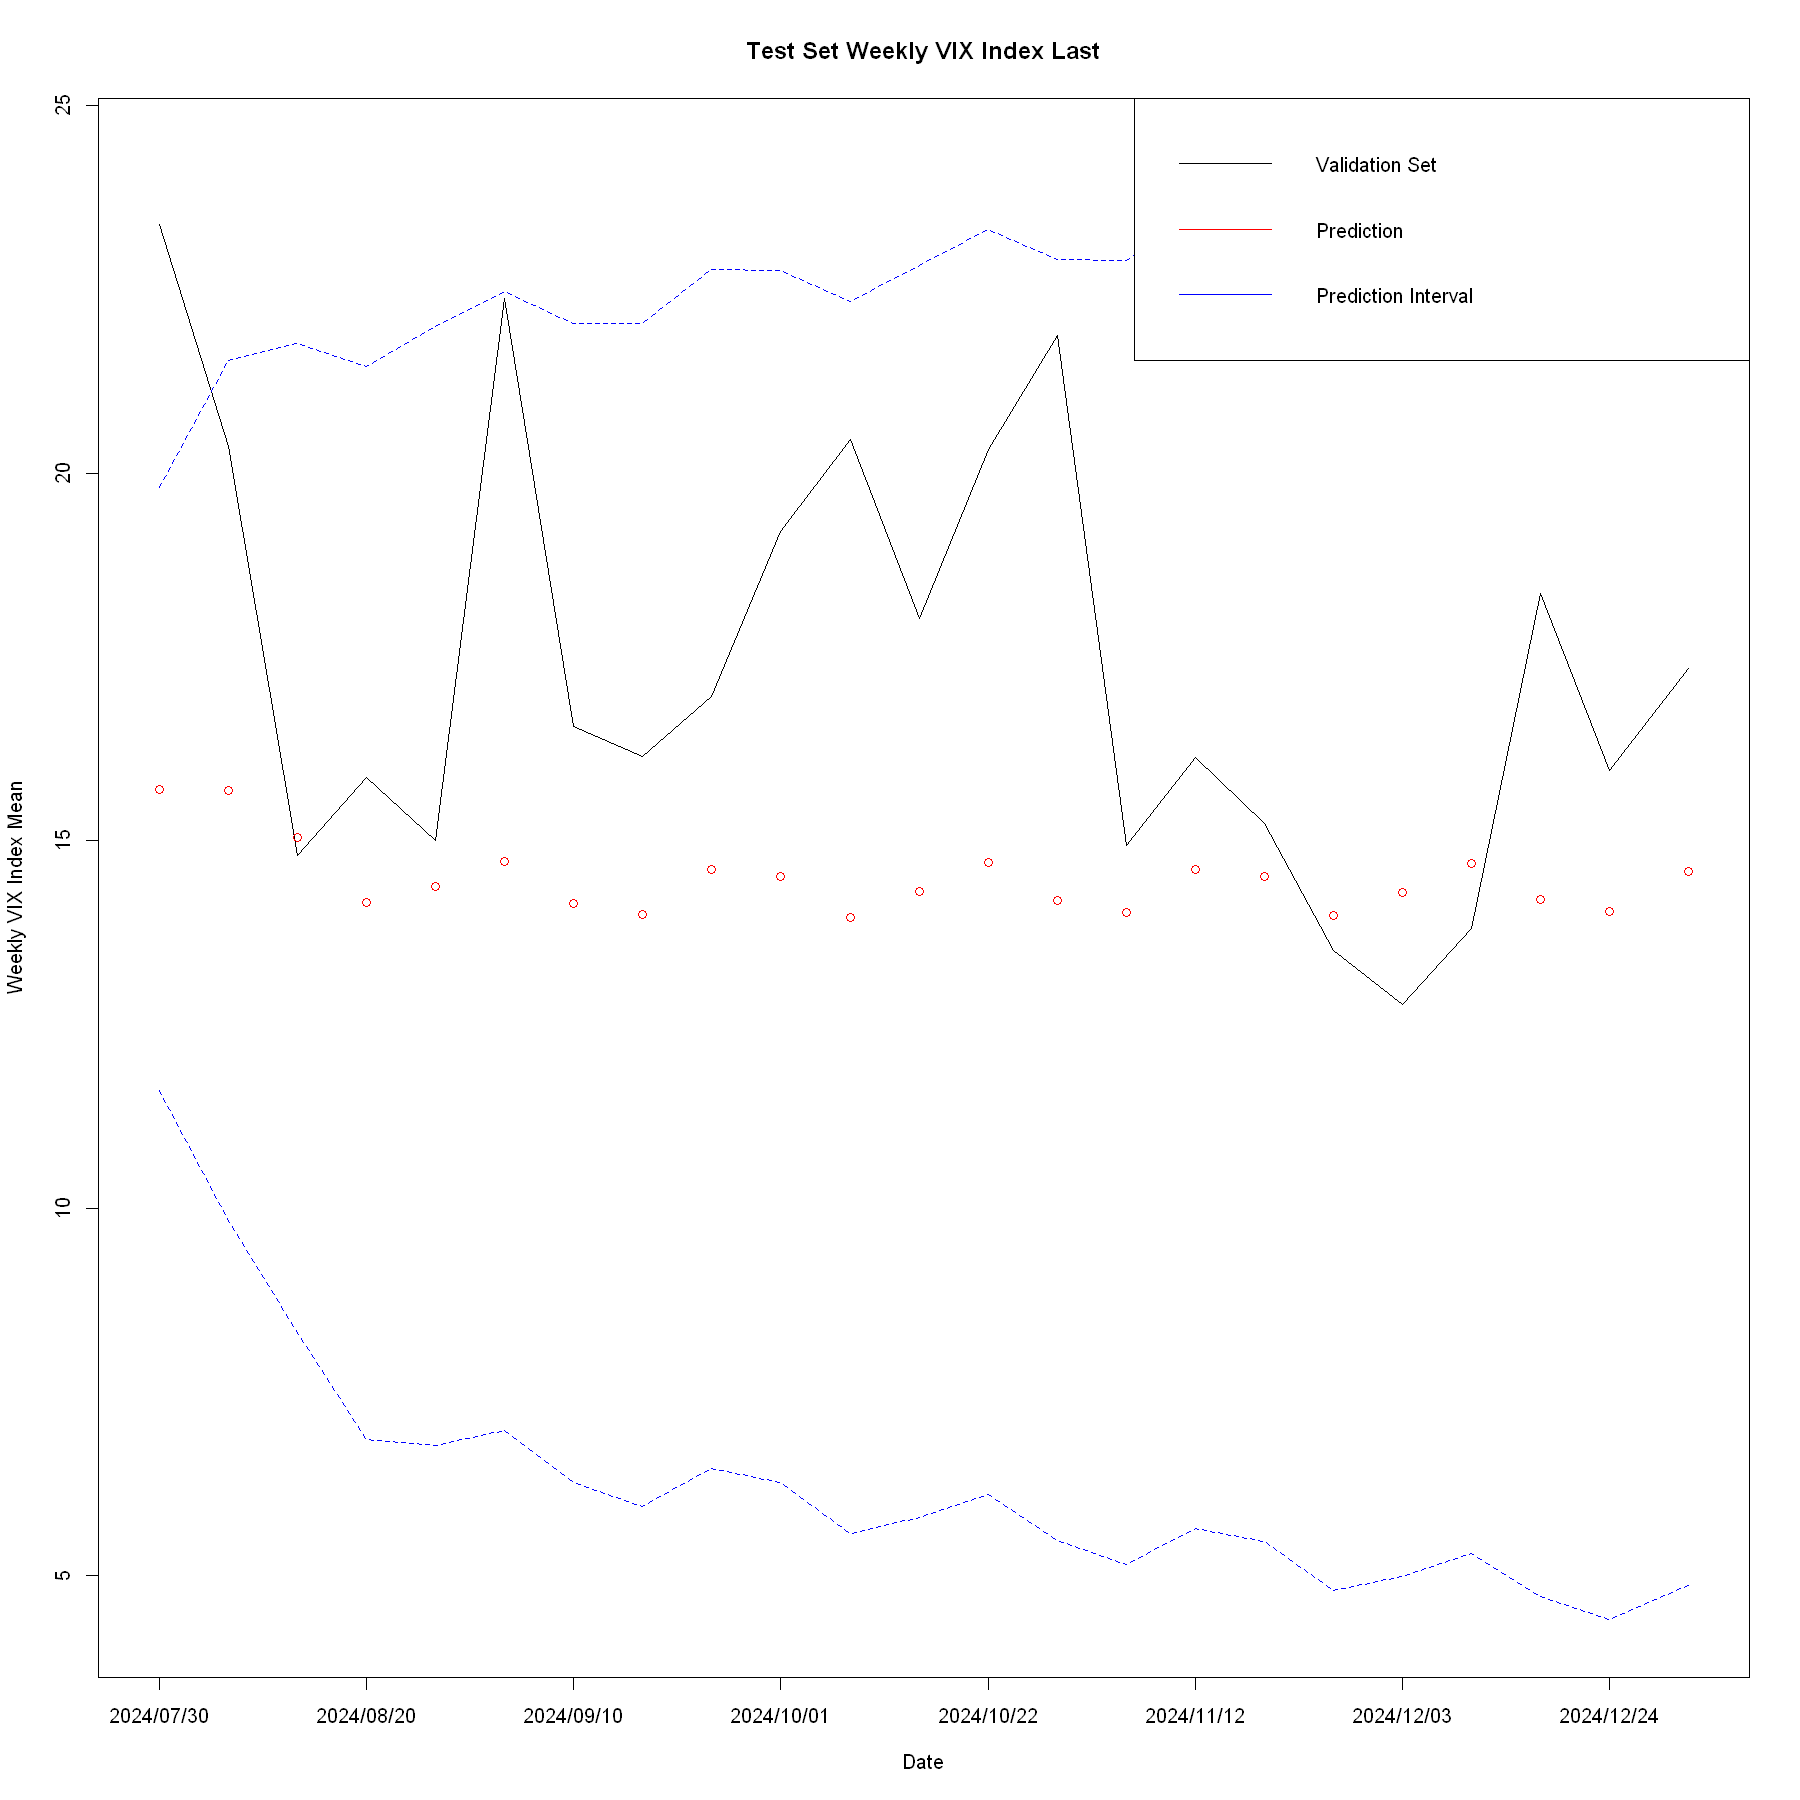

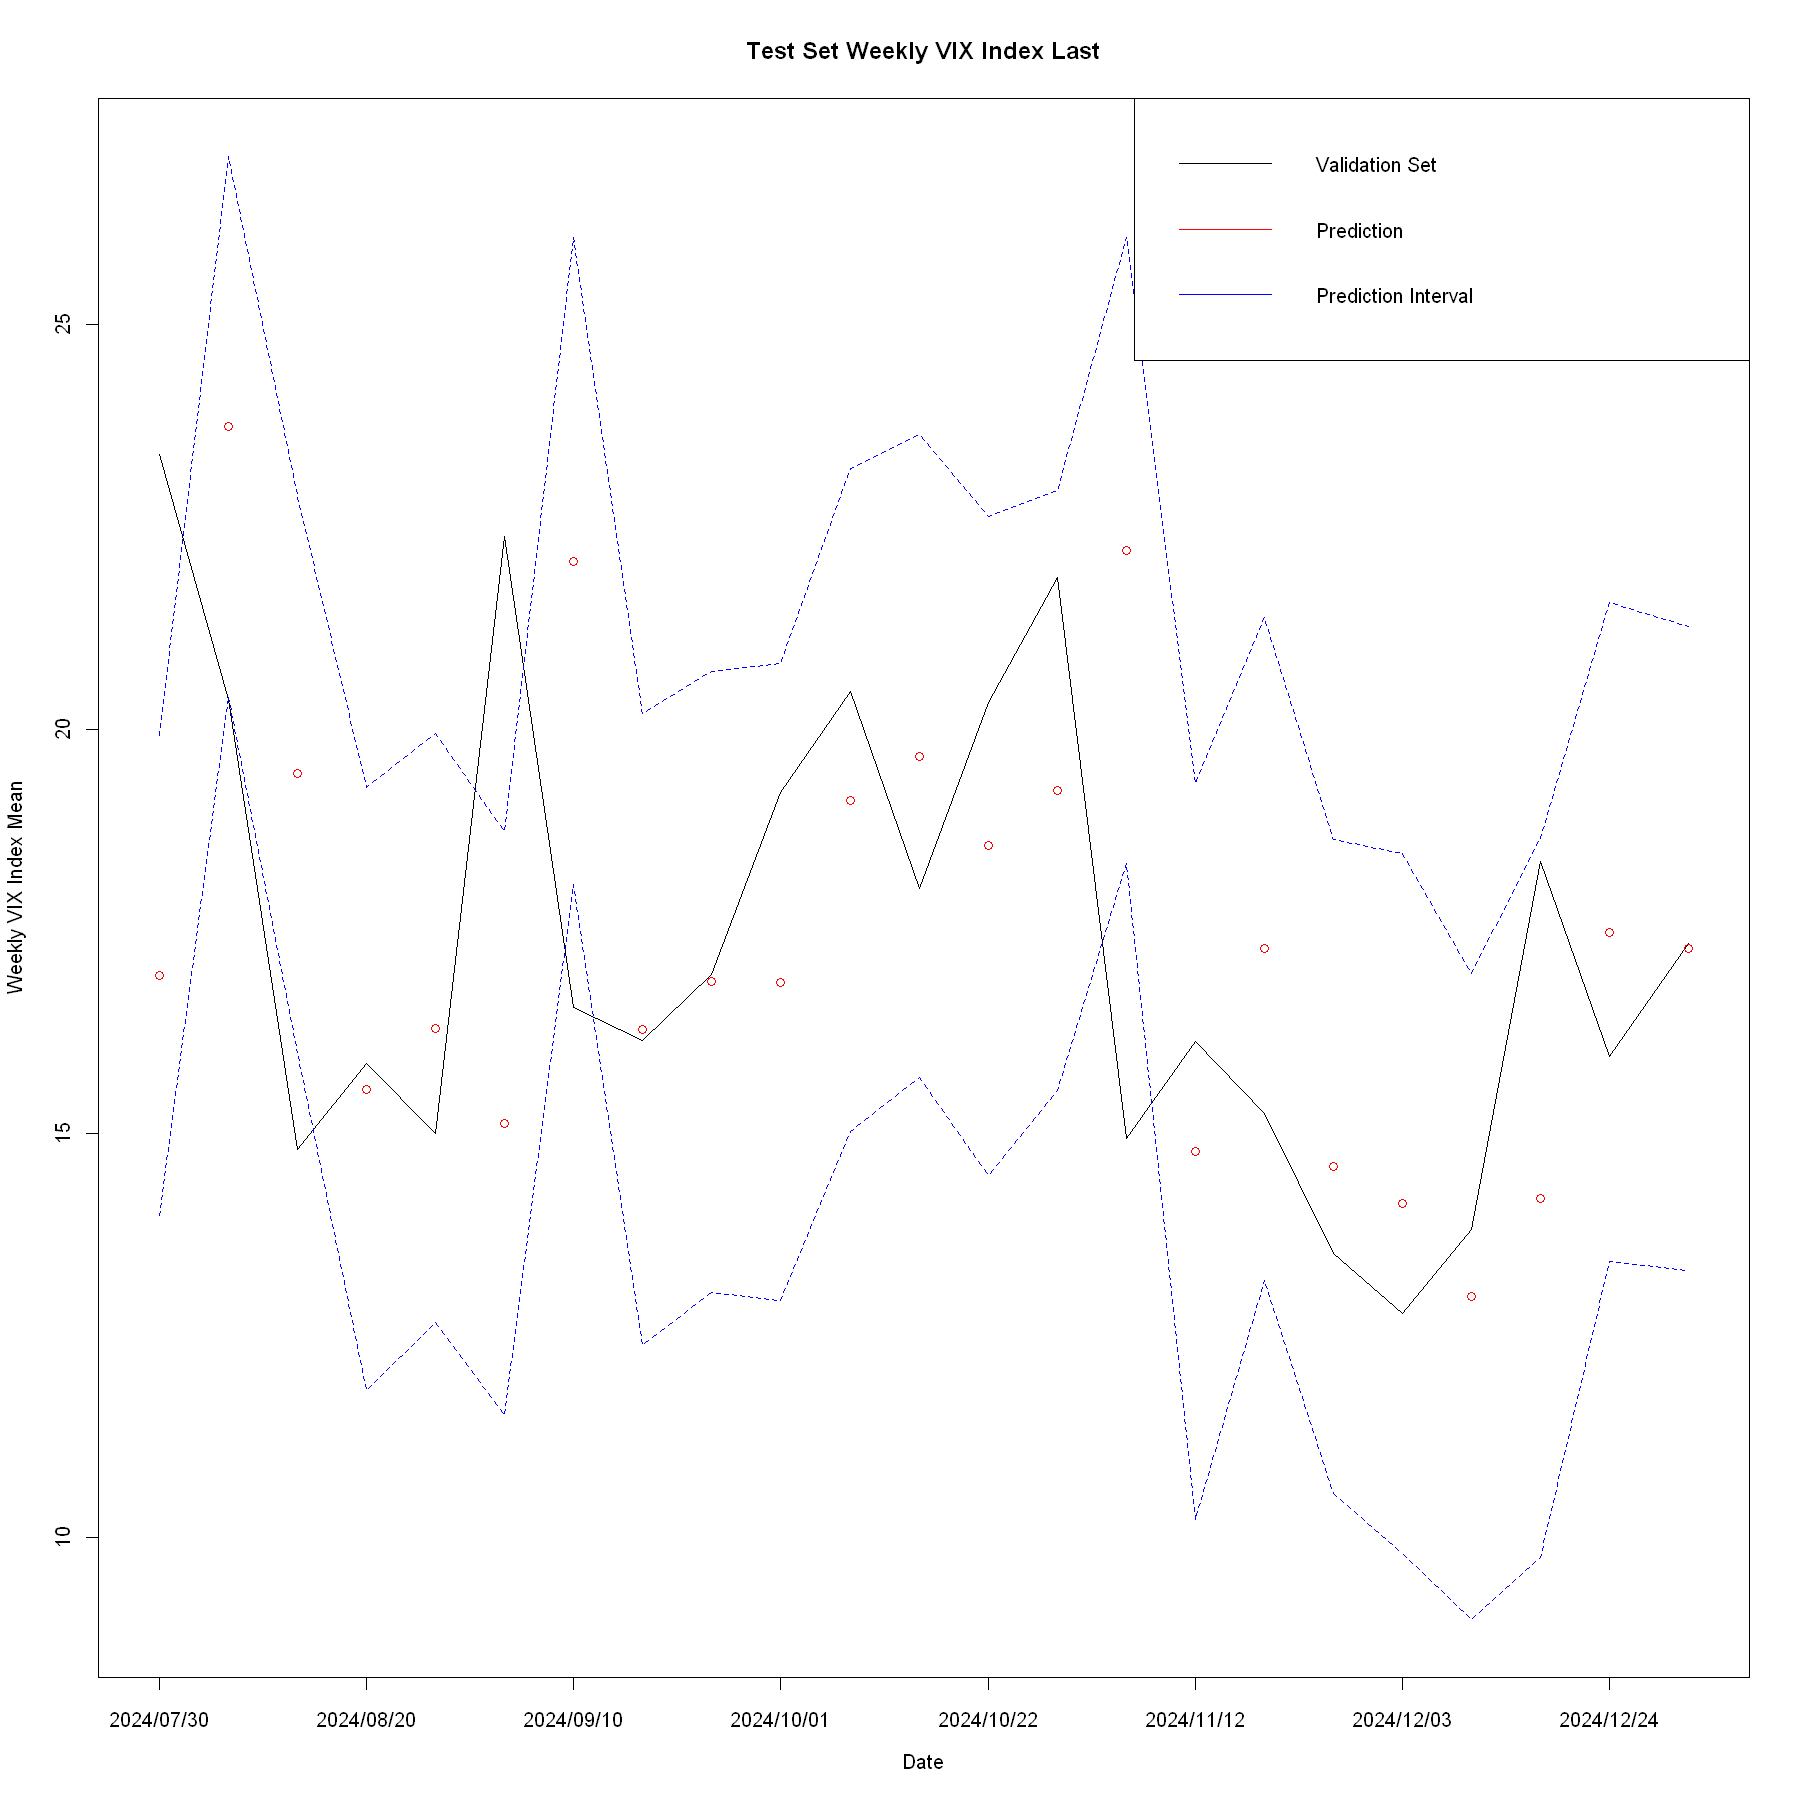

In [ ]:
plot_garch(vix_weekly_ts_last.arima.pred_new$pred, vix_weekly_ts_last.arima.lbound_new, vix_weekly_ts_last.arima.ubound_new, vix_weekly_ts_last.test, validation_dates_new, start_valid_new, "Test Set Weekly VIX Index Last")
plot_garch(vix_weekly_ts_last.fore.series_new, vix_weekly_ts_last.lbound_new, vix_weekly_ts_last.ubound_new, vix_weekly_ts_last.test, validation_dates_new, start_valid_new, "Test Set Weekly VIX Index Last")

In [289]:
# lets do the same for daily
n = length(vix_ts.test)

vix_ts.arima.pred_new = predict(vix_ts.arima_new, n.ahead = n)
vix_ts.arima.ubound_new = vix_ts.arima.pred_new$pred + 1.96 * vix_ts.arima.pred_new$se
vix_ts.arima.lbound_new = vix_ts.arima.pred_new$pred - 1.96 * vix_ts.arima.pred_new$se

validation_dates_new = time(vix_ts)[length(vix_ts.train_new) + 1: length(vix_ts.test)]
validation_dates_new = as.Date(date_decimal(validation_dates_new))

start_valid_new = validation_dates_new[1]

# lets predict garch
wnfore = length(vix_ts.test)
vix_ts.fore.series_new = NULL
vix_ts.fore.sigma_new = NULL

for(f in 1: wnfore) {
 
  #Fit models
  wdata = vix_ts.train_new
  if(f>=2)
    # need to use the dataset you wanna predict. goal is to predict the next value in the validation set so roll it
    wdata = c(vix_ts.train_new, vix_ts.test[1:(f-1)])  
  w.final.model.1 = ugarchfit(daily.spec2, wdata, solver = 'hybrid')
 
  #Forecast
  wfore = ugarchforecast(w.final.model.1, n.ahead=1)
  vix_ts.fore.series_new = c(vix_ts.fore.series_new, wfore@forecast$seriesFor)
  vix_ts.fore.sigma_new = c(vix_ts.fore.sigma_new, wfore@forecast$sigmaFor)
}

vix_ts.fore.series_new[is.nan(vix_ts.fore.series_new)]=0

# Calculate confidence intervals
vix_ts.ubound_new = vix_ts.fore.series_new + 1.96 * vix_ts.fore.sigma_new
vix_ts.lbound_new = vix_ts.fore.series_new - 1.96 * vix_ts.fore.sigma_new

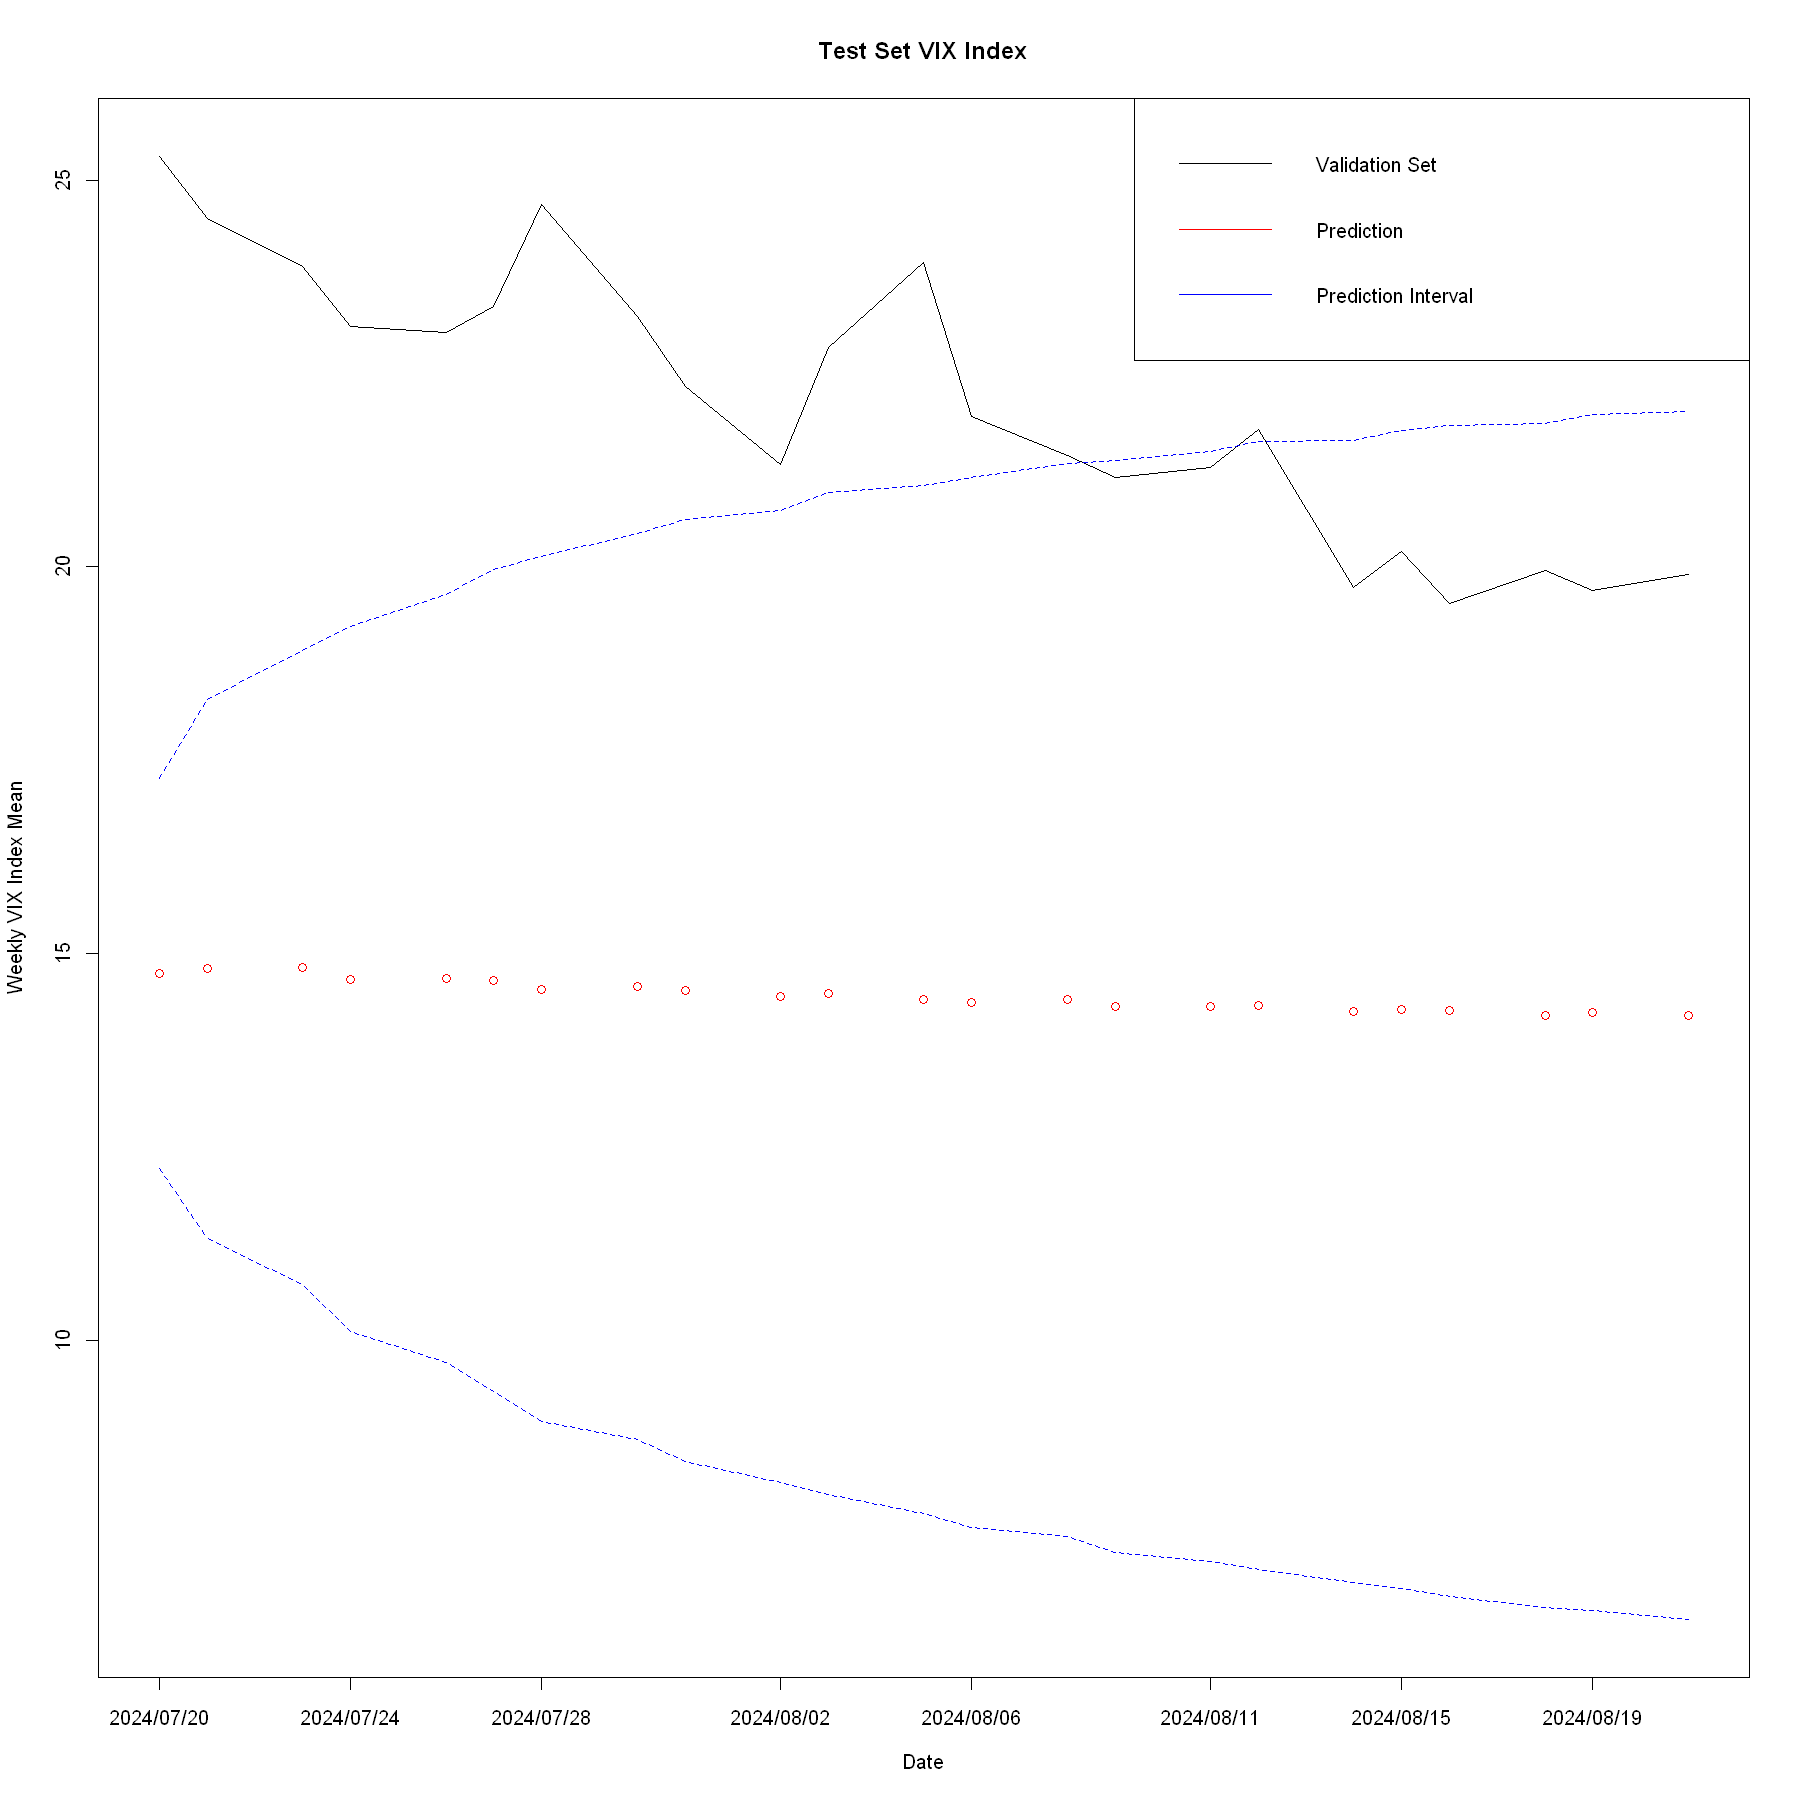

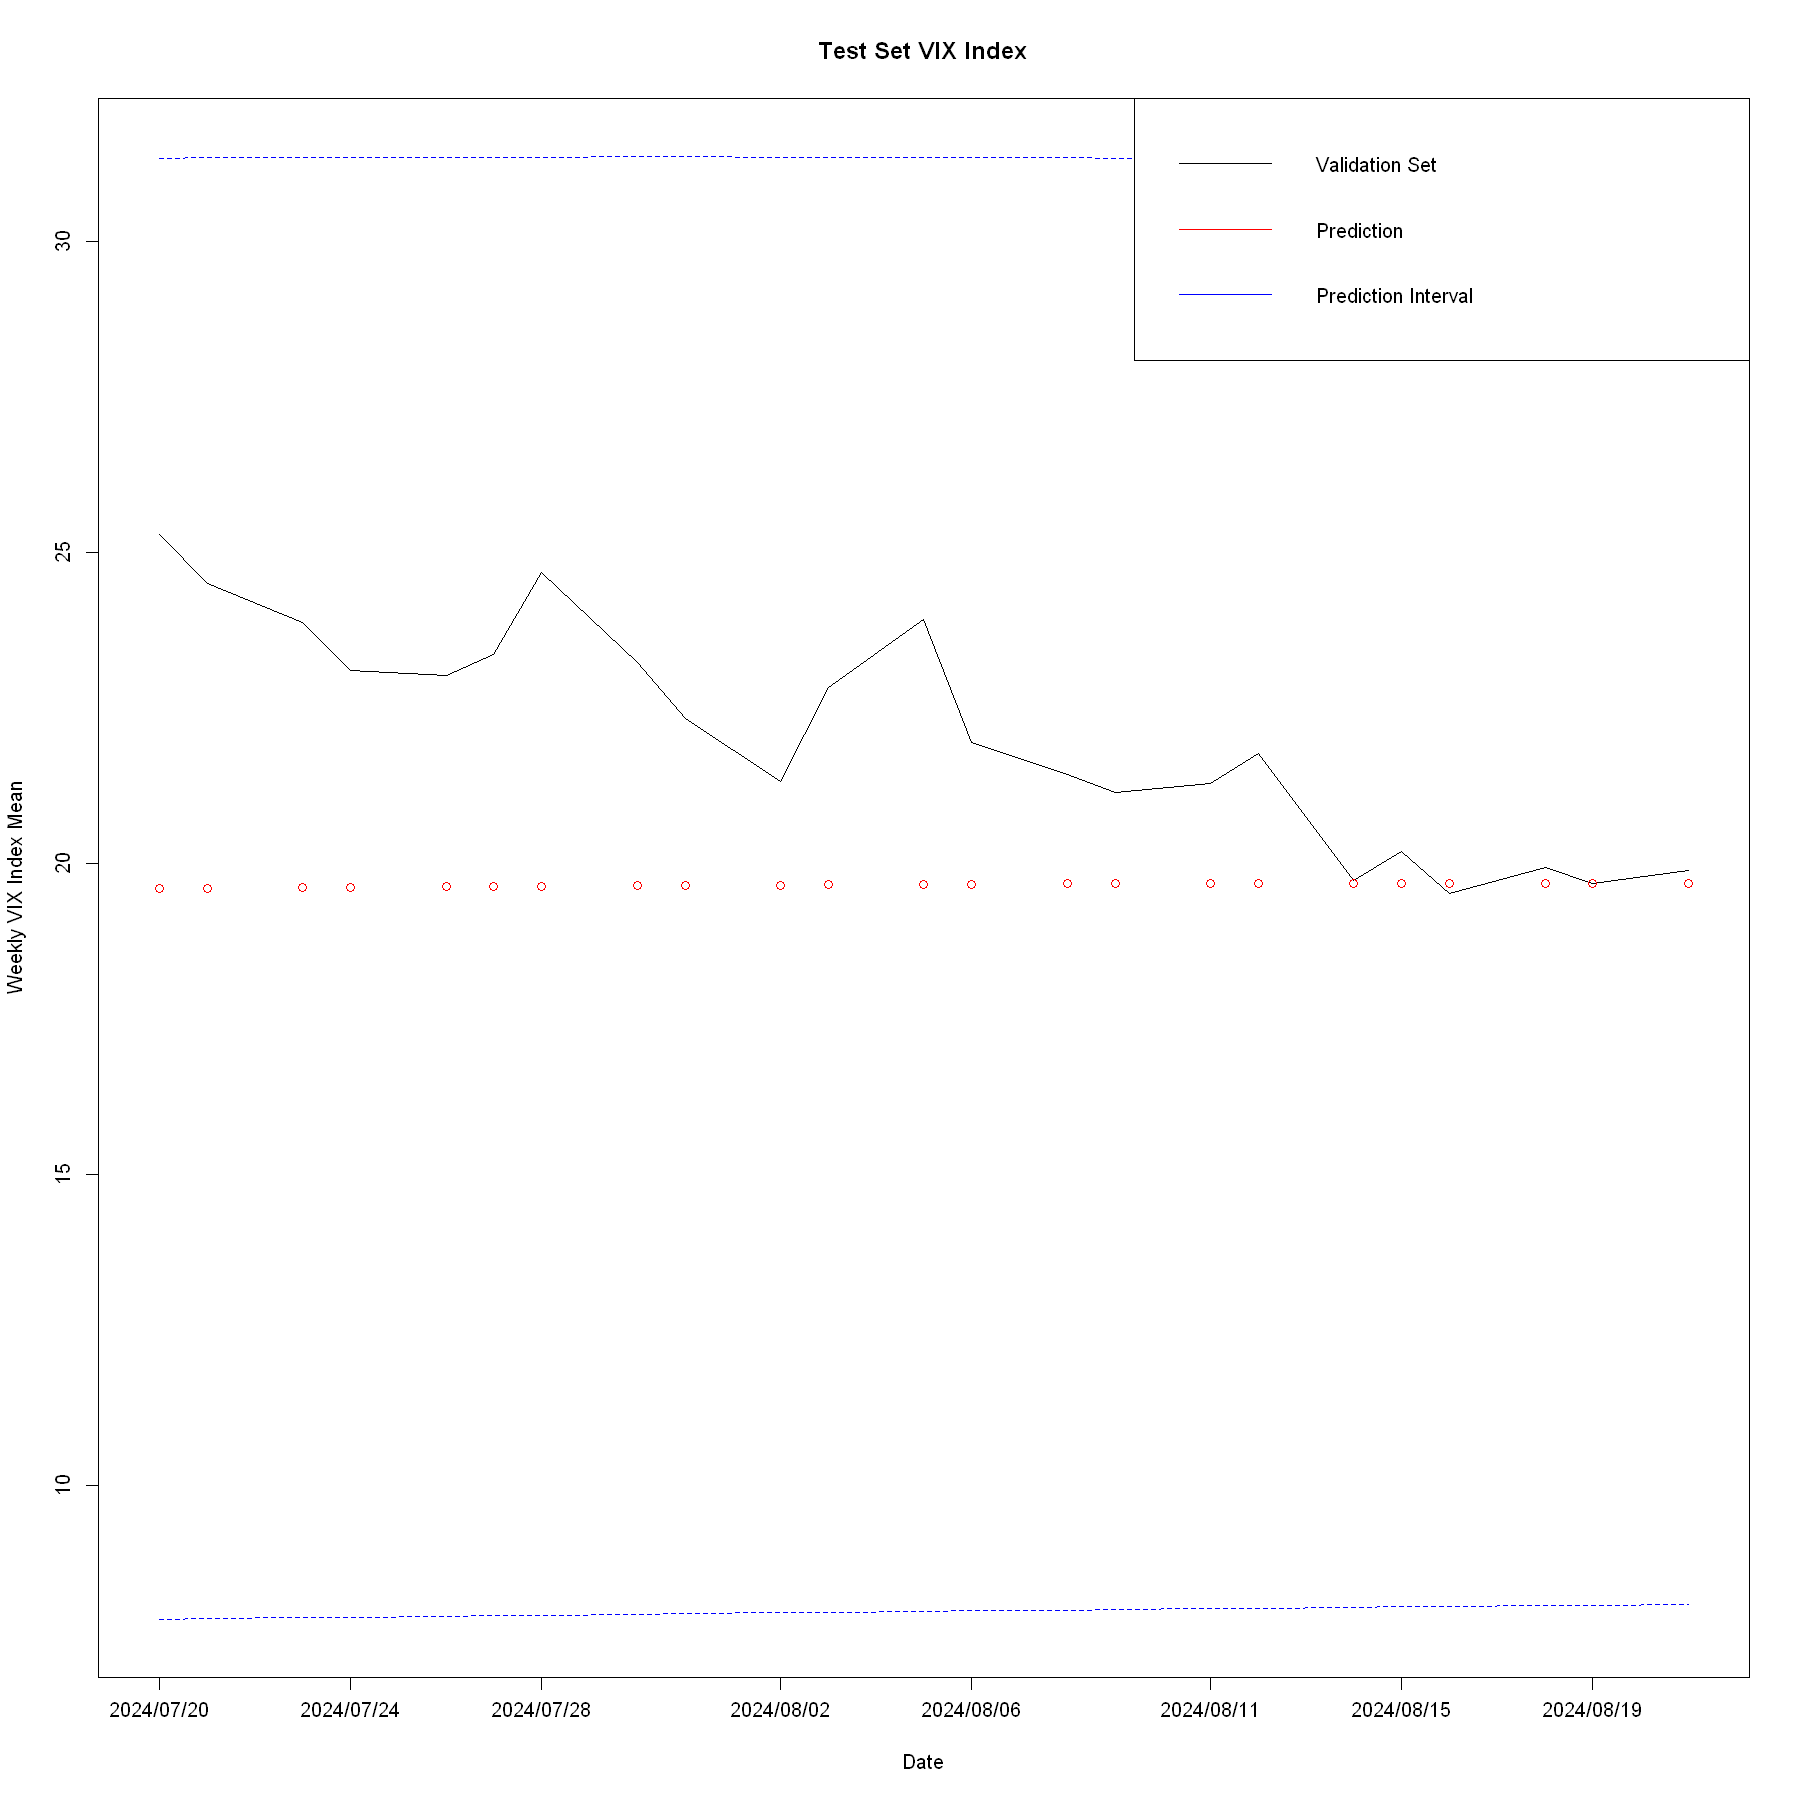

In [ ]:
plot_garch(vix_ts.arima.pred_new$pred, vix_ts.arima.lbound_new, vix_ts.arima.ubound_new, vix_ts.test, validation_dates_new, start_valid_new, "Test Set VIX Index")
plot_garch(vix_ts.fore.series_new, vix_ts.lbound_new, vix_ts.ubound_new, vix_ts.test, validation_dates_new, start_valid_new, "Test Set VIX Index")

In [297]:
# now lets do the metrics for each 
vix_weekly_ts_mean.arima.metrics_new = calculate_metrics(vix_weekly_ts_mean.test, vix_weekly_ts_mean.arima.pred_new$pred)
vix_weekly_ts_last.arima.metrics_new = calculate_metrics(vix_weekly_ts_last.test, vix_weekly_ts_last.arima.pred_new$pred)
vix_ts.arima.metrics_new = calculate_metrics(vix_ts.test, vix_ts.arima.pred_new$pred)

vix_weekly_ts_mean.garch.metrics_new = calculate_metrics(vix_weekly_ts_mean.test, vix_weekly_ts_mean.fore.series_new)
vix_weekly_ts_last.garch.metrics_new = calculate_metrics(vix_weekly_ts_last.test, vix_weekly_ts_last.fore.series_new)
vix_ts.garch.metrics_new = calculate_metrics(vix_ts.test, vix_ts.fore.series_new)

# make ARIMA and GARCH into a dataframe
arima_metrics_df = data.frame(
  Model = c("Weekly VIX Index Mean ARIMA", "Weekly VIX Index Mean ARIMA-GARCH", "Weekly VIX Index Last ARIMA", "Weekly VIX Index Last ARIMA-GARCH", "VIX Index (daily) ARIMA", "VIX Index (daily) ARIMA-GARCH"),
  MAPE = c(vix_weekly_ts_mean.arima.metrics_new$MAPE, vix_weekly_ts_mean.garch.metrics_new$MAPE, vix_weekly_ts_last.arima.metrics_new$MAPE, vix_weekly_ts_last.garch.metrics_new$MAPE, vix_ts.arima.metrics_new$MAPE, vix_ts.garch.metrics_new$MAPE),
    PM = c(vix_weekly_ts_mean.arima.metrics_new$PM, vix_weekly_ts_mean.garch.metrics_new$PM, vix_weekly_ts_last.arima.metrics_new$PM, vix_weekly_ts_last.garch.metrics_new$PM, vix_ts.arima.metrics_new$PM, vix_ts.garch.metrics_new$PM),
    RMSE = c(vix_weekly_ts_mean.arima.metrics_new$RMSE, vix_weekly_ts_mean.garch.metrics_new$RMSE, vix_weekly_ts_last.arima.metrics_new$RMSE, vix_weekly_ts_last.garch.metrics_new$RMSE, vix_ts.arima.metrics_new$RMSE, vix_ts.garch.metrics_new$RMSE),
    MAE = c(vix_weekly_ts_mean.arima.metrics_new$MAE, vix_weekly_ts_mean.garch.metrics_new$MAE, vix_weekly_ts_last.arima.metrics_new$MAE, vix_weekly_ts_last.garch.metrics_new$MAE, vix_ts.arima.metrics_new$MAE, vix_ts.garch.metrics_new$MAE)
)

arima_metrics_df

Model,MAPE,PM,RMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Weekly VIX Index Mean ARIMA,16.64961,1.865751,4.216048,3.271417
Weekly VIX Index Mean ARIMA-GARCH,19.52027,2.551127,4.929976,3.844439
Weekly VIX Index Last ARIMA,16.55428,1.880417,3.975494,3.157444
Weekly VIX Index Last ARIMA-GARCH,14.33661,1.353811,3.373207,2.544384
VIX Index (daily) ARIMA,34.21855,20.429580,7.792931,7.635378
VIX Index (daily) ARIMA-GARCH,10.52518,3.017969,2.995218,2.445805


basically follows what we already observed. 
- VIX Weekly Last && VIX Index (daily) are stronger with GARCH. 
    - **VIX INDEX** strongest
- VIX Weekly Mean gets AWFUL with GARCH

# Next Steps

So the Daily model did amazingly well with the test data. the Weekly Last model did well as well.

- should look into the correlation with VIX to the stock data and sentiment so we can use it 
- questions to think about 
    - does a high VIX forecast align with drops in prices?
    - do high VIX periods have negative sentiment in news articles?
    - can VIX accurately explain price movements?